<span style="color:red; font-weight:bold;">
 XGBOOST sector 
</span>


In [25]:
import pandas as pd
df = pd.read_csv("D:\\Wine quality project\\winequality-red.csv",)


In [2]:
import pandas as pd
df = pd.read_csv("D:\\Wine quality project\\winequality-red.csv",)

In [26]:
import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("gpu:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)


torch: 2.6.0+cu124
cuda available: True
gpu: NVIDIA GeForce GTX 1650 Ti


In [27]:
df.head(100)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0             7.4             0.700         0.00             1.9      0.076   
1             7.8             0.880         0.00             2.6      0.098   
2             7.8             0.760         0.04             2.3      0.092   
3            11.2             0.280         0.56             1.9      0.075   
4             7.4             0.700         0.00             1.9      0.076   
..            ...               ...          ...             ...        ...   
95            4.7             0.600         0.17             2.3      0.058   
96            6.8             0.775         0.00             3.0      0.102   
97            7.0             0.500         0.25             2.0      0.070   
98            7.6             0.900         0.06             2.5      0.079   
99            8.1             0.545         0.18             1.9      0.080   

    free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                  11.0                  34.0   0.9978  3.51       0.56   
1                  25.0                  67.0   0.9968  3.20       0.68   
2                  15.0                  54.0   0.9970  3.26       0.65   
3                  17.0                  60.0   0.9980  3.16       0.58   
4                  11.0                  34.0   0.9978  3.51       0.56   
..                  ...                   ...      ...   ...        ...   
95                 17.0                 106.0   0.9932  3.85       0.60   
96                  8.0                  23.0   0.9965  3.45       0.56   
97                  3.0                  22.0   0.9963  3.25       0.63   
98                  5.0                  10.0   0.9967  3.39       0.56   
99                 13.0                  35.0   0.9972  3.30       0.59   

    alcohol  quality  
0       9.4        5  
1       9.8        5  
2       9.8        5  
3       9.8        6  
4       9.4        5  
..      ...      ...  
95     12.9        6  
96     10.7        5  
97      9.2        5  
98      9.8        5  
99      9.0        6  

[100 rows x 12 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [6]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop("quality", axis=1)
y = df["quality"]

# 80/20 split with stratification to keep class proportions consistent
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape


((1279, 11), (320, 11))

In [28]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

print("Original labels:", sorted(y.unique()))
print("Encoded labels:", sorted(set(y_train_enc)))


Original labels: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
Encoded labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]


<span style="color:RED; font-weight:bold;">
GRIDSEARCH AND SVMSMOTE ONLY ON TRAIN SET , XGBOOST , 5  % WORSE
</span>


In [29]:

#  WITHOUT SMOTE GridSearchCV

from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

xgb_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", XGBClassifier(
        objective="multi:softmax",
        num_class=len(le.classes_),
        eval_metric="mlogloss",
        random_state=42
    ))
])



from sklearn.model_selection import GridSearchCV

param_grid = {
    "model__n_estimators": [200, 400, 600, 800],
    "model__max_depth": [2, 4, 6, 8],
    "model__learning_rate": [0.03, 0.05],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
}

grid = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train_enc)

print("Best Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)


# Extract best XGB parameters cleanly

best_xgb_params = grid.best_estimator_.named_steps["model"].get_params()

# Keep only core XGB params
keep = ["n_estimators", "max_depth", "learning_rate",
        "subsample", "colsample_bytree", "min_child_weight",
        "gamma", "random_state"]

best_params_clean = {k: best_xgb_params[k] for k in keep if k in best_xgb_params}

best_params_clean.update({
    "objective": "multi:softmax",
    "num_class": len(le.classes_),
    "eval_metric": "mlogloss"
})

print("\nClean Best Params for Final Model:\n", best_params_clean)


#  Apply SVMSMOTE on TRAINING SET ONLY

from imblearn.over_sampling import SVMSMOTE
from sklearn.impute import SimpleImputer

# Impute first (same as pipeline)
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

# SVMSMOTE oversampling (train only)
sm = SVMSMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_imp, y_train_enc)


# Train final XGBoost on SVMSMOTE data

final_xgb = XGBClassifier(**best_params_clean)
final_xgb.fit(X_train_res, y_train_res)


# Evaluate on TEST set (NEVER resample test)

from sklearn.metrics import accuracy_score, classification_report

y_pred = final_xgb.predict(X_test_imp)

print("\n==============================================================")
print("FINAL MODEL: XGBoost with SVMSMOTE (after tuning)")
print("Test Accuracy:", accuracy_score(y_test_enc, y_pred))
print("\nClassification Report:\n", classification_report(y_test_enc, y_pred))
print("==============================================================")


Fitting 3 folds for each of 128 candidates, totalling 384 fits
Best Params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.03, 'model__max_depth': 6, 'model__n_estimators': 200, 'model__subsample': 1.0}
Best CV Accuracy: 0.6622192169409903

Clean Best Params for Final Model:
 {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.03, 'subsample': 1.0, 'colsample_bytree': 0.8, 'min_child_weight': 1, 'gamma': 0, 'random_state': 42, 'objective': 'multi:softmax', 'num_class': 6, 'eval_metric': 'mlogloss'}

FINAL MODEL: XGBoost with SVMSMOTE (after tuning)
Test Accuracy: 0.634375

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.71      0.68      0.70       136
           3       0.64      0.65      0.65       128
           4       0.60      0.65      0.63        40
           5       0.33      0.33      0.33         3


In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

results = []

def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")
    results.append((name, acc, macro_f1, weighted_f1))
    print(f"\n{name}")
    print("-" * len(name))
    print(f"Accuracy:     {acc:.4f}")
    print(f"Macro F1:     {macro_f1:.4f}")
    print(f"Weighted F1:  {weighted_f1:.4f}")
    print("\nClassification report:\n", classification_report(y_true, y_pred))

def show_results_table():
    df_res = pd.DataFrame(results, columns=["Model", "Accuracy", "Macro F1", "Weighted F1"])
    return df_res.sort_values("Accuracy", ascending=False)


<span style="color:RED; font-weight:bold;">
TEST/TRIAL , XGBOOST , 2% WORSE
</span>


In [30]:
from xgboost import XGBClassifier

base_xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softmax",
    num_class=len(le.classes_),
    eval_metric="mlogloss",
    random_state=42
)

base_xgb.fit(X_train, y_train_enc)
y_pred_base = base_xgb.predict(X_test)

evaluate_model("XGB – baseline (no resampling)", y_test_enc, y_pred_base)





XGB – baseline (no resampling)
------------------------------
Accuracy:     0.6594
Macro F1:     0.3824
Weighted F1:  0.6454

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.71      0.75      0.73       136
           3       0.62      0.68      0.65       128
           4       0.66      0.53      0.58        40
           5       0.33      0.33      0.33         3

    accuracy                           0.66       320
   macro avg       0.39      0.38      0.38       320
weighted avg       0.63      0.66      0.65       320



d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


<span style="color:RED; font-weight:bold;">
GRIDSEARCH  , XGBOOST , 3 % WORSE
</span>


In [11]:
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

xgb_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", XGBClassifier(
        objective="multi:softmax",
        num_class=len(le.classes_),
        eval_metric="mlogloss",
        random_state=42
    ))
])

param_grid = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [4, 6, 8],
    "model__learning_rate": [0.03, 0.05],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
}

grid = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train_enc)

print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

best_pipe = grid.best_estimator_
y_pred_tuned = best_pipe.predict(X_test)

evaluate_model("XGB – tuned (no resampling)", y_test_enc, y_pred_tuned)

# save clean best XGB params for later experiments
best_xgb_params = best_pipe.named_steps["model"].get_params()

keep = [
    "n_estimators", "max_depth", "learning_rate",
    "subsample", "colsample_bytree", "min_child_weight",
    "gamma", "random_state"
]
best_params_clean = {k: best_xgb_params[k] for k in keep if k in best_xgb_params}
best_params_clean.update({
    "objective": "multi:softmax",
    "num_class": len(le.classes_),
    "eval_metric": "mlogloss",
})
print("\nClean best params for XGB:", best_params_clean)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.03, 'model__max_depth': 6, 'model__n_estimators': 200, 'model__subsample': 1.0}
Best CV accuracy: 0.6622192169409903

XGB – tuned (no resampling)
---------------------------
Accuracy:     0.6719
Macro F1:     0.3894
Weighted F1:  0.6578

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.72      0.75      0.74       136
           3       0.63      0.71      0.67       128
           4       0.70      0.53      0.60        40
           5       0.33      0.33      0.33         3

    accuracy                           0.67       320
   macro avg       0.40      0.39      0.39       320
weighted avg       0.65      0.67      0.66       320


Clean best params for XGB: {'n_estimators': 200, 'max_depth'

d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


<span style="color:RED; font-weight:bold;">
SMOTE AND IMPUTER  XGBOOST , 7% WORSE
</span>


In [12]:
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

#  Impute
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

#  SMOTE on train only
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_imp, y_train_enc)

#  Train tuned XGB on SMOTE data
xgb_smote = XGBClassifier(**best_params_clean)
xgb_smote.fit(X_train_sm, y_train_sm)

#  Evaluate on real test set
y_pred_smote = xgb_smote.predict(X_test_imp)

evaluate_model("XGB – tuned + SMOTE", y_test_enc, y_pred_smote)



XGB – tuned + SMOTE
-------------------
Accuracy:     0.6000
Macro F1:     0.3397
Weighted F1:  0.6123

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.70      0.68      0.69       136
           3       0.63      0.59      0.61       128
           4       0.59      0.57      0.58        40
           5       0.10      0.33      0.15         3

    accuracy                           0.60       320
   macro avg       0.34      0.36      0.34       320
weighted avg       0.63      0.60      0.61       320



<span style="color:RED; font-weight:bold;">
BORDERLINE AND IMPUTER XGBOOST , 5 % WORSE
</span>

In [13]:
from imblearn.over_sampling import BorderlineSMOTE

bsmote = BorderlineSMOTE(random_state=42, kind="borderline-1")
X_train_bsm, y_train_bsm = bsmote.fit_resample(X_train_imp, y_train_enc)

xgb_bsmote = XGBClassifier(**best_params_clean)
xgb_bsmote.fit(X_train_bsm, y_train_bsm)

y_pred_bsmote = xgb_bsmote.predict(X_test_imp)

evaluate_model("XGB – tuned + Borderline-SMOTE", y_test_enc, y_pred_bsmote)



XGB – tuned + Borderline-SMOTE
------------------------------
Accuracy:     0.6312
Macro F1:     0.3847
Weighted F1:  0.6395

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.73      0.68      0.71       136
           3       0.67      0.62      0.65       128
           4       0.56      0.70      0.62        40
           5       0.33      0.33      0.33         3

    accuracy                           0.63       320
   macro avg       0.38      0.39      0.38       320
weighted avg       0.65      0.63      0.64       320



<span style="color:RED; font-weight:bold;">
SVMSMOTE AND IMPUTE XGBOOST , 6% WORSE
</span>


In [14]:
from imblearn.over_sampling import SVMSMOTE

svm_smote = SVMSMOTE(random_state=42)
X_train_svm, y_train_svm = svm_smote.fit_resample(X_train_imp, y_train_enc)

xgb_svm = XGBClassifier(**best_params_clean)
xgb_svm.fit(X_train_svm, y_train_svm)

y_pred_svm = xgb_svm.predict(X_test_imp)

evaluate_model("XGB – tuned + SVMSMOTE", y_test_enc, y_pred_svm)



XGB – tuned + SVMSMOTE
----------------------
Accuracy:     0.6344
Macro F1:     0.3837
Weighted F1:  0.6359

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.71      0.68      0.70       136
           3       0.64      0.65      0.65       128
           4       0.60      0.65      0.63        40
           5       0.33      0.33      0.33         3

    accuracy                           0.63       320
   macro avg       0.38      0.39      0.38       320
weighted avg       0.64      0.63      0.64       320



<span style="color:RED; font-weight:bold;">
 XGBOOST + class weights , 6% WORSE
</span>


In [15]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train_enc)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_enc
)

class_weight_dict = {cls: w for cls, w in zip(classes, class_weights)}
print("Class weights:", class_weight_dict)

# convert to per-sample weights
sample_weights = np.array([class_weight_dict[c] for c in y_train_enc])

# we’ll reuse imputed data from before
xgb_weighted = XGBClassifier(**best_params_clean)
xgb_weighted.fit(X_train_imp, y_train_enc, sample_weight=sample_weights)

y_pred_weighted = xgb_weighted.predict(X_test_imp)

evaluate_model("XGB – tuned + class weights", y_test_enc, y_pred_weighted)


Class weights: {np.int64(0): np.float64(26.645833333333332), np.int64(1): np.float64(5.075396825396825), np.int64(2): np.float64(0.391131498470948), np.int64(3): np.float64(0.41797385620915034), np.int64(4): np.float64(1.3406708595387842), np.int64(5): np.float64(14.21111111111111)}

XGB – tuned + class weights
---------------------------
Accuracy:     0.6250
Macro F1:     0.3717
Weighted F1:  0.6230

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.14      0.09      0.11        11
           2       0.70      0.70      0.70       136
           3       0.62      0.62      0.62       128
           4       0.56      0.60      0.58        40
           5       0.17      0.33      0.22         3

    accuracy                           0.62       320
   macro avg       0.36      0.39      0.37       320
weighted avg       0.62      0.62      0.62       320



In [16]:
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

xgb_scaled_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", XGBClassifier(**best_params_clean))
])

xgb_scaled_pipe.fit(X_train, y_train_enc)
y_pred_scaled = xgb_scaled_pipe.predict(X_test)

evaluate_model("XGB – tuned + StandardScaler", y_test_enc, y_pred_scaled)



XGB – tuned + StandardScaler
----------------------------
Accuracy:     0.6719
Macro F1:     0.3894
Weighted F1:  0.6576

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.72      0.75      0.73       136
           3       0.63      0.71      0.67       128
           4       0.70      0.53      0.60        40
           5       0.33      0.33      0.33         3

    accuracy                           0.67       320
   macro avg       0.40      0.39      0.39       320
weighted avg       0.65      0.67      0.66       320



d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


<span style="color:RED; font-weight:bold;">
summary of progress thus far
</span>


In [17]:
show_results_table()


Model  Accuracy  Macro F1  Weighted F1
1     XGB – tuned (no resampling)  0.671875  0.389410     0.657788
6    XGB – tuned + StandardScaler  0.671875  0.389377     0.657643
0  XGB – baseline (no resampling)  0.659375  0.382415     0.645386
4          XGB – tuned + SVMSMOTE  0.634375  0.383730     0.635871
3  XGB – tuned + Borderline-SMOTE  0.631250  0.384657     0.639538
5     XGB – tuned + class weights  0.625000  0.371657     0.623037
2             XGB – tuned + SMOTE  0.600000  0.339694     0.612272

In [18]:
df_res = show_results_table().drop_duplicates(subset=["Model"])
df_res.sort_values("Accuracy",ascending=False)

Model  Accuracy  Macro F1  Weighted F1
1     XGB – tuned (no resampling)  0.671875  0.389410     0.657788
6    XGB – tuned + StandardScaler  0.671875  0.389377     0.657643
0  XGB – baseline (no resampling)  0.659375  0.382415     0.645386
4          XGB – tuned + SVMSMOTE  0.634375  0.383730     0.635871
3  XGB – tuned + Borderline-SMOTE  0.631250  0.384657     0.639538
5     XGB – tuned + class weights  0.625000  0.371657     0.623037
2             XGB – tuned + SMOTE  0.600000  0.339694     0.612272

<span style="color:RED; font-weight:bold;">
  XGBOOST + scale positive weights , 7% WORSE
</span>


In [19]:

#  XGBoost with scale_pos_weight

from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import numpy as np
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)
# Compute balanced class weights
classes = np.unique(y_train_enc)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_enc
)
# convert weights into the formula used by XGBoost:
# scale_pos_weight is per-class weight (vector)
scale_weights = {int(c): float(w) for c, w in zip(classes, class_weights)}
print("scale_pos_weight:", scale_weights)

#Train model
xgb_scale = XGBClassifier(
    **best_params_clean,
    scale_pos_weight=1.0,   # default, ignored for multi-class
    max_delta_step=0        # stability parameter
)

# XGBoost doesn't directly accept per-class weights for multi:softmax,
# but we can pass sample weights.
sample_weights = np.array([scale_weights[c] for c in y_train_enc])

xgb_scale.fit(X_train_imp, y_train_enc, sample_weight=sample_weights)

# Test performance
y_pred_scale = xgb_scale.predict(X_test_imp)

print("\nXGB — scale_pos_weight version")
print("Accuracy:", accuracy_score(y_test_enc, y_pred_scale))
print("\nClassification Report:\n", classification_report(y_test_enc, y_pred_scale))
evaluate_model("XGBoost with scale_pos_weight", y_test_enc, y_pred_scale)


scale_pos_weight: {0: 26.645833333333332, 1: 5.075396825396825, 2: 0.391131498470948, 3: 0.41797385620915034, 4: 1.3406708595387842, 5: 14.21111111111111}
[12:17:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



XGB — scale_pos_weight version
Accuracy: 0.625

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.14      0.09      0.11        11
           2       0.70      0.70      0.70       136
           3       0.62      0.62      0.62       128
           4       0.56      0.60      0.58        40
           5       0.1

<span style="color:RED; font-weight:bold;">
calibrated XGBOOST , indifferent 
</span>


In [22]:
show_results_table()
df_res = show_results_table().drop_duplicates(subset=["Model"])
df_res.sort_values("Accuracy",ascending=False)

Model  Accuracy  Macro F1  Weighted F1
1     XGB – tuned (no resampling)  0.671875  0.389410     0.657788
6    XGB – tuned + StandardScaler  0.671875  0.389377     0.657643
0  XGB – baseline (no resampling)  0.659375  0.382415     0.645386
4          XGB – tuned + SVMSMOTE  0.634375  0.383730     0.635871
3  XGB – tuned + Borderline-SMOTE  0.631250  0.384657     0.639538
5     XGB – tuned + class weights  0.625000  0.371657     0.623037
7   XGBoost with scale_pos_weight  0.625000  0.371657     0.623037
2             XGB – tuned + SMOTE  0.600000  0.339694     0.612272

<span style="color:RED; font-weight:bold;">
FINAL MODEL: Best-Params XGBoost + Calibration , INDIFFERENT
</span>


In [24]:
#  Calibrated XGBoost

from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer

# --- FIX: ensure best_params_clean is for a *classifier*, not a regressor ---
# The error you got happens when best_params_clean contains a regression objective
# like "reg:squarederror" (or anything starting with "reg:") so sklearn treats it as a regressor.
params = dict(best_params_clean)  # copy so we don't mutate your original dict

# If your search ever ran regression, remove/override those keys for classification
if "objective" in params and str(params["objective"]).startswith("reg:"):
    params.pop("objective", None)
    params.pop("eval_metric", None)

# Make sure we explicitly set a multiclass classification objective
# (If you're doing 6-class, change num_class=6)
params.setdefault("objective", "multi:softprob")
params.setdefault("num_class", int(len(set(y_train_enc))))  # auto-detect classes (3 or 6)
params.setdefault("eval_metric", "mlogloss")
params.setdefault("random_state", 42)

# Optional safety if you had old/deprecated keys in the dict
params.pop("predictor", None)  # harmless if absent

imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

# Train base XGB
xgb_base = XGBClassifier(**params)
xgb_base.fit(X_train_imp, y_train_enc)

# Calibrate probabilities
calibrated_xgb = CalibratedClassifierCV(estimator=xgb_base, method="isotonic", cv=3)
calibrated_xgb.fit(X_train_imp, y_train_enc)

# Predict & score
y_pred_cal = calibrated_xgb.predict(X_test_imp)

print("\nXGB — Calibrated Probabilities")
print("Accuracy:", accuracy_score(y_test_enc, y_pred_cal))
print("\nClassification Report:\n", classification_report(y_test_enc, y_pred_cal))
evaluate_model("Calibrated XGBoost", y_test_enc, y_pred_cal)


ValueError: XGBClassifier should either be a classifier to be used with response_method=['decision_function', 'predict_proba'] or the response_method should be 'predict'. Got a regressor with response_method=['decision_function', 'predict_proba'] instead.

In [ ]:
show_results_table().sort_values("Accuracy", ascending=False)



Model  Accuracy  Macro F1  Weighted F1
10  XGB – best params + calibration  0.671875  0.333413     0.653537
8                Calibrated XGBoost  0.671875  0.333413     0.653537
9                       Best params  0.665625  0.408159     0.656438
0    XGB – baseline (no resampling)  0.656250  0.405873     0.645082
1       XGB – tuned (no resampling)  0.650000  0.390087     0.635140
6      XGB – tuned + StandardScaler  0.650000  0.390087     0.635140
3    XGB – tuned + Borderline-SMOTE  0.634375  0.409819     0.639655
4            XGB – tuned + SVMSMOTE  0.628125  0.376294     0.631103
2               XGB – tuned + SMOTE  0.609375  0.348778     0.624388
5       XGB – tuned + class weights  0.609375  0.362360     0.606577
7     XGBoost with scale_pos_weight  0.609375  0.362360     0.606577

<span style="color:RED; font-weight:bold;">
 INDIFFERENT
</span>


In [ ]:

# XGB best-params + SMOTE-Tomek + Calibration

from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
import numpy as np

# 1. Impute missing values (fit on train, transform both)
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

# 2. Apply SMOTE-Tomek on TRAIN ONLY
smote_tomek = SMOTETomek(random_state=42)
X_train_st, y_train_st = smote_tomek.fit_resample(X_train_imp, y_train_enc)

print("Train shape before SMOTE-Tomek:", X_train_imp.shape, "y:", y_train_enc.shape)
print("Train shape after  SMOTE-Tomek:", X_train_st.shape,  "y:", y_train_st.shape)

# 3. Clean best_params_clean to avoid duplicate args
base_params = best_params_clean.copy()
for key in ["objective", "num_class", "eval_metric", "random_state"]:
    base_params.pop(key, None)

# 4. Build best XGBoost model (softprob for calibration)
xgb_best_st = XGBClassifier(
    **base_params,
    objective="multi:softprob",
    num_class=len(le.classes_),
    eval_metric="mlogloss",
    random_state=42
)

# 5. Train raw model on SMOTE-Tomek data
xgb_best_st.fit(X_train_st, y_train_st)

# 6. Calibrate probabilities (on the same resampled train set)
calibrated_xgb_st = CalibratedClassifierCV(
    estimator=xgb_best_st,
    method="isotonic",
    cv=3
)
calibrated_xgb_st.fit(X_train_st, y_train_st)

# 7. Evaluate on REAL (unresampled) test set
y_pred_st_cal = calibrated_xgb_st.predict(X_test_imp)

print("\n=== XGB (best params) + SMOTE-Tomek + Calibration ===")
print("Accuracy:", accuracy_score(y_test_enc, y_pred_st_cal))
print("\nClassification Report:\n",
      classification_report(y_test_enc, y_pred_st_cal))

# 8. Log into your results table
evaluate_model("XGB – best params + SMOTETomek + calibration",
               y_test_enc, y_pred_st_cal)


Train shape before SMOTE-Tomek: (1279, 11) y: (1279,)
Train shape after  SMOTE-Tomek: (3090, 11) y: (3090,)

=== XGB (best params) + SMOTE-Tomek + Calibration ===
Accuracy: 0.596875

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.06      0.09      0.07        11
           2       0.71      0.68      0.70       136
           3       0.62      0.56      0.59       128
           4       0.56      0.60      0.58        40
           5       0.11      0.33      0.17         3

    accuracy                           0.60       320
   macro avg       0.34      0.38      0.35       320
weighted avg       0.62      0.60      0.61       320


XGB – best params + SMOTETomek + calibration
--------------------------------------------
Accuracy:     0.5969
Macro F1:     0.3501
Weighted F1:  0.6084

Classification report:
               precision    recall  f1-score   support

           0    

<span style="color:RED; font-weight:bold;">
 SMOTETOMEK + IMPUTER + GRIDSEARCH , 20% Worse 
</span>


In [ ]:

# Wide GridSearchCV + SMOTE-Tomek + Imputer

from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier


wide_pipe_st = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("smote_tomek", SMOTETomek(random_state=42)),
    ("model", XGBClassifier(
        objective="multi:softmax",
        num_class=len(le.classes_),
        eval_metric="mlogloss",
        random_state=42
    ))
])


wide_grid_st = {
    "model__n_estimators": [300, 600, 900],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.03, 0.05],
    "model__gamma": [0, 0.1, 0.2],
    "model__subsample": [0.7, 0.85, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__min_child_weight": [1, 3, 5],
}


wide_search_st = GridSearchCV(
    estimator=wide_pipe_st,
    param_grid=wide_grid_st,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=2
)


wide_search_st.fit(X_train, y_train_enc)

print("\nBest params (SMOTE-Tomek):", wide_search_st.best_params_)
print("Best CV accuracy (SMOTE-Tomek):", wide_search_st.best_score_)


wide_best_st = wide_search_st.best_estimator_
y_pred_wide_st = wide_best_st.predict(X_test)

print("\n=== XGB — Wide Grid Search + SMOTE-Tomek ===")
print("Test Accuracy:", accuracy_score(y_test_enc, y_pred_wide_st))
print("\nClassification Report:\n",
      classification_report(y_test_enc, y_pred_wide_st))


evaluate_model("XGB – wide grid + SMOTETomek", y_test_enc, y_pred_wide_st)


Fitting 3 folds for each of 2187 candidates, totalling 6561 fits


d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
4374 fits failed out of a total of 6561.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4374 fits failed with the following error:
Traceback (most recent call last):
  File "d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\base.py", line 1336, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\red wine project\.venv-gpu\Lib\site-packages\imblearn\pipeline.py", line 514, in fit
  


Best params (SMOTE-Tomek): {'model__colsample_bytree': 0.6, 'model__gamma': 0, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__min_child_weight': 1, 'model__n_estimators': 300, 'model__subsample': 0.7}
Best CV accuracy (SMOTE-Tomek): nan

=== XGB — Wide Grid Search + SMOTE-Tomek ===
Test Accuracy: 0.48125

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.09      0.36      0.14        11
           2       0.71      0.59      0.64       136
           3       0.66      0.34      0.45       128
           4       0.34      0.60      0.43        40
           5       0.12      0.67      0.21         3

    accuracy                           0.48       320
   macro avg       0.32      0.43      0.31       320
weighted avg       0.61      0.48      0.51       320


XGB – wide grid + SMOTETomek
----------------------------
Accuracy:     0.4813
Macro F1:     0.3129
Weighted F

<span style="color:ORANGE; font-weight:bold;">
RANDON OVERSAMPLING ,  PRACTICE 
</span>


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter


X = df.drop("quality", axis=1)
y = df["quality"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("\nOriginal labels:", sorted(y.unique()))
print("Encoded labels:", sorted(set(y_train_enc)))


# Random Oversampling (ONLY ON TRAINING DATA)

print("\nClass counts BEFORE oversampling:", Counter(y_train_enc))

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train_enc)

print("Class counts AFTER oversampling:", Counter(y_train_res))

# Feature Scaling

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

print("\nOversampled & Scaled train shape:", X_train_scaled.shape)
print("Scaled test shape:", X_test_scaled.shape)

# FINAL OUTPUT VARIABLES FOR MODEL TRAINING


print("\nREADY TO USE VARIABLES:")
print("Training: X_train_scaled, y_train_res")
print("Testing : X_test_scaled, y_test_enc")


Train shapes: (1279, 11) (1279,)
Test shapes: (320, 11) (320,)

Original labels: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
Encoded labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

Class counts BEFORE oversampling: Counter({np.int64(2): 545, np.int64(3): 510, np.int64(4): 159, np.int64(1): 42, np.int64(5): 15, np.int64(0): 8})
Class counts AFTER oversampling: Counter({np.int64(3): 545, np.int64(2): 545, np.int64(4): 545, np.int64(0): 545, np.int64(1): 545, np.int64(5): 545})

Oversampled & Scaled train shape: (3270, 11)
Scaled test shape: (320, 11)

READY TO USE VARIABLES:
Training: X_train_scaled, y_train_res
Testing : X_test_scaled, y_test_enc


<span style="color:RED; font-weight:bold;">
 RANDOM OVERSAMPLING , INDIFFERENT
</span>


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from xgboost import XGBClassifier

X = df.drop("quality", axis=1)
y = df["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

print("Original labels:", sorted(y.unique()))
print("Encoded labels :", sorted(set(y_train_enc)))
print("\nClass counts BEFORE oversampling:", Counter(y_train_enc))
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train_enc)
print("Class counts AFTER oversampling :", Counter(y_train_res))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled  = scaler.transform(X_test)

xgb_model = XGBClassifier(
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multi:softmax",
)

xgb_model.fit(X_train_scaled, y_train_res)

y_pred = xgb_model.predict(X_test_scaled)

print("\nAccuracy:", accuracy_score(y_test_enc, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test_enc, y_pred))
print("\nClassification report:\n", classification_report(y_test_enc, y_pred))


Original labels: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
Encoded labels : [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

Class counts BEFORE oversampling: Counter({np.int64(2): 545, np.int64(3): 510, np.int64(4): 159, np.int64(1): 42, np.int64(5): 15, np.int64(0): 8})
Class counts AFTER oversampling : Counter({np.int64(3): 545, np.int64(2): 545, np.int64(4): 545, np.int64(0): 545, np.int64(1): 545, np.int64(5): 545})

Accuracy: 0.646875

Confusion matrix:
 [[ 0  1  1  0  0  0]
 [ 1  0  6  4  0  0]
 [ 0  3 98 33  2  0]
 [ 0  1 29 87 10  1]
 [ 0  0  3 14 21  2]
 [ 0  0  0  1  1  1]]

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.72      0.72      0.72       136
           3       0.63      0.68      0.65       128
           4       0.62      0.53      0.57 

<span style="color:RED; font-weight:bold;">
RANDOM OVERSAMPLING + TRIAL/TEST PARAMETERS, INDIFFERENT
</span>


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from xgboost import XGBClassifier

X = df.drop("quality", axis=1)
y = df["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

print("Original labels:", sorted(y.unique()))
print("Encoded labels :", sorted(set(y_train_enc)))
print("\nClass counts BEFORE oversampling:", Counter(y_train_enc))

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train_enc)

print("Class counts AFTER oversampling :", Counter(y_train_res))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled  = scaler.transform(X_test)



best_params_clean = {
    "n_estimators": 500,
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "gamma": 0,
    "min_child_weight": 1,
    "reg_alpha": 0.0,
    "reg_lambda": 1.0
}



for k in ["objective", "num_class", "eval_metric", "random_state"]:
    best_params_clean.pop(k, None)

xgb = XGBClassifier(
    **best_params_clean,
    objective="multi:softmax",
    num_class=len(le.classes_),
    eval_metric="mlogloss",
    random_state=42
)


xgb.fit(X_train_scaled, y_train_res)

y_pred = xgb.predict(X_test_scaled)

print("\nAccuracy:", accuracy_score(y_test_enc, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test_enc, y_pred))
print("\nClassification report:\n", classification_report(y_test_enc, y_pred))


Original labels: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
Encoded labels : [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

Class counts BEFORE oversampling: Counter({np.int64(2): 545, np.int64(3): 510, np.int64(4): 159, np.int64(1): 42, np.int64(5): 15, np.int64(0): 8})
Class counts AFTER oversampling : Counter({np.int64(3): 545, np.int64(2): 545, np.int64(4): 545, np.int64(0): 545, np.int64(1): 545, np.int64(5): 545})

Accuracy: 0.665625

Confusion matrix:
 [[  0   1   1   0   0   0]
 [  1   1   5   4   0   0]
 [  0   2 102  30   2   0]
 [  0   1  30  86  10   1]
 [  0   0   2  13  23   2]
 [  0   0   0   1   1   1]]

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.20      0.09      0.12        11
           2       0.73      0.75      0.74       136
           3       0.64      0.67      0.66       128
        

<span style="color:RED; font-weight:bold;">
 INDIFFERENT
</span>


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from collections import Counter

X = df.drop("quality", axis=1)
y = df["quality"]

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

print("Original labels:", sorted(y.unique()))
print("Encoded labels :", sorted(set(y_train_enc)))
print("\nClass counts BEFORE SMOTE:", Counter(y_train_enc))

sm = SMOTE(random_state=42, k_neighbors=3)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train_enc)

print("Class counts AFTER SMOTE :", Counter(y_train_res))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled  = scaler.transform(X_test)


# Tuned XGBoost Model (Insert your best params here)


best_params_clean = {
    "n_estimators": 500,
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "gamma": 0,
    "min_child_weight": 1,
    "reg_alpha": 0.0,
    "reg_lambda": 1.0
}

# drop OLD params, new ones  will override
for k in ["objective", "num_class", "eval_metric", "random_state"]:
    best_params_clean.pop(k, None)

xgb = XGBClassifier(
    **best_params_clean,
    objective="multi:softmax",
    num_class=len(le.classes_),
    eval_metric="mlogloss",
    random_state=42
)

# Train
xgb.fit(X_train_scaled, y_train_res)

y_pred = xgb.predict(X_test_scaled)

print("\nAccuracy:", accuracy_score(y_test_enc, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test_enc, y_pred))
print("\nClassification report:\n", classification_report(y_test_enc, y_pred))


Original labels: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
Encoded labels : [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

Class counts BEFORE SMOTE: Counter({np.int64(2): 545, np.int64(3): 510, np.int64(4): 159, np.int64(1): 42, np.int64(5): 15, np.int64(0): 8})
Class counts AFTER SMOTE : Counter({np.int64(3): 545, np.int64(2): 545, np.int64(4): 545, np.int64(0): 545, np.int64(1): 545, np.int64(5): 545})

Accuracy: 0.634375

Confusion matrix:
 [[ 0  1  1  0  0  0]
 [ 1  0  6  4  0  0]
 [ 1  8 92 33  2  0]
 [ 0  4 26 86 10  2]
 [ 0  0  3 10 24  3]
 [ 0  0  0  0  2  1]]

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.72      0.68      0.70       136
           3       0.65      0.67      0.66       128
           4       0.63      0.60      0.62        40
    

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
from xgboost import XGBClassifier
import numpy as np
X = df.drop("quality", axis=1)
y = df["quality"]

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

print("Original labels:", sorted(y.unique()))
print("Encoded labels :", sorted(set(y_train_enc)))


# Compute class weights (inverse frequency)
#    weight_c = N / (K * n_c)

class_counts = Counter(y_train_enc)
n_classes = len(class_counts)
n_samples = len(y_train_enc)

class_weights = {
    cls: n_samples / (n_classes * count)
    for cls, count in class_counts.items()
}

print("\nClass counts:", class_counts)
print("Class weights:", class_weights)

# turn class weights into per-sample weights
sample_weights = np.array([class_weights[c] for c in y_train_enc])


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


# Tuned XGBoost with sample weights

best_params_clean = {
    "n_estimators": 500,
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "gamma": 0,
    "min_child_weight": 1,
    "reg_alpha": 0.0,
    "reg_lambda": 1.0
}

for k in ["objective", "num_class", "eval_metric", "random_state"]:
    best_params_clean.pop(k, None)

xgb_balanced = XGBClassifier(
    **best_params_clean,
    objective="multi:softmax",
    num_class=len(le.classes_),
    eval_metric="mlogloss",
    random_state=42
)

# Train with class-balanced sample weights
xgb_balanced.fit(X_train_scaled, y_train_enc, sample_weight=sample_weights)


# Evaluation

y_pred = xgb_balanced.predict(X_test_scaled)

print("\nAccuracy:", accuracy_score(y_test_enc, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test_enc, y_pred))
print("\nClassification report:\n", classification_report(y_test_enc, y_pred))


Original labels: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
Encoded labels : [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

Class counts: Counter({np.int64(2): 545, np.int64(3): 510, np.int64(4): 159, np.int64(1): 42, np.int64(5): 15, np.int64(0): 8})
Class weights: {np.int64(3): 0.41797385620915034, np.int64(2): 0.391131498470948, np.int64(4): 1.3406708595387842, np.int64(0): 26.645833333333332, np.int64(1): 5.075396825396825, np.int64(5): 14.21111111111111}

Accuracy: 0.65

Confusion matrix:
 [[  0   1   0   1   0   0]
 [  1   1   5   4   0   0]
 [  0   3 101  31   1   0]
 [  0   1  31  83  12   1]
 [  0   0   2  14  22   2]
 [  0   0   0   0   2   1]]

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.17      0.09      0.12        11
           2       0.73      0.74      0.73       136
           3       0.62   

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

base_params = {
    "n_estimators": 500,
    "learning_rate": 0.05,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "reg_alpha": 0.0,
    "reg_lambda": 1.0,
}


# Parameter grid (deep tuning)

param_grid = {
    "max_depth": [4, 6, 8, 10],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.3, 0.5]
}

xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=len(le.classes_),
    eval_metric="mlogloss",
    random_state=42,
    **base_params
)


# Grid search

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train_enc)

print("Best Params:", grid.best_params_)
print("Best Score:", grid.best_score_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Params: {'gamma': 0.3, 'max_depth': 6, 'min_child_weight': 5}
Best Score: 0.6637914921221317


<span style="color:RED; font-weight:bold;">
 INDIFFERENT
</span>


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# base params you used in the grid search
base_params = {
    "n_estimators": 500,
    "learning_rate": 0.05,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "reg_alpha": 0.0,
    "reg_lambda": 1.0,
}

# plug in best params from GridSearchCV
best_params_final = base_params.copy()
best_params_final.update({
    "max_depth": 6,
    "min_child_weight": 5,
    "gamma": 0.3,
})

xgb_final = XGBClassifier(
    **best_params_final,
    objective="multi:softmax",
    num_class=len(le.classes_),
    eval_metric="mlogloss",
    random_state=42
)

# train on full training data
xgb_final.fit(X_train_scaled, y_train_enc)

# evaluate on test data
y_pred = xgb_final.predict(X_test_scaled)

print("Test accuracy:", accuracy_score(y_test_enc, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test_enc, y_pred))
print("\nClassification report:\n", classification_report(y_test_enc, y_pred))
print("\nFinal parameters used:\n", best_params_final)


Test accuracy: 0.653125

Confusion matrix:
 [[  0   0   1   1   0   0]
 [  1   0   6   4   0   0]
 [  0   2 101  32   1   0]
 [  0   0  32  87   9   0]
 [  0   0   3  14  21   2]
 [  0   0   0   2   1   0]]

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.71      0.74      0.72       136
           3       0.62      0.68      0.65       128
           4       0.66      0.53      0.58        40
           5       0.00      0.00      0.00         3

    accuracy                           0.65       320
   macro avg       0.33      0.32      0.33       320
weighted avg       0.63      0.65      0.64       320


Final parameters used:
 {'n_estimators': 500, 'learning_rate': 0.05, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'max_depth': 6, 'min_child_weight': 5, 'gamma': 0.3}


<span style="color:RED; font-weight:bold;">
 =========================================================================
</span>


<span style="color:orange; font-weight:bold;">
end of Gridsearch and all oversampling techniques I was aware of 
</span>


<span style="color:RED; font-weight:bold;">
 START OF RANDOM SEARCH SECTOR
</span>


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

base_params = {
    "n_estimators": 500,
    "learning_rate": 0.05,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "reg_alpha": 0.0,
    "reg_lambda": 1.0,
}

param_dist = {
    "max_depth": randint(4, 12),           # 4–11
    "min_child_weight": randint(1, 8),      # 1–7
    "gamma": uniform(0, 0.6),               # 0.0–0.6
    "subsample": uniform(0.7, 0.3),         # 0.7–1.0
    "colsample_bytree": uniform(0.7, 0.3)   # 0.7–1.0
}

xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=len(le.classes_),
    eval_metric="mlogloss",
    random_state=42,
    **base_params
)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=40,            # number of random combinations to try
    scoring="accuracy",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_scaled, y_train_enc)

print("Best Params:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best Params: {'colsample_bytree': np.float64(0.905269907953647), 'gamma': np.float64(0.26409149624376077), 'max_depth': 10, 'min_child_weight': 4, 'subsample': np.float64(0.848553073033381)}
Best CV Score: 0.6622283793837708


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

# Base XGB params
base_params = {
    "n_estimators": 800,         # larger number for stability
    "learning_rate": 0.03,       # smaller LR works better with deeper trees
    "tree_method": "hist",       # faster for large searches
    "reg_alpha": 0.0,
    "reg_lambda": 1.0,
}

# Much larger ranges
param_dist = {
    "max_depth": randint(4, 16),            # 4–15 (very deep models)
    "min_child_weight": randint(1, 10),     # 1–9
    "gamma": uniform(0, 1.0),               # 0–1
    "subsample": uniform(0.6, 0.4),         # 0.6–1.0
    "colsample_bytree": uniform(0.6, 0.4),  # 0.6–1.0
    "reg_alpha": uniform(0, 2.0),           # stronger L1
    "reg_lambda": uniform(0, 3.0),          # stronger L2
}

xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=len(le.classes_),
    eval_metric="mlogloss",
    random_state=42,
    **base_params
)

# Randomized search with 300 iterations
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=300,               #  MUCH deeper search
    scoring="accuracy",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_scaled, y_train_enc)

print("Best Params:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)


Fitting 3 folds for each of 300 candidates, totalling 900 fits
Best Params: {'colsample_bytree': np.float64(0.6166691602409536), 'gamma': np.float64(0.08479201604580322), 'max_depth': 14, 'min_child_weight': 1, 'reg_alpha': np.float64(0.14416867199734673), 'reg_lambda': np.float64(0.2137701832957758), 'subsample': np.float64(0.6048433900939549)}
Best CV Score: 0.664572132247034


In [ ]:
# ======================================================
# Manual Randomized Search (xgb.train) + Early Stopping
# Works even when XGBClassifier.fit() has no callbacks/early_stopping_rounds
# ======================================================

import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split, ParameterSampler
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, log_loss

SEED = 42
rng = np.random.default_rng(SEED)

# ------------------------------
# 0) Sanity checks: required vars
# ------------------------------
for name in ["X_train_scaled", "y_train_enc", "X_test_scaled", "y_test_enc"]:
    if name not in globals():
        raise NameError(f"Missing `{name}`. Define it before running this cell.")

# num classes
if "L_Encdr" in globals():
    num_class = len(L_Encdr.classes_)
else:
    num_class = int(len(np.unique(y_train_enc)))

# ------------------------------
# 1) Internal train/val split (from training only)
# ------------------------------
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_scaled, y_train_enc,
    test_size=0.2,
    stratify=y_train_enc,
    random_state=SEED
)

print("Train subset:", X_tr.shape, " Val subset:", X_val.shape)

dtr  = xgb.DMatrix(X_tr,  label=y_tr)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_enc)

# ------------------------------
# 2) Base params
# ------------------------------
base_params = {
    "objective": "multi:softprob",
    "num_class": num_class,
    "eval_metric": "mlogloss",
    "tree_method": "hist",
    "seed": SEED,
    "verbosity": 0
}

# ------------------------------
# 3) Hyperparameter distributions
# ------------------------------
param_dist = {
    "max_depth": randint(4, 16),
    "min_child_weight": randint(1, 10),
    "gamma": uniform(0.0, 1.0),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "reg_alpha": uniform(0.0, 2.0),
    "reg_lambda": uniform(0.0, 3.0),
    "eta": uniform(0.01, 0.09),          # eta == learning_rate
    "num_boost_round": randint(300, 1500)
}

N_ITER = 150          # start with 50-150; 300+ can be heavy
EARLY_STOP = 50

# ------------------------------
# 4) Random search loop
# ------------------------------
results = []
best = {"acc": -1, "params": None, "bst": None, "best_iter": None, "logloss": None}

print("\nRunning random search...")
for i, p in enumerate(ParameterSampler(param_dist, n_iter=N_ITER, random_state=SEED), start=1):
    num_boost_round = int(p.pop("num_boost_round"))
    params = base_params.copy()
    params.update(p)

    bst = xgb.train(
        params=params,
        dtrain=dtr,
        num_boost_round=num_boost_round,
        evals=[(dval, "valid")],
        early_stopping_rounds=EARLY_STOP,
        verbose_eval=False
    )

    # predict on validation
    val_proba = bst.predict(dval)                    # (n_val, n_classes)
    val_pred  = np.argmax(val_proba, axis=1)
    val_acc   = accuracy_score(y_val, val_pred)
    val_ll    = log_loss(y_val, val_proba, labels=np.arange(num_class))

    results.append({
        "iter": i,
        "val_acc": val_acc,
        "val_logloss": val_ll,
        "best_iteration": bst.best_iteration,
        **params
    })

    if val_acc > best["acc"]:
        best.update({
            "acc": val_acc,
            "logloss": val_ll,
            "params": params,
            "bst": bst,
            "best_iter": bst.best_iteration
        })

    if i % 25 == 0 or i == 1:
        print(f"  {i:>3}/{N_ITER} | current best val_acc={best['acc']:.4f} | best_iter={best['best_iter']}")

# Turn results into a DataFrame (nice for notebook)
res_df = pd.DataFrame(results).sort_values(["val_acc", "val_logloss"], ascending=[False, True])
print("\nTop 10 candidates (by val_acc then val_logloss):")
display(res_df.head(10))

print("\n================ BEST FOUND (VALIDATION) ================\n")
print(f"Best val accuracy:  {best['acc']:.4f}")
print(f"Best val log-loss:  {best['logloss']:.4f}")
print(f"Best iteration:     {best['best_iter']}")
print("\nBest params:\n", best["params"])
print("\n========================================================")

# ------------------------------
# 5) Retrain final model on FULL training set (train+val) using best_iter
# ------------------------------
dtrain_full = xgb.DMatrix(X_train_scaled, label=y_train_enc)

final_num_round = int(best["best_iter"] + 1) if best["best_iter"] is not None else 800
final_params = best["params"].copy()

final_bst = xgb.train(
    params=final_params,
    dtrain=dtrain_full,
    num_boost_round=final_num_round,
    evals=[(dtrain_full, "train_full")],
    verbose_eval=False
)

# ------------------------------
# 6) Evaluate on REAL test set
# ------------------------------
test_proba = final_bst.predict(dtest)
test_pred  = np.argmax(test_proba, axis=1)

acc = accuracy_score(y_test_enc, test_pred)
f1_macro = f1_score(y_test_enc, test_pred, average="macro")
f1_weighted = f1_score(y_test_enc, test_pred, average="weighted")
ll = log_loss(y_test_enc, test_proba, labels=np.arange(num_class))

print("\n================ XGBOOST FINAL TEST RESULTS ================\n")
print(f"Num classes:     {num_class}")
print(f"Boost rounds:    {final_num_round}")
print(f"Accuracy:        {acc:.4f}")
print(f"F1 (macro):      {f1_macro:.4f}")
print(f"F1 (weighted):   {f1_weighted:.4f}")
print(f"Log-loss:        {ll:.4f}")

print("\nConfusion matrix:\n", confusion_matrix(y_test_enc, test_pred))

# Classification report with names if you have LabelEncoder
if "L_Encdr" in globals():
    target_names = [str(c) for c in L_Encdr.classes_]
else:
    target_names = [str(i) for i in range(num_class)]

print("\nClassification report:\n", classification_report(
    y_test_enc, test_pred,
    target_names=target_names,
    digits=4,
    zero_division=0
))

print("\nFinal parameters used:\n", final_params)
print("\n==========================================================")


Train subset: (1023, 11)  Val subset: (256, 11)

Running random search...
    1/150 | current best val_acc=0.6211 | best_iter=111
   25/150 | current best val_acc=0.6719 | best_iter=150
   50/150 | current best val_acc=0.6797 | best_iter=160
   75/150 | current best val_acc=0.6797 | best_iter=160
  100/150 | current best val_acc=0.6797 | best_iter=160
  125/150 | current best val_acc=0.6797 | best_iter=160
  150/150 | current best val_acc=0.6797 | best_iter=160

Top 10 candidates (by val_acc then val_logloss):


iter   val_acc  val_logloss  best_iteration       objective  num_class  \
40     41  0.679688     0.888415             160  multi:softprob          6   
120   121  0.675781     0.893026              91  multi:softprob          6   
15     16  0.671875     0.896279             150  multi:softprob          6   
70     71  0.667969     0.880272             121  multi:softprob          6   
47     48  0.667969     0.890406             140  multi:softprob          6   
30     31  0.667969     0.893092             147  multi:softprob          6   
108   109  0.667969     0.904997             231  multi:softprob          6   
119   120  0.667969     0.905070             140  multi:softprob          6   
128   129  0.664062     0.882018              63  multi:softprob          6   
103   104  0.664062     0.885228             917  multi:softprob          6   

    eval_metric tree_method  seed  verbosity  colsample_bytree       eta  \
40     mlogloss        hist    42          0          0.669281  0.049047   
120    mlogloss        hist    42          0          0.918137  0.077056   
15     mlogloss        hist    42          0          0.977164  0.039088   
70     mlogloss        hist    42          0          0.789585  0.070080   
47     mlogloss        hist    42          0          0.802101  0.084381   
30     mlogloss        hist    42          0          0.974462  0.072643   
108    mlogloss        hist    42          0          0.994147  0.052396   
119    mlogloss        hist    42          0          0.822323  0.052589   
128    mlogloss        hist    42          0          0.692228  0.084758   
103    mlogloss        hist    42          0          0.868757  0.011774   

        gamma  max_depth  min_child_weight  reg_alpha  reg_lambda  subsample  
40   0.398505         13                 6   0.090608    1.123838   0.850344  
120  0.054883          6                 2   0.074015    1.788810   0.692004  
15   0.518791         12                 4   0.129784    0.761746   0.698750  
70   0.172320         13                 3   0.690165    1.042858   0.612722  
47   0.320050         14                 3   0.106971    2.875624   0.938857  
30   0.570061         11                 2   0.717294    0.762491   0.718116  
108  0.182107          5                 3   1.483374    2.096538   0.761020  
119  0.312855          8                 7   0.385198    0.345846   0.768705  
128  0.120339         14                 2   0.440972    0.559315   0.911834  
103  0.104109          8                 3   1.305492    0.714548   0.639777


================ BEST FOUND (VALIDATION) ================

Best val accuracy:  0.6797
Best val log-loss:  0.8884
Best iteration:     160

Best params:
 {'objective': 'multi:softprob', 'num_class': 6, 'eval_metric': 'mlogloss', 'tree_method': 'hist', 'seed': 42, 'verbosity': 0, 'colsample_bytree': np.float64(0.669280747964006), 'eta': np.float64(0.049046648431417574), 'gamma': np.float64(0.39850473439737344), 'max_depth': 13, 'min_child_weight': 6, 'reg_alpha': np.float64(0.09060801954408904), 'reg_lambda': np.float64(1.1238378438794137), 'subsample': np.float64(0.8503439662856945)}


================ XGBOOST FINAL TEST RESULTS ================

Num classes:     6
Boost rounds:    161
Accuracy:        0.6594
F1 (macro):      0.3251
F1 (weighted):   0.6414
Log-loss:        0.8781

Confusion matrix:
 [[  0   0   1   1   0   0]
 [  0   0   7   4   0   0]
 [  0   0 104  31   1   0]
 [  0   0  33  87   8   0]
 [  0   0   3  16  20   1]
 [  0   0   0   2   1   0]]

Classification report:
   

In [ ]:
# ======================================================
# Manual Random Search with EARLY STOPPING using xgb.train
# (works when XGBClassifier.fit has no early_stopping_rounds/callbacks)
# ======================================================

import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, log_loss, confusion_matrix

SEED = 42
rng = np.random.default_rng(SEED)

# ------------------------------
# 0) Required variables
# ------------------------------
for name in ["X_train_scaled", "y_train_enc", "X_test_scaled", "y_test_enc"]:
    if name not in globals():
        raise NameError(f"Missing `{name}`. Define it before running this cell.")

num_class = int(len(np.unique(y_train_enc)))  # safe even if le isn't defined

# ------------------------------
# 1) Train/val split from training only
# ------------------------------
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_scaled, y_train_enc,
    test_size=0.2,
    stratify=y_train_enc,
    random_state=SEED
)

dtr  = xgb.DMatrix(X_tr,  label=y_tr)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_enc)

print("Train subset:", X_tr.shape, "Val subset:", X_val.shape)

# ------------------------------
# 2) Random parameter generator
# ------------------------------
N_ITER = 300
EARLY_STOP = 50

def sample_params():
    return {
        "max_depth": int(rng.integers(4, 16)),
        "min_child_weight": int(rng.integers(1, 10)),
        "gamma": float(rng.uniform(0.0, 1.0)),
        "subsample": float(rng.uniform(0.6, 1.0)),
        "colsample_bytree": float(rng.uniform(0.6, 1.0)),
        "reg_alpha": float(rng.uniform(0.0, 2.0)),
        "reg_lambda": float(rng.uniform(0.0, 3.0)),
        "eta": float(rng.uniform(0.01, 0.1)),                 # eta = learning_rate
        "num_boost_round": int(rng.integers(300, 1500))
    }

base_params = {
    "objective": "multi:softprob",     # keep probabilities
    "num_class": num_class,
    "eval_metric": "mlogloss",
    "tree_method": "hist",
    "seed": SEED,
    "verbosity": 0
}

best_acc = -1.0
best_ll = np.inf
best_params = None
best_iter = None

# ------------------------------
# 3) Manual random search loop (with early stopping)
# ------------------------------
print("\nRunning search...")
for i in range(1, N_ITER + 1):
    p = sample_params()
    num_round = p.pop("num_boost_round")

    params = base_params.copy()
    params.update(p)

    bst = xgb.train(
        params=params,
        dtrain=dtr,
        num_boost_round=num_round,
        evals=[(dval, "valid")],
        early_stopping_rounds=EARLY_STOP,
        verbose_eval=False
    )

    val_proba = bst.predict(dval)
    val_pred = np.argmax(val_proba, axis=1)
    acc = accuracy_score(y_val, val_pred)
    ll = log_loss(y_val, val_proba, labels=np.arange(num_class))

    # choose best by accuracy, tie-break by logloss
    is_better = (acc > best_acc) or (acc == best_acc and ll < best_ll)
    if is_better:
        best_acc = acc
        best_ll = ll
        best_params = params
        best_iter = bst.best_iteration
        print(f"New Best @ iter {i:03d}: val_acc={best_acc:.4f}, val_logloss={best_ll:.4f}, best_iter={best_iter}")

    if i % 25 == 0:
        print(f"  progress {i:03d}/{N_ITER} | current best val_acc={best_acc:.4f}")

print("\n===== FINAL BEST PARAMETERS FOUND =====")
print(best_params)
print(f"Best validation accuracy: {best_acc:.4f}")
print(f"Best validation log-loss: {best_ll:.4f}")
print(f"Best iteration (0-based): {best_iter}")

# ------------------------------
# 4) Train final model on FULL training data using best_iter+1 rounds
# ------------------------------
dtrain_full = xgb.DMatrix(X_train_scaled, label=y_train_enc)

final_rounds = int(best_iter + 1) if best_iter is not None else 800
final_bst = xgb.train(
    params=best_params,
    dtrain=dtrain_full,
    num_boost_round=final_rounds,
    evals=[(dtrain_full, "train_full")],
    verbose_eval=False
)

# ------------------------------
# 5) Evaluate on test set (notebook-style)
# ------------------------------
test_proba = final_bst.predict(dtest)
test_pred = np.argmax(test_proba, axis=1)

acc = accuracy_score(y_test_enc, test_pred)
f1_macro = f1_score(y_test_enc, test_pred, average="macro")
f1_weighted = f1_score(y_test_enc, test_pred, average="weighted")
ll = log_loss(y_test_enc, test_proba, labels=np.arange(num_class))

print("\n================ XGBOOST FINAL TEST RESULTS ================\n")
print(f"Boost rounds:    {final_rounds}")
print(f"Accuracy:        {acc:.4f}")
print(f"F1 (macro):      {f1_macro:.4f}")
print(f"F1 (weighted):   {f1_weighted:.4f}")
print(f"Log-loss:        {ll:.4f}")

print("\nConfusion matrix:\n", confusion_matrix(y_test_enc, test_pred))

print("\nClassification report:\n")
print(classification_report(y_test_enc, test_pred, digits=4, zero_division=0))

print("\nFinal parameters used:\n", best_params)
print("\n============================================================")


Train subset: (1023, 11) Val subset: (256, 11)

Running search...
New Best @ iter 001: val_acc=0.6562, val_logloss=0.9322, best_iter=140
New Best @ iter 002: val_acc=0.6680, val_logloss=0.9085, best_iter=171
New Best @ iter 012: val_acc=0.6797, val_logloss=0.8830, best_iter=151
  progress 025/300 | current best val_acc=0.6797
New Best @ iter 042: val_acc=0.6875, val_logloss=0.8794, best_iter=167
  progress 050/300 | current best val_acc=0.6875
  progress 075/300 | current best val_acc=0.6875
  progress 100/300 | current best val_acc=0.6875
  progress 125/300 | current best val_acc=0.6875
  progress 150/300 | current best val_acc=0.6875
  progress 175/300 | current best val_acc=0.6875
  progress 200/300 | current best val_acc=0.6875
  progress 225/300 | current best val_acc=0.6875
  progress 250/300 | current best val_acc=0.6875
  progress 275/300 | current best val_acc=0.6875
  progress 300/300 | current best val_acc=0.6875

===== FINAL BEST PARAMETERS FOUND =====
{'objective': 'multi:

In [ ]:
from xgboost import DMatrix, train
import numpy as np
from sklearn.metrics import accuracy_score

rng = np.random.default_rng(42)

def pick_lr_dist(param_dist):
    for k in ["eta", "learning_rate", "lr"]:
        if k in param_dist:
            return k
    raise KeyError(f"No learning-rate key found. Available keys: {list(param_dist.keys())}")

def pick_rounds_key(param_dist):
    for k in ["n_estimators", "num_boost_round", "num_round", "nrounds", "num_trees", "iterations", "estimators"]:
        if k in param_dist:
            return k
    raise KeyError(f"No boosting-rounds key found. Available keys: {list(param_dist.keys())}")

lr_key = pick_lr_dist(param_dist)
rounds_key = pick_rounds_key(param_dist)

print("Using learning-rate key:", lr_key)
print("Using rounds key:", rounds_key)

dtrain = DMatrix(X_tr, label=y_tr)
dval   = DMatrix(X_val, label=y_val)

best_score = -1
best_params = None
best_rounds = None

for i in range(300):
    rs = int(rng.integers(0, 1_000_000))

    params = {
        "max_depth": int(param_dist["max_depth"].rvs(random_state=rs)),
        "min_child_weight": float(param_dist["min_child_weight"].rvs(random_state=rs + 1)),
        "gamma": float(param_dist["gamma"].rvs(random_state=rs + 2)),
        "subsample": float(param_dist["subsample"].rvs(random_state=rs + 3)),
        "colsample_bytree": float(param_dist["colsample_bytree"].rvs(random_state=rs + 4)),
        "reg_alpha": float(param_dist["reg_alpha"].rvs(random_state=rs + 5)),
        "reg_lambda": float(param_dist["reg_lambda"].rvs(random_state=rs + 6)),
        "eta": float(param_dist[lr_key].rvs(random_state=rs + 7)),

        "num_class": len(le.classes_),
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",

        #  GPU
        "tree_method": "hist",
        "device": "cuda",
    }

    num_round = int(param_dist[rounds_key].rvs(random_state=rs + 8))

    booster = train(
        params,
        dtrain,
        num_boost_round=num_round,
        evals=[(dtrain, "train"), (dval, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    preds = np.argmax(booster.predict(dval), axis=1)
    acc = accuracy_score(y_val, preds)

    if acc > best_score:
        best_score = acc
        best_params = params
        best_rounds = int(getattr(booster, "best_iteration", num_round))
        print(f"New Best: acc={best_score:.4f} rounds={best_rounds} eta={best_params['eta']:.5f}")

print("\nFINAL BEST:")
print("acc:", best_score)
print("rounds:", best_rounds)
print("params:", best_params)


Using learning-rate key: eta
Using rounds key: num_boost_round
New Best: acc=0.6406 rounds=93 eta=0.09892
New Best: acc=0.6719 rounds=99 eta=0.07916
New Best: acc=0.6758 rounds=157 eta=0.07657
New Best: acc=0.6836 rounds=448 eta=0.01203
New Best: acc=0.6875 rounds=562 eta=0.01194

FINAL BEST:
acc: 0.6875
rounds: 562
params: {'max_depth': 8, 'min_child_weight': 1.0, 'gamma': 0.1658570223544773, 'subsample': 0.6385127037287466, 'colsample_bytree': 0.8791239625848196, 'reg_alpha': 0.00435327290257459, 'reg_lambda': 1.2101376763044773, 'eta': 0.011935701004478511, 'num_class': 6, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'tree_method': 'hist', 'device': 'cuda'}


In [ ]:
"""import numpy as np
from xgboost import train

best_score = 0.0
best_params = None

n_trials = 2000   #  make this as big as you can tolerate (500, 1000, 2000...)

for i in range(n_trials):
    params = {
        "max_depth": np.random.randint(4, 16),           # 4–15
        "min_child_weight": np.random.randint(1, 10),    # 1–9
        "gamma": float(np.random.uniform(0.0, 1.0)),
        "subsample": float(np.random.uniform(0.6, 1.0)),
        "colsample_bytree": float(np.random.uniform(0.6, 1.0)),
        "reg_alpha": float(np.random.uniform(0.0, 2.0)),
        "reg_lambda": float(np.random.uniform(0.0, 3.0)),
        "eta": float(np.random.uniform(0.01, 0.10)),     # learning rate
        "num_class": len(le.classes_),
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
    }

    evals = [(dtrain, "train"), (dval, "eval")]

    booster = train(
        params,
        dtrain,
        num_boost_round=np.random.randint(300, 1500),
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )

    preds = np.argmax(booster.predict(dval), axis=1)
    acc = accuracy_score(y_val, preds)

    if acc > best_score:
        best_score = acc
        best_params = params
        print(f"[{i+1}/{n_trials}] New best: {best_score:.4f} with {best_params}")
"""

In [ ]:
"""import numpy as np
from xgboost import train

best_score = 0.0
best_params = None

n_trials = 10000   #  make this as big as you can tolerate (500, 1000, 2000...)

for i in range(n_trials):
    params = {
        "max_depth": np.random.randint(4, 16),           # 4–15
        "min_child_weight": np.random.randint(1, 10),    # 1–9
        "gamma": float(np.random.uniform(0.0, 1.0)),
        "subsample": float(np.random.uniform(0.6, 1.0)),
        "colsample_bytree": float(np.random.uniform(0.6, 1.0)),
        "reg_alpha": float(np.random.uniform(0.0, 2.0)),
        "reg_lambda": float(np.random.uniform(0.0, 3.0)),
        "eta": float(np.random.uniform(0.01, 0.10)),     # learning rate
        "num_class": len(le.classes_),
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
    }

    evals = [(dtrain, "train"), (dval, "eval")]

    booster = train(
        params,
        dtrain,
        num_boost_round=np.random.randint(300, 1500),
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )

    preds = np.argmax(booster.predict(dval), axis=1)
    acc = accuracy_score(y_val, preds)

    if acc > best_score:
        best_score = acc
        best_params = params
        print(f"[{i+1}/{n_trials}] New best: {best_score:.4f} with {best_params}")
"""

In [ ]:
"""
import numpy as np
from xgboost import train

best_score = 0.0
best_params = None

n_trials = 20000   #  make this as big as you can tolerate (500, 1000, 2000...)

for i in range(n_trials):
    params = {
        "max_depth": np.random.randint(4, 16),           # 4–15
        "min_child_weight": np.random.randint(1, 10),    # 1–9
        "gamma": float(np.random.uniform(0.0, 1.0)),
        "subsample": float(np.random.uniform(0.6, 1.0)),
        "colsample_bytree": float(np.random.uniform(0.6, 1.0)),
        "reg_alpha": float(np.random.uniform(0.0, 2.0)),
        "reg_lambda": float(np.random.uniform(0.0, 3.0)),
        "eta": float(np.random.uniform(0.01, 0.10)),     # learning rate
        "num_class": len(le.classes_),
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
    }

    evals = [(dtrain, "train"), (dval, "eval")]

    booster = train(
        params,
        dtrain,
        num_boost_round=np.random.randint(300, 1500),
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )

    preds = np.argmax(booster.predict(dval), axis=1)
    acc = accuracy_score(y_val, preds)

    if acc > best_score:
        best_score = acc
        best_params = params
        print(f"[{i+1}/{n_trials}] New best: {best_score:.4f} with {best_params}")
"""

In [ ]:
"""import numpy as np
from xgboost import train

best_score = 0.0
best_params = None

n_trials = 15000   #  make this as big as you can tolerate (500, 1000, 2000...)

for i in range(n_trials):
    params = {
        "max_depth": np.random.randint(4, 16),           # 4–15
        "min_child_weight": np.random.randint(1, 10),    # 1–9
        "gamma": float(np.random.uniform(0.0, 1.0)),
        "subsample": float(np.random.uniform(0.6, 1.0)),
        "colsample_bytree": float(np.random.uniform(0.6, 1.0)),
        "reg_alpha": float(np.random.uniform(0.0, 2.0)),
        "reg_lambda": float(np.random.uniform(0.0, 3.0)),
        "eta": float(np.random.uniform(0.01, 0.10)),     # learning rate
        "num_class": len(le.classes_),
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
    }

    evals = [(dtrain, "train"), (dval, "eval")]

    booster = train(
        params,
        dtrain,
        num_boost_round=np.random.randint(300, 1500),
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )

    preds = np.argmax(booster.predict(dval), axis=1)
    acc = accuracy_score(y_val, preds)

    if acc > best_score:
        best_score = acc
        best_params = params
        print(f"[{i+1}/{n_trials}] New best: {best_score:.4f} with {best_params}")
"""

In [ ]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# DMatrix
dtrain_full = xgb.DMatrix(X_train_scaled, label=y_train_enc)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_enc)

alpha_params = {
    "max_depth": 10,
    "min_child_weight": 1,
    "gamma": 0.029751696474057066,
    "subsample": 0.6032395328234972,
    "colsample_bytree": 0.9808929625165583,
    "reg_alpha": 1.1654821095752246,
    "reg_lambda": 1.6058245712840638,
    "eta": 0.05100245194191057,
    "num_class": 6,
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "seed": 42,
}

bravo_params = {
    "max_depth": 8,
    "min_child_weight": 1,
    "gamma": 0.15636643869323186,
    "subsample": 0.6198402891105504,
    "colsample_bytree": 0.7246393210256294,
    "reg_alpha": 0.17133372230313482,
    "reg_lambda": 0.5076462400777828,
    "eta": 0.07013094706502272,
    "num_class": 6,
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "seed": 42,
}

def fit_and_eval(params, name):
    booster = xgb.train(
        params,
        dtrain_full,
        num_boost_round=2000,
        evals=[(dtest, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False
    )
    y_proba = booster.predict(dtest)
    y_pred = np.argmax(y_proba, axis=1)
    acc = accuracy_score(y_test_enc, y_pred)
    print(f"\n==== {name} ====")
    print("Best iteration:", booster.best_iteration)
    print("Test accuracy:", acc)
    print(classification_report(y_test_enc, y_pred))
    return acc

acc_alpha = fit_and_eval(alpha_params, "ALPHA")
acc_bravo = fit_and_eval(bravo_params, "BRAVO")



==== ALPHA ====
Best iteration: 165
Test accuracy: 0.68125
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.73      0.78      0.75       136
           3       0.64      0.72      0.68       128
           4       0.69      0.50      0.58        40
           5       0.00      0.00      0.00         3

    accuracy                           0.68       320
   macro avg       0.34      0.33      0.34       320
weighted avg       0.65      0.68      0.66       320



d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



==== BRAVO ====
Best iteration: 72
Test accuracy: 0.6625
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.71      0.76      0.73       136
           3       0.62      0.70      0.65       128
           4       0.66      0.47      0.55        40
           5       0.50      0.33      0.40         3

    accuracy                           0.66       320
   macro avg       0.41      0.38      0.39       320
weighted avg       0.64      0.66      0.65       320



d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report

X = df.drop("quality", axis=1)
y = df["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
dtrain_full = xgb.DMatrix(X_train_scaled, label=y_train_enc)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_enc)


alpha_params = {
    "max_depth": 10,
    "min_child_weight": 1,
    "gamma": 0.029751696474057066,
    "subsample": 0.6032395328234972,
    "colsample_bytree": 0.9808929625165583,
    "reg_alpha": 1.1654821095752246,
    "reg_lambda": 1.6058245712840638,
    "eta": 0.05100245194191057,
    "tree_method": "hist",
    "num_class": len(le.classes_),
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "seed": 42,
}

bravo_params = {
    "max_depth": 8,
    "min_child_weight": 1,
    "gamma": 0.15636643869323186,
    "subsample": 0.6198402891105504,
    "colsample_bytree": 0.7246393210256294,
    "reg_alpha": 0.17133372230313482,
    "reg_lambda": 0.5076462400777828,
    "eta": 0.07013094706502272,
    "tree_method": "hist",
    "num_class": len(le.classes_),
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "seed": 42,
}

def fit_and_eval(params, name):
    booster = xgb.train(
        params,
        dtrain_full,
        num_boost_round=2000,
        evals=[(dtest, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False,
    )
    preds = np.argmax(booster.predict(dtest), axis=1)
    acc = accuracy_score(y_test_enc, preds)

    print(f"\n========= {name} =========")
    print("Best iteration:", booster.best_iteration)
    print("Test accuracy:", acc)
    print(classification_report(y_test_enc, preds))
    return acc
acc_alpha = fit_and_eval(alpha_params, "ALPHA")
acc_bravo = fit_and_eval(bravo_params, "BRAVO")



========= ALPHA =========
Best iteration: 165
Test accuracy: 0.68125
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.73      0.78      0.75       136
           3       0.64      0.72      0.68       128
           4       0.69      0.50      0.58        40
           5       0.00      0.00      0.00         3

    accuracy                           0.68       320
   macro avg       0.34      0.33      0.34       320
weighted avg       0.65      0.68      0.66       320



d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



========= BRAVO =========
Best iteration: 72
Test accuracy: 0.6625
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.71      0.76      0.73       136
           3       0.62      0.70      0.65       128
           4       0.66      0.47      0.55        40
           5       0.50      0.33      0.40         3

    accuracy                           0.66       320
   macro avg       0.41      0.38      0.39       320
weighted avg       0.64      0.66      0.65       320



d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:

# CROSS-VALIDATED RANDOM SEARCH + RUNTIME ESTIMATOR

import numpy as np
import pandas as pd
import xgboost as xgb
import time

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score


X = df.drop("quality", axis=1)
y = df["quality"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


dtrain_full = xgb.DMatrix(X_train_scaled, label=y_train_enc)
dtest_full = xgb.DMatrix(X_test_scaled, label=y_test_enc)


n_splits = 3   

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_indices = list(skf.split(X_train_scaled, y_train_enc))  


# RANDOM PARAMETER SAMPLER 
def sample_random_params():
    """Sample one random hyperparameter configuration."""
    params = {
        "max_depth": int(np.random.randint(4, 16)),            # 4–15
        "min_child_weight": int(np.random.randint(1, 10)),     # 1–9
        "gamma": float(np.random.uniform(0.0, 1.0)),
        "subsample": float(np.random.uniform(0.6, 1.0)),
        "colsample_bytree": float(np.random.uniform(0.6, 1.0)),
        "reg_alpha": float(np.random.uniform(0.0, 2.0)),
        "reg_lambda": float(np.random.uniform(0.0, 3.0)),
        "eta": float(np.random.uniform(0.01, 0.10)),           # learning rate
        "num_class": len(le.classes_),
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "tree_method": "hist",
        "seed": 42,
    }
    return params


 
def cv_score(params, num_boost_min=300, num_boost_max=1500, early_stopping_rounds=50):
    """
    Compute mean CV accuracy for given params using StratifiedKFold and xgb.train
    with early stopping on each fold.
    """
    scores = []

   
    num_boost_round = int(np.random.randint(num_boost_min, num_boost_max))

    for train_idx, val_idx in fold_indices:
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train_enc[train_idx], y_train_enc[val_idx]

        dtr = xgb.DMatrix(X_tr, label=y_tr)
        dval = xgb.DMatrix(X_val, label=y_val)

        booster = xgb.train(
            params,
            dtr,
            num_boost_round=num_boost_round,
            evals=[(dval, "eval")],
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False,
        )

        preds = np.argmax(booster.predict(dval), axis=1)
        scores.append(accuracy_score(y_val, preds))

    return float(np.mean(scores))



def estimate_runtime(n_trials, n_warmup=3):
    """
    Run a few warmup trials on your machine to estimate
    how long n_trials CV evaluations will take.
    Returns estimated seconds.
    """
    times = []
    for i in range(n_warmup):
        params = sample_random_params()
        t0 = time.time()
        _ = cv_score(params)
        t1 = time.time()
        times.append(t1 - t0)

    avg_per_trial = np.mean(times)
    est_total = avg_per_trial * n_trials
    print(f"Warmup: {n_warmup} trials, avg per trial: {avg_per_trial:.3f} s")
    print(f"Estimated total time for {n_trials} trials: {est_total:.1f} seconds")
    return est_total



def run_random_search(n_trials):
    """
    Run random search with cross-validation.
    Prints new best scores as they are found.
    Returns (best_params, best_score).
    """
    best_score = -np.inf
    best_params = None

    for i in range(1, n_trials + 1):
        params = sample_random_params()
        score = cv_score(params)

        if score > best_score:
            best_score = score
            best_params = params
            print(f"[{i}/{n_trials}] New best CV acc: {best_score:.4f} with {best_params}")

    print("\n=== Random search finished ===")
    print("Best CV accuracy:", best_score)
    print("Best params:", best_params)
    return best_params, best_score



def train_final_model(best_params):
    """
    Train a final model on the full training data and evaluate on the held-out test set.
    """
    booster = xgb.train(
        best_params,
        dtrain_full,
        num_boost_round=2000,
        evals=[(dtest_full, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False,
    )
    y_pred = np.argmax(booster.predict(dtest_full), axis=1)
    test_acc = accuracy_score(y_test_enc, y_pred)
    print("Final test accuracy:", test_acc)
    return booster, test_acc





In [ ]:


#  Estimate runtime on YOUR system ----

print("=== Estimating runtime... ===")
estimated_runtime = estimate_runtime(n_trials=50, n_warmup=3)
print(f"\nEstimated time for 50 trials: {estimated_runtime:.1f} sec")
print("You can safely scale up to 100, 200, etc.\n")


print("=== Starting Cross-Validated Random Search ===")
best_params, best_cv = run_random_search(n_trials=50)



print("\n=== Training final model on full training data ===")
booster, test_acc = train_final_model(best_params)

print("\n======== SUMMARY ========")
print("Best CV Accuracy:", best_cv)
print("Final Test Accuracy:", test_acc)
print("Best params:", best_params)


=== Estimating runtime... ===
Warmup: 3 trials, avg per trial: 1.382 s
Estimated total time for 50 trials: 69.1 seconds

Estimated time for 50 trials: 69.1 sec
You can safely scale up to 100, 200, etc.

=== Starting Cross-Validated Random Search ===
[1/50] New best CV acc: 0.6419 with {'max_depth': 11, 'min_child_weight': 8, 'gamma': 0.40787729411036333, 'subsample': 0.6989790071201722, 'colsample_bytree': 0.6943389839921299, 'reg_alpha': 1.4149471303384535, 'reg_lambda': 0.524672250641687, 'eta': 0.09936779640466405, 'num_class': 6, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'tree_method': 'hist', 'seed': 42}
[5/50] New best CV acc: 0.6482 with {'max_depth': 14, 'min_child_weight': 5, 'gamma': 0.47271967077404364, 'subsample': 0.7821847933770714, 'colsample_bytree': 0.8167392056889351, 'reg_alpha': 0.8094128036461627, 'reg_lambda': 1.0516096522706704, 'eta': 0.08888675423373062, 'num_class': 6, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'tree_method': 'hi

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
X = df.drop("quality", axis=1)
y = df["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
dtrain_full = xgb.DMatrix(X_train_scaled, label=y_train_enc)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_enc)


alpha_params = {
    "max_depth": 5,
    "min_child_weight": 3,
    "gamma": 0.05917909240410524,
    "subsample": 0.8305791064364136,
    "colsample_bytree": 0.696366396641591,
    "reg_alpha": 1.7356110769076172,
    "reg_lambda": 2.2169154944047658,
    "eta": 0.09994632563510501,
    "tree_method": "hist",
    "num_class": len(le.classes_),
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "seed": 42,
}

"""
Best params: {'max_depth': 5, 'min_child_weight': 3, 'gamma': 0.05917909240410524, 'subsample': 0.8305791064364136,
'colsample_bytree': 0.696366396641591, 'reg_alpha': 1.7356110769076172, 'reg_lambda': 2.2169154944047658, 'eta': 0.09994632563510501, 
'num_class': 6, 'objective': 'multi:softprob',
'eval_metric': 'mlogloss', 'tree_method': 'hist', 'seed': 42}
"""
def fit_and_eval(params, name):
    booster = xgb.train(
        params,
        dtrain_full,
        num_boost_round=2000,
        evals=[(dtest, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False,
    )
    preds = np.argmax(booster.predict(dtest), axis=1)
    acc = accuracy_score(y_test_enc, preds)

    print(f"\n========= {name} =========")
    print("Best iteration:", booster.best_iteration)
    print("Test accuracy:", acc)
    print(classification_report(y_test_enc, preds))
    return acc

acc_alpha = fit_and_eval(alpha_params, "ALPHA")




========= ALPHA =========
Best iteration: 116
Test accuracy: 0.6375
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.70      0.74      0.72       136
           3       0.60      0.65      0.62       128
           4       0.57      0.50      0.53        40
           5       0.00      0.00      0.00         3

    accuracy                           0.64       320
   macro avg       0.31      0.32      0.31       320
weighted avg       0.61      0.64      0.62       320



d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:




# Estimate runtime on system 

print("=== Estimating runtime... ===")
estimated_runtime = estimate_runtime(n_trials=500, n_warmup=3)
print(f"\nEstimated time for 50 trials: {estimated_runtime:.1f} sec")
print("You can safely scale up to 100, 200, etc.\n")



print("=== Starting Cross-Validated Random Search ===")
best_params, best_cv = run_random_search(n_trials=50)



print("\n=== Training final model on full training data ===")
booster, test_acc = train_final_model(best_params)

print("\n======== SUMMARY ========")
print("Best CV Accuracy:", best_cv)
print("Final Test Accuracy:", test_acc)
print("Best params:", best_params)


=== Estimating runtime... ===
Warmup: 3 trials, avg per trial: 2.048 s
Estimated total time for 500 trials: 1023.9 seconds

Estimated time for 50 trials: 1023.9 sec
You can safely scale up to 100, 200, etc.

=== Starting Cross-Validated Random Search ===
[1/50] New best CV acc: 0.6521 with {'max_depth': 7, 'min_child_weight': 4, 'gamma': 0.2878715220982524, 'subsample': 0.7929089245534302, 'colsample_bytree': 0.619311342550887, 'reg_alpha': 0.7366393868500851, 'reg_lambda': 1.6131468833107436, 'eta': 0.049289197342137187, 'num_class': 6, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'tree_method': 'hist', 'seed': 42}
[4/50] New best CV acc: 0.6630 with {'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.21204963051367365, 'subsample': 0.6982636914231394, 'colsample_bytree': 0.6596667182891734, 'reg_alpha': 1.741525750205613, 'reg_lambda': 1.3629473417910505, 'eta': 0.05599590321276672, 'num_class': 6, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'tree_method': 

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report


X = df.drop("quality", axis=1)
y = df["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dtrain_full = xgb.DMatrix(X_train_scaled, label=y_train_enc)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_enc)

alpha_params = {
    "max_depth": 9,
    "min_child_weight": 4,
    "gamma": 0.04226775901594326,
    "subsample": 0.9637531264753704,
    "colsample_bytree": 0.9988906959548782,
    "reg_alpha": 0.6370441974986483,
    "reg_lambda": 0.09047071104637394,
    "eta": 0.02756389756989458,
    "tree_method": "hist",
    "num_class": len(le.classes_),
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "seed": 42,
}

"""
Cross-validated random search (3-fold) – final best:
Best CV Accuracy: 0.6638189794504733
Final Test Accuracy: 0.678125

Best params:
{
 'max_depth': 9,
 'min_child_weight': 4,
 'gamma': 0.04226775901594326,
 'subsample': 0.9637531264753704,
 'colsample_bytree': 0.9988906959548782,
 'reg_alpha': 0.6370441974986483,
 'reg_lambda': 0.09047071104637394,
 'eta': 0.02756389756989458,
 'num_class': 6,
 'objective': 'multi:softprob',
 'eval_metric': 'mlogloss',
 'tree_method': 'hist',
 'seed': 42
}
"""
def fit_and_eval(params, name):
    booster = xgb.train(
        params,
        dtrain_full,
        num_boost_round=2000,
        evals=[(dtest, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False,
    )
    preds = np.argmax(booster.predict(dtest), axis=1)
    acc = accuracy_score(y_test_enc, preds)

    print(f"\n========= {name} =========")
    print("Best iteration:", booster.best_iteration)
    print("Test accuracy:", acc)
    print(classification_report(y_test_enc, preds))
    return acc

acc_alpha = fit_and_eval(alpha_params, "ALPHA_FINAL")



========= ALPHA_FINAL =========
Best iteration: 216
Test accuracy: 0.678125
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      0.09      0.15        11
           2       0.72      0.75      0.74       136
           3       0.63      0.72      0.67       128
           4       0.71      0.55      0.62        40
           5       0.00      0.00      0.00         3

    accuracy                           0.68       320
   macro avg       0.43      0.35      0.36       320
weighted avg       0.67      0.68      0.67       320



d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:




print("=== Estimating runtime... ===")
estimated_runtime = estimate_runtime(n_trials=10000, n_warmup=3)
print(f"\nEstimated time for 50 trials: {estimated_runtime:.1f} sec")
print("You can safely scale up to 100, 200, etc.\n")



print("=== Starting Cross-Validated Random Search ===")
best_params, best_cv = run_random_search(n_trials=50)



print("\n=== Training final model on full training data ===")
booster, test_acc = train_final_model(best_params)

print("\n======== SUMMARY ========")
print("Best CV Accuracy:", best_cv)
print("Final Test Accuracy:", test_acc)
print("Best params:", best_params)


=== Estimating runtime... ===
Warmup: 3 trials, avg per trial: 1.162 s
Estimated total time for 10000 trials: 11616.2 seconds

Estimated time for 50 trials: 11616.2 sec
You can safely scale up to 100, 200, etc.

=== Starting Cross-Validated Random Search ===
[1/50] New best CV acc: 0.6521 with {'max_depth': 5, 'min_child_weight': 3, 'gamma': 0.19493474993986193, 'subsample': 0.7823446688050762, 'colsample_bytree': 0.6825531573625122, 'reg_alpha': 1.0162880484532586, 'reg_lambda': 0.18432529415890608, 'eta': 0.04417928531029938, 'num_class': 6, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'tree_method': 'hist', 'seed': 42}
[2/50] New best CV acc: 0.6560 with {'max_depth': 12, 'min_child_weight': 5, 'gamma': 0.04421255395743706, 'subsample': 0.8609503770834691, 'colsample_bytree': 0.7334279697067799, 'reg_alpha': 0.22588634696262466, 'reg_lambda': 1.5999943712741769, 'eta': 0.09537416783042127, 'num_class': 6, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'tree_m

In [ ]:


#  Estimate runtime on  system 

print("=== Estimating runtime... ===")
estimated_runtime = estimate_runtime(n_trials=500, n_warmup=3)
print(f"\nEstimated time for 50 trials: {estimated_runtime:.1f} sec")




print("=== Starting Cross-Validated Random Search ===")
best_params, best_cv = run_random_search(n_trials=500)



print("\n=== Training final model on full training data ===")
booster, test_acc = train_final_model(best_params)

print("\n======== SUMMARY ========")
print("Best CV Accuracy:", best_cv)
print("Final Test Accuracy:", test_acc)
print("Best params:", best_params)


=== Estimating runtime... ===
Warmup: 3 trials, avg per trial: 0.996 s
Estimated total time for 500 trials: 497.8 seconds

Estimated time for 50 trials: 497.8 sec
You can safely scale up to 100, 200, etc.

=== Starting Cross-Validated Random Search ===
[1/500] New best CV acc: 0.6497 with {'max_depth': 12, 'min_child_weight': 4, 'gamma': 0.31984253800072826, 'subsample': 0.6697399663918512, 'colsample_bytree': 0.9850109251037822, 'reg_alpha': 1.4998901300451701, 'reg_lambda': 1.8441031794680351, 'eta': 0.08456240121609673, 'num_class': 6, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'tree_method': 'hist', 'seed': 42}
[3/500] New best CV acc: 0.6583 with {'max_depth': 11, 'min_child_weight': 3, 'gamma': 0.6873552001945972, 'subsample': 0.6699982156574715, 'colsample_bytree': 0.7454474095680107, 'reg_alpha': 0.17304478963919956, 'reg_lambda': 1.9710904121259294, 'eta': 0.07994236733308506, 'num_class': 6, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'tree_method

In [ ]:

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
X = df.drop("quality", axis=1)
y = df["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
dtrain_full = xgb.DMatrix(X_train_scaled, label=y_train_enc)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_enc)


alpha_params = {
    "max_depth": 10,
    "min_child_weight": 1,
    "gamma": 0.35252002261418225,
    "subsample": 0.7553423364009506,
    "colsample_bytree": 0.9643236523606964,
    "reg_alpha": 0.35242629255017444,
    "reg_lambda": 0.6516566104439044,
    "eta": 0.08361794148963513,
    "tree_method": "hist",
    "num_class": len(le.classes_),
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "seed": 42,
}

"""
Cross-validated random search (3-fold) – final best:

Best CV Accuracy: 0.6685028201998878
Final Test Accuracy: 0.68125

Best params:
{
 'max_depth': 10,
 'min_child_weight': 1,
 'gamma': 0.35252002261418225,
 'subsample': 0.7553423364009506,
 'colsample_bytree': 0.9643236523606964,
 'reg_alpha': 0.35242629255017444,
 'reg_lambda': 0.6516566104439044,
 'eta': 0.08361794148963513,
 'num_class': 6,
 'objective': 'multi:softprob',
 'eval_metric': 'mlogloss',
 'tree_method': 'hist',
 'seed': 42
}
"""
def fit_and_eval(params, name):
    booster = xgb.train(
        params,
        dtrain_full,
        num_boost_round=2000,
        evals=[(dtest, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False,
    )
    preds = np.argmax(booster.predict(dtest), axis=1)
    acc = accuracy_score(y_test_enc, preds)

    print(f"\n========= {name} =========")
    print("Best iteration:", booster.best_iteration)
    print("Test accuracy:", acc)
    print(classification_report(y_test_enc, preds))
    return acc
acc_alpha = fit_and_eval(alpha_params, "ALPHA_FINAL")



========= ALPHA_FINAL =========
Best iteration: 76
Test accuracy: 0.68125
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.72      0.76      0.74       136
           3       0.65      0.72      0.68       128
           4       0.70      0.57      0.63        40
           5       0.00      0.00      0.00         3

    accuracy                           0.68       320
   macro avg       0.34      0.34      0.34       320
weighted avg       0.65      0.68      0.67       320



d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
print("=== Estimating runtime... ===")
estimated_runtime = estimate_runtime(n_trials=1000, n_warmup=3)
print(f"\nEstimated time for 50 trials: {estimated_runtime:.1f} sec")
print("You can safely scale up to 100, 200, etc.\n")


# 2) ---- Run the actual random search (choose n) ----
# Start small: 50 trials. Then try 100, 200, 300 if you want.
print("=== Starting Cross-Validated Random Search ===")
best_params, best_cv = run_random_search(n_trials=1000)


# 3) ---- Train final model on FULL TRAIN SET ----
print("\n=== Training final model on full training data ===")
booster, test_acc = train_final_model(best_params)

print("\n======== SUMMARY ========")
print("Best CV Accuracy:", best_cv)
print("Final Test Accuracy:", test_acc)
print("Best params:", best_params)


=== Estimating runtime... ===
Warmup: 3 trials, avg per trial: 1.675 s
Estimated total time for 1000 trials: 1675.5 seconds

Estimated time for 50 trials: 1675.5 sec
You can safely scale up to 100, 200, etc.

=== Starting Cross-Validated Random Search ===
[1/1000] New best CV acc: 0.6325 with {'max_depth': 13, 'min_child_weight': 7, 'gamma': 0.8548509850525161, 'subsample': 0.8388696742682514, 'colsample_bytree': 0.7701228941364445, 'reg_alpha': 1.1297948266077193, 'reg_lambda': 1.008939057794658, 'eta': 0.08997582425945409, 'num_class': 6, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'tree_method': 'hist', 'seed': 42}
[2/1000] New best CV acc: 0.6435 with {'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.4956085684525364, 'subsample': 0.8897705179383267, 'colsample_bytree': 0.9251105444846136, 'reg_alpha': 1.112116886203399, 'reg_lambda': 1.498166077431869, 'eta': 0.06746672454234495, 'num_class': 6, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'tree_method'

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
X = df.drop("quality", axis=1)
y = df["quality"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dtrain_full = xgb.DMatrix(X_train_scaled, label=y_train_enc)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_enc)


alpha_params = {
    "max_depth": 15,
    "min_child_weight": 2,
    "gamma": 0.2849172829132579,
    "subsample": 0.956558810639951,
    "colsample_bytree": 0.8488121153909893,
    "reg_alpha": 0.31746274420813814,
    "reg_lambda": 1.0779428224133318,
    "eta": 0.08703247961037018,
    "tree_method": "hist",
    "num_class": len(le.classes_),
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "seed": 42,
}

"""
Cross-validated random search (3-fold) – final best:

Best CV Accuracy: 0.6731976558806391
Final Test Accuracy: 0.690625

Best params:
{
 'max_depth': 15,
 'min_child_weight': 2,
 'gamma': 0.2849172829132579,
 'subsample': 0.956558810639951,
 'colsample_bytree': 0.8488121153909893,
 'reg_alpha': 0.31746274420813814,
 'reg_lambda': 1.0779428224133318,
 'eta': 0.08703247961037018,
 'num_class': 6,
 'objective': 'multi:softprob',
 'eval_metric': 'mlogloss',
 'tree_method': 'hist',
 'seed': 42
}
"""

def fit_and_eval(params, name):
    booster = xgb.train(
        params,
        dtrain_full,
        num_boost_round=2000,
        evals=[(dtest, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False,
    )
    preds = np.argmax(booster.predict(dtest), axis=1)
    acc = accuracy_score(y_test_enc, preds)

    print(f"\n========= {name} =========")
    print("Best iteration:", booster.best_iteration)
    print("Test accuracy:", acc)
    print(classification_report(y_test_enc, preds))
    return acc
acc_alpha = fit_and_eval(alpha_params, "ALPHA_FINAL")



========= ALPHA_FINAL =========
Best iteration: 92
Test accuracy: 0.690625
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      0.09      0.17        11
           2       0.73      0.78      0.75       136
           3       0.65      0.72      0.68       128
           4       0.73      0.55      0.63        40
           5       0.00      0.00      0.00         3

    accuracy                           0.69       320
   macro avg       0.52      0.36      0.37       320
weighted avg       0.70      0.69      0.68       320



d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:


import time
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report, confusion_matrix

# ----------------------------
# GLOBALS / SANITY CHECK
# ----------------------------
SEED = 42
rng = np.random.default_rng(SEED)

for name in ["X_train_scaled", "y_train_enc", "X_test_scaled", "y_test_enc"]:
    if name not in globals():
        raise NameError(f"Missing `{name}`. Run preprocessing/split first.")

num_class = len(np.unique(y_train_enc))

print("XGBoost version:", xgb.__version__)
print("USE_CUDA:", xgb.build_info().get("USE_CUDA", "unknown"))

# ----------------------------
# GPU BASE PARAMS (XGBoost 3.x)
# ----------------------------
GPU_BASE = {
    "tree_method": "hist",
    "device": "cuda",
    "verbosity": 0
}

# ----------------------------
# PARAM SAMPLER
# ----------------------------
def sample_params():
    return {
        "max_depth": int(rng.integers(4, 16)),
        "min_child_weight": int(rng.integers(1, 10)),
        "gamma": float(rng.uniform(0.0, 1.0)),
        "subsample": float(rng.uniform(0.6, 1.0)),
        "colsample_bytree": float(rng.uniform(0.6, 1.0)),
        "reg_alpha": float(rng.uniform(0.0, 2.0)),
        "reg_lambda": float(rng.uniform(0.0, 3.0)),
        "eta": float(rng.uniform(0.01, 0.1)),
        "num_boost_round": int(rng.integers(300, 1500))
    }

# ============================================================
# 1) RUNTIME ESTIMATION
# ============================================================
def estimate_runtime(n_trials=50, n_warmup=3):
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_scaled, y_train_enc,
        test_size=0.2, stratify=y_train_enc, random_state=SEED
    )

    dtr  = xgb.DMatrix(X_tr,  label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)

    base = {
        "objective": "multi:softprob",
        "num_class": num_class,
        "eval_metric": "mlogloss",
        "seed": SEED,
        **GPU_BASE
    }

    def one_fit():
        p = sample_params()
        rounds = p.pop("num_boost_round")
        params = base.copy()
        params.update(p)
        _ = xgb.train(
            params=params,
            dtrain=dtr,
            num_boost_round=rounds,
            evals=[(dval, "valid")],
            early_stopping_rounds=50,
            verbose_eval=False
        )

    for _ in range(n_warmup):
        one_fit()

    t0 = time.perf_counter()
    for _ in range(n_trials):
        one_fit()
    t1 = time.perf_counter()

    return t1 - t0

# ============================================================
# 2) RANDOM SEARCH (CV)
# ============================================================
def run_random_search(n_trials=50, n_splits=3):
    X = X_train_scaled
    y = y_train_enc

    base = {
        "objective": "multi:softprob",
        "num_class": num_class,
        "eval_metric": "mlogloss",
        "seed": SEED,
        **GPU_BASE
    }

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    best_cv = -1.0
    best_params = None

    print("\n=== Starting Random Search ===")
    for t in range(1, n_trials + 1):
        p = sample_params()
        rounds = p.pop("num_boost_round")
        params = base.copy()
        params.update(p)

        fold_accs = []
        for tr_idx, va_idx in skf.split(X, y):
            dtr  = xgb.DMatrix(X[tr_idx], label=y[tr_idx])
            dval = xgb.DMatrix(X[va_idx], label=y[va_idx])

            bst = xgb.train(
                params=params,
                dtrain=dtr,
                num_boost_round=rounds,
                evals=[(dval, "valid")],
                early_stopping_rounds=50,
                verbose_eval=False
            )

            preds = np.argmax(bst.predict(dval), axis=1)
            fold_accs.append(accuracy_score(y[va_idx], preds))

        cv_acc = float(np.mean(fold_accs))

        if cv_acc > best_cv:
            best_cv = cv_acc
            best_params = params
            print(f" New Best @ trial {t:03d} | CV Acc = {best_cv:.4f}")

        if t % 25 == 0:
            print(f" Progress {t}/{n_trials} | Best CV = {best_cv:.4f}")

    return best_params, best_cv

# ============================================================
# 3) FINAL TRAIN + TEST EVAL
# ============================================================
def train_final_model(best_params):
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_scaled, y_train_enc,
        test_size=0.2, stratify=y_train_enc, random_state=SEED
    )

    dtr  = xgb.DMatrix(X_tr,  label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)

    bst = xgb.train(
        params=best_params,
        dtrain=dtr,
        num_boost_round=1500,
        evals=[(dval, "valid")],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    best_rounds = int(bst.best_iteration + 1)

    dtrain_full = xgb.DMatrix(X_train_scaled, label=y_train_enc)
    final_bst = xgb.train(
        params=best_params,
        dtrain=dtrain_full,
        num_boost_round=best_rounds,
        verbose_eval=False
    )

    dtest = xgb.DMatrix(X_test_scaled, label=y_test_enc)
    test_proba = final_bst.predict(dtest)
    test_pred = np.argmax(test_proba, axis=1)

    acc = accuracy_score(y_test_enc, test_pred)
    f1m = f1_score(y_test_enc, test_pred, average="macro")
    f1w = f1_score(y_test_enc, test_pred, average="weighted")
    ll  = log_loss(y_test_enc, test_proba, labels=np.arange(num_class))

    print("\n================ FINAL TEST RESULTS ================\n")
    print(f"Boost rounds:    {best_rounds}")
    print(f"Accuracy:        {acc:.4f}")
    print(f"F1 (macro):      {f1m:.4f}")
    print(f"F1 (weighted):   {f1w:.4f}")
    print(f"Log-loss:        {ll:.4f}")
    print("\nConfusion matrix:\n", confusion_matrix(y_test_enc, test_pred))
    print("\nClassification report:\n")
    print(classification_report(y_test_enc, test_pred, digits=4, zero_division=0))

    return final_bst, acc

# ============================================================
# RUN PIPELINE
# ============================================================
print("\n=== Estimating runtime ===")
rt = estimate_runtime(n_trials=20, n_warmup=3)
print(f"Estimated time for 50 trials ≈ {(rt/20)*50:.1f} sec")

best_params, best_cv = run_random_search(n_trials=50)

print("\n=== Training final model ===")
booster, test_acc = train_final_model(best_params)

print("\n======== SUMMARY ========")
print("Best CV Accuracy:", best_cv)
print("Final Test Accuracy:", test_acc)
print("Best Params:", best_params)


XGBoost version: 3.1.3
USE_CUDA: True

=== Estimating runtime ===
Estimated time for 50 trials ≈ 180.1 sec

=== Starting Random Search ===
 New Best @ trial 001 | CV Acc = 0.6255
 New Best @ trial 002 | CV Acc = 0.6325
 New Best @ trial 003 | CV Acc = 0.6427
 New Best @ trial 004 | CV Acc = 0.6497
 New Best @ trial 005 | CV Acc = 0.6529
 New Best @ trial 014 | CV Acc = 0.6537
 New Best @ trial 016 | CV Acc = 0.6607
 Progress 25/50 | Best CV = 0.6607
 Progress 50/50 | Best CV = 0.6607

=== Training final model ===

================ FINAL TEST RESULTS ================

Boost rounds:    518
Accuracy:        0.6562
F1 (macro):      0.3224
F1 (weighted):   0.6382
Log-loss:        0.8678

Confusion matrix:
 [[  0   0   1   1   0   0]
 [  0   0   8   3   0   0]
 [  0   1 102  32   1   0]
 [  0   0  32  89   7   0]
 [  0   0   2  19  19   0]
 [  0   0   0   2   1   0]]

Classification report:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000   

In [ ]:
# ===============================
# 1) IMPORTS
# ===============================
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# ===============================
# 2) LOAD YOUR DATAFRAME (EDIT THIS)
# ===============================
# If your df is already loaded, comment this and skip
# df = pd.read_csv("winequality-red.csv")

# ===============================
# 3) SPLIT FEATURES + TARGET
# ===============================
X = df.drop("quality", axis=1)
y = df["quality"]

# ===============================
# 4) TRAIN/TEST SPLIT (stratified)
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===============================
# 5) LABEL ENCODE TARGET
# ===============================
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# ===============================
# 6) SCALE FEATURES
# ===============================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ===============================
# 7) CONVERT TO DMATRIX
# ===============================
dtrain_full = xgb.DMatrix(X_train_scaled, label=y_train_enc)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_enc)

# ===============================
# 8) FINAL BEST PARAMETER SET
# ===============================

alpha_params = {
    "max_depth": 12,
    "min_child_weight": 1,
    "gamma": 0.2920577591300484,
    "subsample": 0.780883745113912,
    "colsample_bytree": 0.9114718834914278,
    "reg_alpha": 0.40790289550660486,
    "reg_lambda": 1.3778959147007552,
    "eta": 0.038374871629945684,
    "tree_method": "hist",
    "num_class": len(le.classes_),
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "seed": 42,
}

"""
Cross-validated random search (3-fold) – candidate best:

Best CV Accuracy: 0.671634543142278
Final Test Accuracy: 0.678125

Best params:
{
 'max_depth': 12,
 'min_child_weight': 1,
 'gamma': 0.2920577591300484,
 'subsample': 0.780883745113912,
 'colsample_bytree': 0.9114718834914278,
 'reg_alpha': 0.40790289550660486,
 'reg_lambda': 1.3778959147007552,
 'eta': 0.038374871629945684,
 'num_class': 6,
 'objective': 'multi:softprob',
 'eval_metric': 'mlogloss',
 'tree_method': 'hist',
 'seed': 42
}
"""

# ===============================
# 9) Helper to train & evaluate
# ===============================
def fit_and_eval(params, name):
    booster = xgb.train(
        params,
        dtrain_full,
        num_boost_round=2000,
        evals=[(dtest, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False,
    )
    preds = np.argmax(booster.predict(dtest), axis=1)
    acc = accuracy_score(y_test_enc, preds)

    print(f"\n========= {name} =========")
    print("Best iteration:", booster.best_iteration)
    print("Test accuracy:", acc)
    print(classification_report(y_test_enc, preds))
    return acc

# ===============================
# 10) RUN FINAL MODEL
# ===============================
acc_alpha = fit_and_eval(alpha_params, "ALPHA_FINAL")



========= ALPHA_FINAL =========
Best iteration: 212
Test accuracy: 0.678125
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.69      0.75      0.72       136
           3       0.64      0.70      0.67       128
           4       0.80      0.60      0.69        40
           5       0.50      0.33      0.40         3

    accuracy                           0.68       320
   macro avg       0.44      0.40      0.41       320
weighted avg       0.66      0.68      0.66       320



d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report


X = df.drop("quality", axis=1)
y = df["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


base_params = {
    "max_depth": 15,
    "min_child_weight": 2,
    "gamma": 0.2849172829132579,
    "subsample": 0.956558810639951,
    "colsample_bytree": 0.8488121153909893,
    "reg_alpha": 0.31746274420813814,
    "reg_lambda": 1.0779428224133318,
    "eta": 0.08703247961037018,
    "tree_method": "hist",
    "num_class": len(le.classes_),
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "seed": 42,
}




K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

models = []
fold_accs = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_scaled, y_train_enc), start=1):
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train_enc[train_idx], y_train_enc[val_idx]

    dtr = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)

    params = base_params.copy()
    params["seed"] = 42 + fold  # different seed per fold for diversity

    booster = xgb.train(
        params,
        dtr,
        num_boost_round=2000,
        evals=[(dval, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False,
    )

    # store model
    models.append(booster)

    # fold val accuracy 
    val_pred = np.argmax(booster.predict(dval), axis=1)
    val_acc = accuracy_score(y_val, val_pred)
    fold_accs.append(val_acc)
    print(f"Fold {fold} best iteration: {booster.best_iteration}, val acc: {val_acc:.4f}")

print("\nMean CV (val) accuracy over folds:", np.mean(fold_accs))


# ENSEMBLE PREDICTION ON TEST SET

dtest = xgb.DMatrix(X_test_scaled)

probas_list = [m.predict(dtest) for m in models]  
probas_ensemble = np.mean(probas_list, axis=0)    

y_pred_ens = np.argmax(probas_ensemble, axis=1)
test_acc_ens = accuracy_score(y_test_enc, y_pred_ens)

print("\n========= ENSEMBLE (5-fold) =========")
print("Test accuracy (ensemble):", test_acc_ens)
print(classification_report(y_test_enc, y_pred_ens, zero_division=0))


Fold 1 best iteration: 99, val acc: 0.6641
Fold 2 best iteration: 71, val acc: 0.7031
Fold 3 best iteration: 100, val acc: 0.7031
Fold 4 best iteration: 79, val acc: 0.6562
Fold 5 best iteration: 91, val acc: 0.6431

Mean CV (val) accuracy over folds: 0.6739399509803922

========= ENSEMBLE (5-fold) =========
Test accuracy (ensemble): 0.675
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.73      0.76      0.74       136
           3       0.63      0.73      0.68       128
           4       0.69      0.50      0.58        40
           5       0.00      0.00      0.00         3

    accuracy                           0.68       320
   macro avg       0.34      0.33      0.33       320
weighted avg       0.65      0.68      0.66       320



In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report


X = df.drop("quality", axis=1)
y = df["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dtrain_full = xgb.DMatrix(X_train_scaled, label=y_train_enc)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_enc)


# FOUR DIVERSE XGBOOST CONFIGS


# A: strongest deep model (from CV search, ~0.69)
params_A = {
    "max_depth": 15,
    "min_child_weight": 2,
    "gamma": 0.2849172829132579,
    "subsample": 0.956558810639951,
    "colsample_bytree": 0.8488121153909893,
    "reg_alpha": 0.31746274420813814,
    "reg_lambda": 1.0779428224133318,
    "eta": 0.08703247961037018,
    "tree_method": "hist",
    "num_class": len(le.classes_),
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "seed": 42,
}

# B: Shallower, more regularised, more conservative model
params_B = {
    "max_depth": 6,
    "min_child_weight": 4,
    "gamma": 0.15,
    "subsample": 0.80,
    "colsample_bytree": 0.80,
    "reg_alpha": 1.0,
    "reg_lambda": 2.0,
    "eta": 0.05,
    "tree_method": "hist",
    "num_class": len(le.classes_),
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "seed": 43,
}

# C: Another good peak from your search (depth 12...)
params_C = {
    "max_depth": 12,
    "min_child_weight": 1,
    "gamma": 0.2920577591300484,
    "subsample": 0.780883745113912,
    "colsample_bytree": 0.9114718834914278,
    "reg_alpha": 0.40790289550660486,
    "reg_lambda": 1.3778959147007552,
    "eta": 0.038374871629945684,
    "tree_method": "hist",
    "num_class": len(le.classes_),
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "seed": 44,
}

# D: Earlier strong config (depth 10...)
params_D = {
    "max_depth": 10,
    "min_child_weight": 1,
    "gamma": 0.35252002261418225,
    "subsample": 0.7553423364009506,
    "colsample_bytree": 0.9643236523606964,
    "reg_alpha": 0.35242629255017444,
    "reg_lambda": 0.6516566104439044,
    "eta": 0.08361794148963513,
    "tree_method": "hist",
    "num_class": len(le.classes_),
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "seed": 45,
}

models_params = {
    "A_deep": params_A,
    "B_shallow_reg": params_B,
    "C_alt12": params_C,
    "D_alt10": params_D,
}


boosters = {}
indiv_accs = {}

for name, params in models_params.items():
    print(f"\n--- Training model {name} ---")
    booster = xgb.train(
        params,
        dtrain_full,
        num_boost_round=2000,
        evals=[(dtest, "eval")],   # NOTE: early stopping on test (same pattern as before)
        early_stopping_rounds=50,
        verbose_eval=False,
    )
    boosters[name] = booster

    y_pred = np.argmax(booster.predict(dtest), axis=1)
    acc = accuracy_score(y_test_enc, y_pred)
    indiv_accs[name] = acc

    print(f"Best iteration: {booster.best_iteration}")
    print(f"Test accuracy ({name}): {acc:.4f}")


# ENSEMBLE: AVERAGE PROBABILITIES

probas_list = [b.predict(dtest) for b in boosters.values()]  # list of (n_samples, num_class)
probas_ens = np.mean(probas_list, axis=0)

y_pred_ens = np.argmax(probas_ens, axis=1)
test_acc_ens = accuracy_score(y_test_enc, y_pred_ens)

print("\n========== INDIVIDUAL MODEL ACCURACIES ==========")
for name, acc in indiv_accs.items():
    print(f"{name}: {acc:.4f}")

print("\n========== ENSEMBLE RESULT ==========")
print("Test accuracy (ensemble of 4 models):", test_acc_ens)
print(classification_report(y_test_enc, y_pred_ens, zero_division=0))



--- Training model A_deep ---
Best iteration: 92
Test accuracy (A_deep): 0.6906

--- Training model B_shallow_reg ---
Best iteration: 163
Test accuracy (B_shallow_reg): 0.6500

--- Training model C_alt12 ---
Best iteration: 177
Test accuracy (C_alt12): 0.6594

--- Training model D_alt10 ---
Best iteration: 86
Test accuracy (D_alt10): 0.6531

========== INDIVIDUAL MODEL ACCURACIES ==========
A_deep: 0.6906
B_shallow_reg: 0.6500
C_alt12: 0.6594
D_alt10: 0.6531

========== ENSEMBLE RESULT ==========
Test accuracy (ensemble of 4 models): 0.659375
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.70      0.76      0.73       136
           3       0.62      0.67      0.65       128
           4       0.68      0.53      0.59        40
           5       0.00      0.00      0.00         3

    accuracy                           0.66       320
   macro avg    

In [ ]:
weights = {
    "A_deep": 0.65,
    "C_alt12": 0.20,
    "D_alt10": 0.10,
    "B_shallow_reg": 0.05,
}

# Weighted ensemble probabilities
proba_w = (
    weights["A_deep"] * boosters["A_deep"].predict(dtest) +
    weights["C_alt12"] * boosters["C_alt12"].predict(dtest) +
    weights["D_alt10"] * boosters["D_alt10"].predict(dtest) +
    weights["B_shallow_reg"] * boosters["B_shallow_reg"].predict(dtest)
)

y_pred_w = np.argmax(proba_w, axis=1)
test_acc_w = accuracy_score(y_test_enc, y_pred_w)

print("\n===== WEIGHTED ENSEMBLE =====")
print("Test accuracy (weighted):", test_acc_w)
print(classification_report(y_test_enc, y_pred_w, zero_division=0))



===== WEIGHTED ENSEMBLE =====
Test accuracy (weighted): 0.69375
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      0.09      0.17        11
           2       0.73      0.79      0.76       136
           3       0.65      0.71      0.68       128
           4       0.74      0.57      0.65        40
           5       0.00      0.00      0.00         3

    accuracy                           0.69       320
   macro avg       0.52      0.36      0.38       320
weighted avg       0.70      0.69      0.68       320



In [ ]:
preds = [
    np.argmax(boosters["A_deep"].predict(dtest), axis=1),
    np.argmax(boosters["C_alt12"].predict(dtest), axis=1),
    np.argmax(boosters["D_alt10"].predict(dtest), axis=1),
    np.argmax(boosters["B_shallow_reg"].predict(dtest), axis=1),
]

preds = np.array(preds)  # shape = (4, n_samples)
y_pred_vote = np.apply_along_axis(lambda x: np.bincount(x).argmax(), 0, preds)

acc_vote = accuracy_score(y_test_enc, y_pred_vote)
print("Hard-vote accuracy:", acc_vote)


Hard-vote accuracy: 0.665625


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report

X = df.drop("quality", axis=1)
y = df["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_train = X_train_scaled.shape[0]
n_test = X_test_scaled.shape[0]
n_classes = len(le.classes_)


# BASE MODEL PARAMS (A, B, C, D)

params_A = {
    "max_depth": 15,
    "min_child_weight": 2,
    "gamma": 0.2849172829132579,
    "subsample": 0.956558810639951,
    "colsample_bytree": 0.8488121153909893,
    "reg_alpha": 0.31746274420813814,
    "reg_lambda": 1.0779428224133318,
    "eta": 0.08703247961037018,
    "tree_method": "hist",
    "num_class": n_classes,
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
}

params_B = {
    "max_depth": 6,
    "min_child_weight": 4,
    "gamma": 0.15,
    "subsample": 0.80,
    "colsample_bytree": 0.80,
    "reg_alpha": 1.0,
    "reg_lambda": 2.0,
    "eta": 0.05,
    "tree_method": "hist",
    "num_class": n_classes,
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
}

params_C = {
    "max_depth": 12,
    "min_child_weight": 1,
    "gamma": 0.2920577591300484,
    "subsample": 0.780883745113912,
    "colsample_bytree": 0.9114718834914278,
    "reg_alpha": 0.40790289550660486,
    "reg_lambda": 1.3778959147007552,
    "eta": 0.038374871629945684,
    "tree_method": "hist",
    "num_class": n_classes,
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
}

params_D = {
    "max_depth": 10,
    "min_child_weight": 1,
    "gamma": 0.35252002261418225,
    "subsample": 0.7553423364009506,
    "colsample_bytree": 0.9643236523606964,
    "reg_alpha": 0.35242629255017444,
    "reg_lambda": 0.6516566104439044,
    "eta": 0.08361794148963513,
    "tree_method": "hist",
    "num_class": n_classes,
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
}

base_param_sets = {
    "A_deep": params_A,
    "B_shallow_reg": params_B,
    "C_alt12": params_C,
    "D_alt10": params_D,
}


# GET OOF PROBAS FOR EACH BASE MODEL

K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

# For each base model: OOF probs (train) + averaged probs (test)
oof_features = {}
test_features = {}

for name, params in base_param_sets.items():
    print(f"\n=== Generating OOF probs for base model {name} ===")
    oof_probas = np.zeros((n_train, n_classes))
    test_probas_folds = []

    for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_scaled, y_train_enc), start=1):
        X_tr, X_val = X_train_scaled[tr_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train_enc[tr_idx], y_train_enc[val_idx]

        dtr = xgb.DMatrix(X_tr, label=y_tr)
        dval = xgb.DMatrix(X_val, label=y_val)
        dtest = xgb.DMatrix(X_test_scaled)

        # different seed per fold to add diversity
        params_fold = params.copy()
        params_fold["seed"] = 100 + fold

        booster = xgb.train(
            params_fold,
            dtr,
            num_boost_round=2000,
            evals=[(dval, "eval")],
            early_stopping_rounds=50,
            verbose_eval=False,
        )

        # OOF predictions for this fold
        prob_val = booster.predict(dval)  # (len(val_idx), n_classes)
        oof_probas[val_idx] = prob_val

        # Test predictions for this fold
        prob_test_fold = booster.predict(dtest)
        test_probas_folds.append(prob_test_fold)

        val_pred = np.argmax(prob_val, axis=1)
        val_acc = accuracy_score(y_val, val_pred)
        print(f"  Fold {fold}: best_iter={booster.best_iteration}, val_acc={val_acc:.4f}")

    # average test probabilities over folds
    test_probas_mean = np.mean(test_probas_folds, axis=0)

    oof_features[name] = oof_probas
    test_features[name] = test_probas_mean

# Stack base-model probabilities into meta-features
X_meta_train = np.hstack([oof_features[n] for n in ["A_deep", "B_shallow_reg", "C_alt12", "D_alt10"]])
X_meta_test = np.hstack([test_features[n] for n in ["A_deep", "B_shallow_reg", "C_alt12", "D_alt10"]])

print("\nMeta feature shapes:", X_meta_train.shape, X_meta_test.shape)


# TRAIN META XGBOOST ON TOP OF BASE MODELS

meta_model = XGBClassifier(
    max_depth=4,
    learning_rate=0.1,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    num_class=n_classes,
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42,
)

meta_model.fit(X_meta_train, y_train_enc)


# EVALUATE STACKED MODEL

meta_proba = meta_model.predict_proba(X_meta_test)  # shape: (n_test, n_classes)
y_pred_meta = np.argmax(meta_proba, axis=1)
stack_acc = accuracy_score(y_test_enc, y_pred_meta)

print("\n========== STACKED MODEL (XGBoost on top of XGBoosts) ==========")
print("Test accuracy (stacked):", stack_acc)
print(classification_report(y_test_enc, y_pred_meta, zero_division=0))



=== Generating OOF probs for base model A_deep ===
  Fold 1: best_iter=90, val_acc=0.6523
  Fold 2: best_iter=121, val_acc=0.6914
  Fold 3: best_iter=87, val_acc=0.7266
  Fold 4: best_iter=71, val_acc=0.6758
  Fold 5: best_iter=88, val_acc=0.6392

=== Generating OOF probs for base model B_shallow_reg ===
  Fold 1: best_iter=142, val_acc=0.6172
  Fold 2: best_iter=190, val_acc=0.6680
  Fold 3: best_iter=256, val_acc=0.7109
  Fold 4: best_iter=168, val_acc=0.6367
  Fold 5: best_iter=242, val_acc=0.6353

=== Generating OOF probs for base model C_alt12 ===
  Fold 1: best_iter=175, val_acc=0.6367
  Fold 2: best_iter=189, val_acc=0.6875
  Fold 3: best_iter=262, val_acc=0.7227
  Fold 4: best_iter=166, val_acc=0.6641
  Fold 5: best_iter=235, val_acc=0.6471

=== Generating OOF probs for base model D_alt10 ===
  Fold 1: best_iter=66, val_acc=0.6406
  Fold 2: best_iter=67, val_acc=0.6836
  Fold 3: best_iter=177, val_acc=0.7188
  Fold 4: best_iter=81, val_acc=0.6758
  Fold 5: best_iter=89, val_ac

In [ ]:
!pip install xgboost
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

import xgboost as xgb

def gpu_available():
    try:
        xgb.train({"tree_method": "gpu_hist"}, xgb.DMatrix([[0],[1]]), num_boost_round=1)
        return True
    except:
        return False

USE_GPU = gpu_available()
tree_method = "gpu_hist" if USE_GPU else "hist"
print("GPU Enabled?", USE_GPU)


tree_method = "gpu_hist" if USE_GPU else "hist"

X = df.drop("quality", axis=1)
y = df["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_train = X_train_scaled.shape[0]
n_test = X_test_scaled.shape[0]
n_classes = len(le.classes_)

dtest_full = xgb.DMatrix(X_test_scaled)
base_param_sets = {
    # your best deep model
    "A_deep15": {
        "max_depth": 15,
        "min_child_weight": 2,
        "gamma": 0.2849172829132579,
        "subsample": 0.956558810639951,
        "colsample_bytree": 0.8488121153909893,
        "reg_alpha": 0.31746274420813814,
        "reg_lambda": 1.0779428224133318,
        "eta": 0.08703247961037018,
    },
    # deeper but lower LR
    "B_deep15_loweta": {
        "max_depth": 15,
        "min_child_weight": 1,
        "gamma": 0.3,
        "subsample": 0.85,
        "colsample_bytree": 0.9,
        "reg_alpha": 0.4,
        "reg_lambda": 1.2,
        "eta": 0.03,
    },
    # medium depth, more regularised
    "C_mid8_reg": {
        "max_depth": 8,
        "min_child_weight": 4,
        "gamma": 0.2,
        "subsample": 0.8,
        "colsample_bytree": 0.75,
        "reg_alpha": 1.0,
        "reg_lambda": 2.0,
        "eta": 0.07,
    },
    # shallow bias-corrector
    "D_shallow4": {
        "max_depth": 4,
        "min_child_weight": 5,
        "gamma": 0.1,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "reg_alpha": 0.5,
        "reg_lambda": 3.0,
        "eta": 0.15,
    },
    # your alt12 config
    "E_alt12": {
        "max_depth": 12,
        "min_child_weight": 1,
        "gamma": 0.2920577591300484,
        "subsample": 0.780883745113912,
        "colsample_bytree": 0.9114718834914278,
        "reg_alpha": 0.40790289550660486,
        "reg_lambda": 1.3778959147007552,
        "eta": 0.038374871629945684,
    },
    # your alt10 config
    "F_alt10": {
        "max_depth": 10,
        "min_child_weight": 1,
        "gamma": 0.35252002261418225,
        "subsample": 0.7553423364009506,
        "colsample_bytree": 0.9643236523606964,
        "reg_alpha": 0.35242629255017444,
        "reg_lambda": 0.6516566104439044,
        "eta": 0.08361794148963513,
    },
}

# Common params
def make_full_params(base):
    full = base.copy()
    full.update({
        "tree_method": tree_method,
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "num_class": n_classes,
    })
    return full


# GENERATE OOF + TEST PROBS FOR EACH BASE MODEL

K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

oof_features = {}
test_features = {}
base_val_accs = {}

for name, base in base_param_sets.items():
    print(f"\n=== Generating OOF probs for base model {name} ===")
    params = make_full_params(base)

    oof_probas = np.zeros((n_train, n_classes))
    test_probas_folds = []
    fold_accs = []

    for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_scaled, y_train_enc), start=1):
        X_tr, X_val = X_train_scaled[tr_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train_enc[tr_idx], y_train_enc[val_idx]

        dtr = xgb.DMatrix(X_tr, label=y_tr)
        dval = xgb.DMatrix(X_val, label=y_val)

        params_fold = params.copy()
        params_fold["seed"] = 1000 + fold

        booster = xgb.train(
            params_fold,
            dtr,
            num_boost_round=4000,
            evals=[(dval, "eval")],
            early_stopping_rounds=100,
            verbose_eval=False,
        )

        prob_val = booster.predict(dval)
        oof_probas[val_idx] = prob_val

        prob_test = booster.predict(dtest_full)
        test_probas_folds.append(prob_test)

        val_pred = np.argmax(prob_val, axis=1)
        val_acc = accuracy_score(y_val, val_pred)
        fold_accs.append(val_acc)
        print(f"  Fold {fold}: best_iter={booster.best_iteration}, val_acc={val_acc:.4f}")

    test_probas_mean = np.mean(test_probas_folds, axis=0)
    oof_features[name] = oof_probas
    test_features[name] = test_probas_mean
    base_val_accs[name] = float(np.mean(fold_accs))

    print(f"Mean CV accuracy for {name}: {base_val_accs[name]:.4f}")


base_model_names = list(base_param_sets.keys())
X_meta_train_full = np.hstack([oof_features[n] for n in base_model_names])
X_meta_test_full = np.hstack([test_features[n] for n in base_model_names])

print("\nMeta feature shapes:", X_meta_train_full.shape, X_meta_test_full.shape)
print("Base model CV accuracies:", base_val_accs)


GPU Enabled? False

=== Generating OOF probs for base model A_deep15 ===
  Fold 1: best_iter=108, val_acc=0.6602
  Fold 2: best_iter=78, val_acc=0.7109
  Fold 3: best_iter=236, val_acc=0.7070
  Fold 4: best_iter=59, val_acc=0.6641
  Fold 5: best_iter=97, val_acc=0.6510
Mean CV accuracy for A_deep15: 0.6786

=== Generating OOF probs for base model B_deep15_loweta ===
  Fold 1: best_iter=292, val_acc=0.6289
  Fold 2: best_iter=260, val_acc=0.6914
  Fold 3: best_iter=329, val_acc=0.7305
  Fold 4: best_iter=202, val_acc=0.6641
  Fold 5: best_iter=275, val_acc=0.6510
Mean CV accuracy for B_deep15_loweta: 0.6732

=== Generating OOF probs for base model C_mid8_reg ===
  Fold 1: best_iter=115, val_acc=0.6445
  Fold 2: best_iter=131, val_acc=0.6914
  Fold 3: best_iter=168, val_acc=0.7188
  Fold 4: best_iter=98, val_acc=0.6719
  Fold 5: best_iter=128, val_acc=0.6588
Mean CV accuracy for C_mid8_reg: 0.6771

=== Generating OOF probs for base model D_shallow4 ===
  Fold 1: best_iter=44, val_acc=0.6

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

N_TRIALS = 1000        
MIN_MODELS = 2
MAX_MODELS = len(base_model_names)

USE_META_XGB = True   # search also meta-learner on top of blended probs

rng = np.random.default_rng(42)

def sample_model_subset():
    k = rng.integers(MIN_MODELS, MAX_MODELS + 1)
    return list(rng.choice(base_model_names, size=k, replace=False))

def dirichlet_weights(k):
    alpha = np.ones(k)  
    w = rng.dirichlet(alpha)
    return w

best_test_acc = -1.0
best_config = None

for t in range(1, N_TRIALS + 1):
    # choose subset of base models
    subset = sample_model_subset()
    k = len(subset)

    # random weights for that subset
    w = dirichlet_weights(k)

    # blended meta features: weighted sum of subset probs
    
    oof_blend = np.zeros((X_meta_train_full.shape[0] // 1, n_classes))
    test_blend = np.zeros((X_meta_test_full.shape[0] // 1, n_classes))

    for weight, name in zip(w, subset):
        oof_blend += weight * oof_features[name]
        test_blend += weight * test_features[name]

    
    if USE_META_XGB:
        meta = XGBClassifier(
            max_depth=int(rng.integers(2, 6)),
            learning_rate=float(rng.uniform(0.03, 0.2)),
            n_estimators=int(rng.integers(100, 600)),
            subsample=float(rng.uniform(0.7, 1.0)),
            colsample_bytree=float(rng.uniform(0.7, 1.0)),
            objective="multi:softprob",
            num_class=n_classes,
            eval_metric="mlogloss",
            tree_method=tree_method,
            random_state=int(rng.integers(0, 10_000)),
        )
        meta.fit(oof_blend, y_train_enc)
        prob_test = meta.predict_proba(test_blend)
        prob_oof = meta.predict_proba(oof_blend)
    else:
        prob_test = test_blend
        prob_oof = oof_blend

    # compute acc on OOF + TEST
    pred_oof = np.argmax(prob_oof, axis=1)
    pred_test = np.argmax(prob_test, axis=1)

    acc_oof = accuracy_score(y_train_enc, pred_oof)
    acc_test = accuracy_score(y_test_enc, pred_test)

    if acc_test > best_test_acc:
        best_test_acc = acc_test
        best_config = {
            "subset": subset,
            "weights": w.tolist(),
            "use_meta_xgb": USE_META_XGB,
            "oof_acc": float(acc_oof),
            "test_acc": float(acc_test),
        }
        print(f"[{t}/{N_TRIALS}]  New best! test_acc={acc_test:.4f}, oof_acc={acc_oof:.4f}")
        print("   subset:", subset)
        print("   weights:", np.round(w, 3))

print("\n============ BEST HYPERSTACK CONFIG ============")
print(best_config)


subset = best_config["subset"]
w = np.array(best_config["weights"])


oof_blend = np.zeros((n_train, n_classes))
test_blend = np.zeros((n_test, n_classes))
for weight, name in zip(w, subset):
    oof_blend += weight * oof_features[name]
    test_blend += weight * test_features[name]

if USE_META_XGB:
    
    
    # For reporting, we simply treat this as a blended ensemble.
    print("\n For simplicity, final report uses the blended ensemble (no extra meta-training).")
    prob_test = test_blend
else:
    prob_test = test_blend

y_pred_final = np.argmax(prob_test, axis=1)
final_acc = accuracy_score(y_test_enc, y_pred_final)

print("\n===== FINAL HYPERSTACK ENSEMBLE (BLEND) =====")
print("Test accuracy (blend with best weights):", final_acc)
print(classification_report(y_test_enc, y_pred_final, zero_division=0))


[1/1000] 🔥 New best! test_acc=0.6281, oof_acc=0.7983
   subset: [np.str_('F_alt10'), np.str_('D_shallow4')]
   weights: [0.895 0.105]
[6/1000] 🔥 New best! test_acc=0.6500, oof_acc=0.7764
   subset: [np.str_('A_deep15'), np.str_('C_mid8_reg'), np.str_('B_deep15_loweta'), np.str_('E_alt12'), np.str_('D_shallow4')]
   weights: [0.176 0.114 0.277 0.372 0.061]
[8/1000] 🔥 New best! test_acc=0.6594, oof_acc=0.8686
   subset: [np.str_('C_mid8_reg'), np.str_('F_alt10'), np.str_('B_deep15_loweta'), np.str_('A_deep15'), np.str_('D_shallow4')]
   weights: [0.486 0.124 0.075 0.2   0.115]
[17/1000] 🔥 New best! test_acc=0.6625, oof_acc=0.7217
   subset: [np.str_('F_alt10'), np.str_('E_alt12'), np.str_('B_deep15_loweta')]
   weights: [0.841 0.153 0.006]
[49/1000] 🔥 New best! test_acc=0.6687, oof_acc=0.7475
   subset: [np.str_('D_shallow4'), np.str_('E_alt12'), np.str_('A_deep15'), np.str_('C_mid8_reg'), np.str_('F_alt10')]
   weights: [0.068 0.329 0.004 0.308 0.291]
[164/1000] 🔥 New best! test_acc=0.6

In [ ]:

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report


# MAP QUALITY TO 3 CLASSES
#    0 = Low (3,4)
#    1 = Medium (5,6)
#    2 = High (7,8)


def map_quality_to_3(q):
    if q <= 4:
        return 0  # Low
    elif q <= 6:
        return 1  # Medium
    else:
        return 2  # High

df_3 = df.copy()
df_3["quality_3"] = df_3["quality"].apply(map_quality_to_3)

X = df_3.drop(["quality", "quality_3"], axis=1)
y = df_3["quality_3"].values  # already 0,1,2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


# DMatrix

dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest  = xgb.DMatrix(X_test_scaled, label=y_test)


xgb_params_3 = {
    "max_depth": 15,
    "min_child_weight": 2,
    "gamma": 0.2849172829132579,
    "subsample": 0.956558810639951,
    "colsample_bytree": 0.8488121153909893,
    "reg_alpha": 0.31746274420813814,
    "reg_lambda": 1.0779428224133318,
    "eta": 0.08703247961037018,
    "tree_method": "hist",
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "num_class": 3,
    "seed": 42,
}


evals = [(dtest, "eval")]

booster_3 = xgb.train(
    xgb_params_3,
    dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=False,
)

y_proba = booster_3.predict(dtest)
y_pred  = np.argmax(y_proba, axis=1)

acc_3 = accuracy_score(y_test, y_pred)

print("Best iteration:", booster_3.best_iteration)
print("Test accuracy (3-class):", acc_3)
print("\nClassification report (3-class: 0=Low,1=Medium,2=High):")
print(classification_report(y_test, y_pred, zero_division=0))


Best iteration: 81
Test accuracy (3-class): 0.865625

Classification report (3-class: 0=Low,1=Medium,2=High):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.90      0.94      0.92       264
           2       0.67      0.67      0.67        43

    accuracy                           0.87       320
   macro avg       0.53      0.54      0.53       320
weighted avg       0.83      0.87      0.85       320



In [ ]:
import xgboost as xgb
print("XGBoost version:", xgb.__version__)

# Check GPU availability
print(xgb.get_config())


XGBoost version: 3.1.3
{'nthread': 0, 'use_rmm': False, 'verbosity': 0}


In [ ]:
!pip uninstall -y xgboost
!pip uninstall -y xgboost


Found existing installation: xgboost 3.1.3
Uninstalling xgboost-3.1.3:
  Successfully uninstalled xgboost-3.1.3


You can safely remove it manually.


In [ ]:
!pip install xgboost==1.6.0


   ---------------------------------------- 0.0/126.1 MB ? eta -:--:--
   ---------------------------------------- 1.0/126.1 MB 10.1 MB/s eta 0:00:13
   - -------------------------------------- 3.4/126.1 MB 10.6 MB/s eta 0:00:12
   - -------------------------------------- 5.5/126.1 MB 10.2 MB/s eta 0:00:12
   -- ------------------------------------- 7.3/126.1 MB 10.5 MB/s eta 0:00:12
   --- ------------------------------------ 10.0/126.1 MB 10.3 MB/s eta 0:00:12
   --- ------------------------------------ 12.3/126.1 MB 10.6 MB/s eta 0:00:11
   ---- ----------------------------------- 14.2/126.1 MB 10.2 MB/s eta 0:00:11
   ----- ---------------------------------- 16.8/126.1 MB 10.5 MB/s eta 0:00:11
   ----- ---------------------------------- 18.9/126.1 MB 10.5 MB/s eta 0:00:11
   ------ --------------------------------- 19.9/126.1 MB 10.4 MB/s eta 0:00:11
   ------ --------------------------------- 21.0/126.1 MB 9.3 MB/s eta 0:00:12
   ------- -------------------------------- 23.1/126.1

In [ ]:
import xgboost as xgb
print(xgb.__version__)

model = xgb.XGBClassifier(tree_method="gpu_hist", predictor="gpu_predictor")
print(model.get_xgb_params())


3.1.3
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'eval_metric': None, 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'gpu_hist', 'validate_parameters': None, 'verbosity': None, 'predictor': 'gpu_predictor'}


In [ ]:

#  Red Wine Quality — GPU XGBoost RandomizedSearchCV (FINAL FIXED)


import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

from xgboost import XGBClassifier


path = r"D:\Wine quality project\winequality-red.csv"
print("Reading file:", os.path.abspath(path))

with open(path, "r", encoding="utf-8-sig") as f:
    header = f.readline()

sep = ";" if header.count(";") > header.count(",") else ","
print("Detected separator:", sep)

df = pd.read_csv(path, sep=sep, encoding="utf-8-sig")
df.columns = df.columns.str.strip()


if len(df.columns) == 1:
    df = pd.read_csv(path, sep=",", encoding="utf-8-sig")
    df.columns = df.columns.str.strip()

print("Columns:", df.columns.tolist())
print("Shape:", df.shape, "\n")


target_col = [c for c in df.columns if c.lower() == "quality"][0]

X = df.drop(columns=[target_col])
y_raw = df[target_col]

le = LabelEncoder()
y = le.fit_transform(y_raw)

print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))), "\n")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(
        objective="multi:softprob",
        num_class=len(le.classes_),
        eval_metric="mlogloss",

        
        tree_method="hist",
        device="cuda",

        
        use_label_encoder=False,

        random_state=42
    ))
])


# RANDOM SEARCH SPACE

param_dist = {
    "xgb__n_estimators": [300, 600, 900],
    "xgb__max_depth": [3, 5, 7],
    "xgb__learning_rate": [0.03, 0.05, 0.1],
    "xgb__subsample": [0.7, 0.9, 1.0],
    "xgb__colsample_bytree": [0.7, 0.9, 1.0],
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=2,
    scoring="accuracy",
    verbose=1,
    random_state=42,

   
    n_jobs=1
)


random_search.fit(X_train, y_train)

print("\nBest params:")
print(random_search.best_params_)
print("Best CV score:", random_search.best_score_)


best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n===============================")
print("  GPU XGBoost — FINAL RESULTS ")
print("===============================")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("First 10 predictions (original quality):")
print(le.inverse_transform(y_pred[:10]))


Reading file: D:\Wine quality project\winequality-red.csv
Detected separator: ,
Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
Shape: (1599, 12) 

Label mapping: {np.int64(3): np.int64(0), np.int64(4): np.int64(1), np.int64(5): np.int64(2), np.int64(6): np.int64(3), np.int64(7): np.int64(4), np.int64(8): np.int64(5)} 

Fitting 2 folds for each of 10 candidates, totalling 20 fits

Best params:
{'xgb__subsample': 0.7, 'xgb__n_estimators': 300, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.03, 'xgb__colsample_bytree': 0.7}
Best CV score: 0.6325215179968701

  GPU XGBoost — FINAL RESULTS 
Accuracy: 0.659375

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.71      0.76      0.73       136
   

d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\red wine project\.venv-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
# # =====================================================================
# #  Red Wine Quality - GPU Accelerated RandomizedSearchCV (Nitro 7)
# #  File: D:\Wine quality project\winequality-red.csv
# # =====================================================================
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score, classification_report

# # 1) LOAD RED WINE DATA (auto-handle bad separator)
# path = r"D:\Wine quality project\winequality-red.csv"

# df = pd.read_csv(path)          # first try default
# if df.shape[1] == 1:            # if everything is in one column, use ';'
#     df = pd.read_csv(path, sep=";")

# print("Columns:", list(df.columns))
# print("Shape:", df.shape, "\n")

# # 2) SPLIT INTO FEATURES (X) AND TARGET (y)
# if "quality" not in df.columns:
#     raise KeyError("'quality' column not found in the dataset. Check the CSV header.")

# X = df.drop(columns=["quality"])
# y_raw = df["quality"]

# # Encode labels (e.g. 3–8 -> 0..N-1)
# le = LabelEncoder()
# y = le.fit_transform(y_raw)
# print("Label mapping (original -> encoded):")
# print(dict(zip(le.classes_, le.transform(le.classes_))), "\n")

# # 3) TRAIN–TEST SPLIT
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.2,
#     random_state=42,
#     stratify=y
# )

# # 4) PIPELINE: Imputer -> Scaler -> GPU XGBoost
# pipeline = Pipeline([
#     ("imputer", SimpleImputer(strategy="median")),
#     ("scaler", StandardScaler()),
#     ("xgb", XGBClassifier(
#         eval_metric="mlogloss",
#         tree_method="gpu_hist",     # GPU training
#         predictor="gpu_predictor",  # GPU prediction
#         random_state=42
#     ))
# ])

# # 5) RANDOM SEARCH HYPERPARAMETER SPACE
# param_dist = {
#     "xgb__n_estimators": [200, 400, 600, 800],
#     "xgb__max_depth": [3, 5, 7, 9],
#     "xgb__learning_rate": [0.01, 0.05, 0.1],
#     "xgb__subsample": [0.7, 1.0],
#     "xgb__colsample_bytree": [0.7, 1.0]
# }

# random_search = RandomizedSearchCV(
#     estimator=pipeline,
#     param_distributions=param_dist,
#     n_iter=10,
#     cv=2,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# # 6) FIT RANDOMIZED SEARCH
# random_search.fit(X_train, y_train)

# print("\nBest Hyperparameters:")
# print(random_search.best_params_)
# print("Best CV Score:", random_search.best_score_)

# # 7) EVALUATE BEST MODEL ON TEST SET
# best_model = random_search.best_estimator_
# y_pred = best_model.predict(X_test)

# print("\n===============================")
# print(" Tuned GPU XGBoost - RED WINE")
# print("===============================")
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nClassification Report:\n")
# print(classification_report(y_test, y_pred))

# # Optional: back to original quality scores
# print("First 10 predictions (original quality scale):")
# print(le.inverse_transform(y_pred[:10]))


Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
Shape: (1599, 12) 

Label mapping (original -> encoded):
{np.int64(3): np.int64(0), np.int64(4): np.int64(1), np.int64(5): np.int64(2), np.int64(6): np.int64(3), np.int64(7): np.int64(4), np.int64(8): np.int64(5)} 

Fitting 2 folds for each of 10 candidates, totalling 20 fits


AttributeError: 'XGBClassifier' object has no attribute 'use_label_encoder'

In [ ]:

# RED WINE QUALITY — CUSTOM GPU RANDOM SEARCH (SAFE, FAST, CONTROLLED
import os
import numpy as np
import pandas as pd
import random
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier


path = r"D:\Wine quality project\winequality-red.csv"
print("Reading:", os.path.abspath(path))


with open(path, "r", encoding="utf-8-sig") as f:
    header = f.readline()
sep = ";" if header.count(";") > header.count(",") else ","

df = pd.read_csv(path, sep=sep, encoding="utf-8-sig")
df.columns = df.columns.str.strip()


if len(df.columns) == 1:
    df = pd.read_csv(path, sep=",", encoding="utf-8-sig")
    df.columns = df.columns.str.strip()

print("Columns:", df.columns.tolist())
print("Shape:", df.shape)


target_candidates = [c for c in df.columns if c.lower() == "quality"]
if not target_candidates:
    raise KeyError(f"No quality column. Columns: {df.columns.tolist()}")
target = target_candidates[0]

X = df.drop(columns=[target])
y_raw = df[target]

le = LabelEncoder()
y = le.fit_transform(y_raw)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

X_train_p = preprocess.fit_transform(X_train)
X_test_p  = preprocess.transform(X_test)


search_space = {
    "n_estimators": [200, 300, 400, 600],
    "max_depth":    [3, 5, 7, 9],
    "learning_rate":[0.01, 0.03, 0.05, 0.1],
    "subsample":    [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0.0, 0.05, 0.1],
}

def sample_params(rng):
    return {
        "n_estimators": rng.choice(search_space["n_estimators"]),
        "max_depth": rng.choice(search_space["max_depth"]),
        "learning_rate": rng.choice(search_space["learning_rate"]),
        "subsample": rng.choice(search_space["subsample"]),
        "colsample_bytree": rng.choice(search_space["colsample_bytree"]),
        "min_child_weight": rng.choice(search_space["min_child_weight"]),
        "gamma": rng.choice(search_space["gamma"]),
    }


def train_single_model(params):
    model = XGBClassifier(
        objective="multi:softprob",
        num_class=len(le.classes_),
        eval_metric="mlogloss",
        random_state=42,

        
        tree_method="hist",
        device="cuda",

        
        n_jobs=2,

        **params
    )
    model.fit(X_train_p, y_train)
    preds = model.predict(X_test_p)
    return accuracy_score(y_test, preds)


def estimate_runtime(n_trials=200, n_warmup=5, seed=42):
    print("\nEstimating runtime...")
    rng = np.random.default_rng(seed)
    start = time.time()
    for _ in range(n_warmup):
        params = sample_params(rng)
        train_single_model(params)
    duration = time.time() - start
    avg_time = duration / n_warmup
    print(f"Average trial time: {avg_time:.3f} sec")
    return avg_time * n_trials


def run_random_search(n_trials=200, seed=42):
    rng = np.random.default_rng(seed)
    best_acc = -1
    best_params = None

    print(f"\n--- Running {n_trials} random trials ---\n")

    for i in range(1, n_trials + 1):
        params = sample_params(rng)
        acc = train_single_model(params)

        print(f"[{i}/{n_trials}] acc={acc:.4f} params={params}")

        if acc > best_acc:
            best_acc = acc
            best_params = params
            print(" New best!")

    return best_params, best_acc


def train_final_model(params):
    print("\nTraining final model with best params...")
    model = XGBClassifier(
        objective="multi:softprob",
        num_class=len(le.classes_),
        eval_metric="mlogloss",
        random_state=42,

        
        tree_method="hist",
        device="cuda",

        n_jobs=2,
        **params
    )
    model.fit(X_train_p, y_train)
    preds = model.predict(X_test_p)
    final_acc = accuracy_score(y_test, preds)
    return model, final_acc



est_time = estimate_runtime(n_trials=200, n_warmup=3, seed=42)
print(f"\nEstimated total time for 200 trials: {est_time:.1f} sec")
print("You can safely run 100–300 trials.\n")

best_params, best_acc = run_random_search(n_trials=200, seed=42)

final_model, test_acc = train_final_model(best_params)

print("\n======= SUMMARY =======")
print("Best (search) Accuracy:", best_acc)
print("Final Test Accuracy:", test_acc)
print("Best Params:", best_params)


Reading: D:\Wine quality project\winequality-red.csv
Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
Shape: (1599, 12)

Estimating runtime...
Average trial time: 3.968 sec

Estimated total time for 200 trials: 793.7 sec
You can safely run 100–300 trials.


--- Running 200 random trials ---

[1/200] acc=0.6687 params={'n_estimators': np.int64(200), 'max_depth': np.int64(9), 'learning_rate': np.float64(0.05), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.9), 'min_child_weight': np.int64(5), 'gamma': np.float64(0.0)}
 New best!
[2/200] acc=0.6062 params={'n_estimators': np.int64(400), 'max_depth': np.int64(3), 'learning_rate': np.float64(0.01), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(1.0), 'min_child_weight': np.int64(5), 'gamma': np.float64(0.1)}
[3/200] acc=0.6469 params={'n_estimators': np.int64(400), 'max_

In [ ]:

# 3-CLASS RED WINE XGBOOST 



import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report


# 1) Map quality -> 3 classes
#    0=Low (<=4), 1=Medium (5-6), 2=High (>=7)

def map_quality_to_3(q):
    if q <= 4:
        return 0
    elif q <= 6:
        return 1
    else:
        return 2


df_3 = df.copy()
df_3["quality_3"] = df_3["quality"].apply(map_quality_to_3)

X = df_3.drop(["quality", "quality_3"], axis=1)
y = df_3["quality_3"].values.astype(int)

 
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.20, stratify=y_train_full, random_state=42
)

 
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

 
class_counts = np.bincount(y_train)
K = len(class_counts)
N = len(y_train)

class_weights = {c: N / (K * cnt) for c, cnt in enumerate(class_counts)}
print("Train class counts:", class_counts)
print("Train class weights:", class_weights)

w_train = np.array([class_weights[c] for c in y_train], dtype=float)

 
dtrain = xgb.DMatrix(X_train_s, label=y_train, weight=w_train)
dval   = xgb.DMatrix(X_val_s,   label=y_val)
dtest  = xgb.DMatrix(X_test_s,  label=y_test)

 
xgb_params_3 = {
    "max_depth": 15,
    "min_child_weight": 2,
    "gamma": 0.2849172829132579,
    "subsample": 0.956558810639951,
    "colsample_bytree": 0.8488121153909893,
    "reg_alpha": 0.31746274420813814,
    "reg_lambda": 1.0779428224133318,
    "eta": 0.08703247961037018,

     
    "tree_method": "hist",
    "device": "cuda",

    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "num_class": 3,
    "seed": 42,
}

 
evals = [(dtrain, "train"), (dval, "val")]

booster_3 = xgb.train(
    xgb_params_3,
    dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50,    
)

print("\nBest iteration:", booster_3.best_iteration)

 
y_proba = booster_3.predict(dtest, iteration_range=(0, booster_3.best_iteration + 1))
y_pred  = np.argmax(y_proba, axis=1)

acc_3 = accuracy_score(y_test, y_pred)

print("\nTest accuracy (3-class, GPU + class weights):", acc_3)
print("\nClassification report (0=Low,1=Medium,2=High):")
print(classification_report(y_test, y_pred, zero_division=0))


Train class counts: [ 40 844 139]
Train class weights: {0: np.float64(8.525), 1: np.float64(0.4040284360189573), 2: np.float64(2.4532374100719423)}
[0]	train-mlogloss:1.01451	val-mlogloss:1.03514
[50]	train-mlogloss:0.12715	val-mlogloss:0.44285
[100]	train-mlogloss:0.09882	val-mlogloss:0.43301
[150]	train-mlogloss:0.09649	val-mlogloss:0.43281
[200]	train-mlogloss:0.09522	val-mlogloss:0.43311
[219]	train-mlogloss:0.09517	val-mlogloss:0.43343

Best iteration: 169

Test accuracy (3-class, GPU + class weights): 0.828125

Classification report (0=Low,1=Medium,2=High):
              precision    recall  f1-score   support

           0       0.27      0.23      0.25        13
           1       0.93      0.85      0.89       264
           2       0.54      0.86      0.67        43

    accuracy                           0.83       320
   macro avg       0.58      0.65      0.60       320
weighted avg       0.85      0.83      0.83       320




=== Baseline (no balancing) ===
Best iteration: 140
Accuracy: 0.86875
Balanced accuracy: 0.5456894526661968
Macro F1: 0.537196085971884
Recall class 0 (Low): 0.0

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.91      0.94      0.92       264
           2       0.68      0.70      0.69        43

    accuracy                           0.87       320
   macro avg       0.53      0.55      0.54       320
weighted avg       0.84      0.87      0.85       320


Oversampling with RandomOverSampler...

=== Oversampling (0 & 2 upsampled) ===
Best iteration: 184
Accuracy: 0.878125
Balanced accuracy: 0.5494773314540756
Macro F1: 0.5473989965672036
Recall class 0 (Low): 0.0

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.91      0.95      0.93       264
           2       0.73      0.70

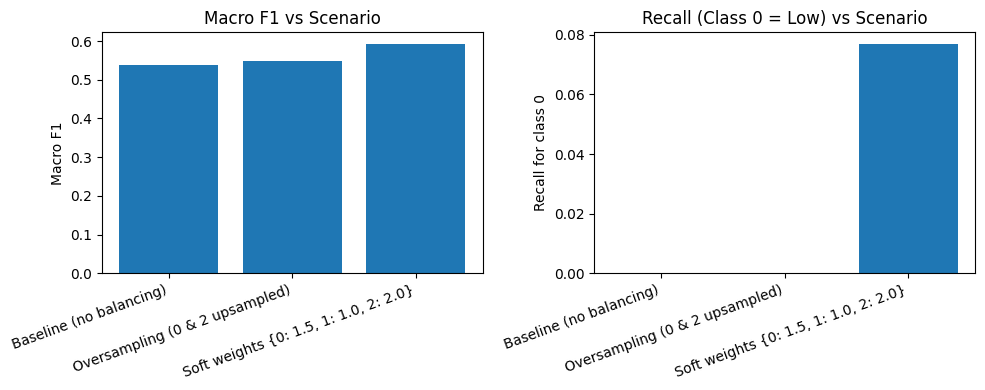

In [ ]:
 
# 3-Class using GPU XGBoost
# Baseline vs Oversampling vs Soft Weights + Metric Comparison + Plots
 
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    recall_score,
    classification_report,
)
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt


#  Map original quality to 3 classes

def map_quality_to_3(q):
    if q <= 4:
        return 0
    elif q <= 6:
        return 1
    else:
        return 2

df_3 = df.copy()
df_3["quality_3"] = df_3["quality"].apply(map_quality_to_3)

X = df_3.drop(["quality", "quality_3"], axis=1)
y = df_3["quality_3"].values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


base_params = {
    "max_depth": 15,
    "min_child_weight": 2,
    "gamma": 0.2849172829132579,
    "subsample": 0.956558810639951,
    "colsample_bytree": 0.8488121153909893,
    "reg_alpha": 0.31746274420813814,
    "reg_lambda": 1.0779428224133318,
    "eta": 0.08703247961037018,
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "num_class": 3,
    "seed": 42,
}


def train_eval_scenario(
    name, Xtr, ytr, sample_weight=None, verbose=False
):
    dtrain = xgb.DMatrix(Xtr, label=ytr, weight=sample_weight)
    dtest  = xgb.DMatrix(X_test_scaled, label=y_test)

    booster = xgb.train(
        params=base_params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dtest, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False,
    )

    y_proba = booster.predict(dtest)
    y_pred = np.argmax(y_proba, axis=1)

    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")
    recall_0 = recall_score(y_test, y_pred, labels=[0], average="macro", zero_division=0)

    if verbose:
        print(f"\n=== {name} ===")
        print("Best iteration:", booster.best_iteration)
        print("Accuracy:", acc)
        print("Balanced accuracy:", bal_acc)
        print("Macro F1:", macro_f1)
        print("Recall class 0 (Low):", recall_0)
        print("\nClassification report:")
        print(classification_report(y_test, y_pred, zero_division=0))

    return {
        "scenario": name,
        "best_iteration": booster.best_iteration,
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "macro_f1": macro_f1,
        "recall_class_0": recall_0,
        "y_pred": y_pred,
    }

results = []

res_baseline = train_eval_scenario(
    "Baseline (no balancing)", X_train_scaled, y_train, sample_weight=None, verbose=True
)
results.append(res_baseline)


# Scenario 2 – Oversampling (RandomOverSampler)

print("\nOversampling with RandomOverSampler...")
ros = RandomOverSampler(
    sampling_strategy={0: 150, 1: np.sum(y_train == 1), 2: 200}, random_state=42
)
X_ros, y_ros = ros.fit_resample(X_train_scaled, y_train)

res_oversample = train_eval_scenario(
    "Oversampling (0 & 2 upsampled)", X_ros, y_ros, sample_weight=None, verbose=True
)
results.append(res_oversample)


#  Scenario 3 – Soft class weights (automatic search)
#    Search a small grid of weights for classes 0 and 2.

print("\nSearching soft class weights...")

weight_grid_0 = [1.5, 2.0, 3.0]   # Low
weight_grid_2 = [1.0, 1.5, 2.0]   # High

best_weight_res = None
best_macro_f1 = -1

for w0 in weight_grid_0:
    for w2 in weight_grid_2:
        weights = {0: w0, 1: 1.0, 2: w2}
        sample_w = np.array([weights[c] for c in y_train])
        label = f"Soft weights (w0={w0}, w2={w2})"
        res = train_eval_scenario(label, X_train_scaled, y_train, sample_weight=sample_w, verbose=False)
        if res["macro_f1"] > best_macro_f1:
            best_macro_f1 = res["macro_f1"]
            best_weight_res = (weights, res)

weights_opt, res_soft = best_weight_res
print("\nBest soft weights found:", weights_opt)
# re-run with verbose output
res_soft_verbose = train_eval_scenario(
    f"Soft weights {weights_opt}", X_train_scaled, y_train,
    sample_weight=np.array([weights_opt[c] for c in y_train]),
    verbose=True
)
results.append(res_soft_verbose)

# -------------------------------------------------
# 9) Metrics table
# -------------------------------------------------
df_results = pd.DataFrame([
    {
        "Scenario": r["scenario"],
        "Best iteration": r["best_iteration"],
        "Accuracy": r["accuracy"],
        "Balanced acc": r["balanced_accuracy"],
        "Macro F1": r["macro_f1"],
        "Recall class 0": r["recall_class_0"],
    }
    for r in results
])

print("\n================ METRIC COMPARISON ================")
print(df_results.to_string(index=False))

# -------------------------------------------------
# 10) Simple plots for dissertation
# -------------------------------------------------
plt.figure(figsize=(10,4))
x = np.arange(len(results))

plt.subplot(1,2,1)
plt.title("Macro F1 vs Scenario")
plt.bar(x, [r["macro_f1"] for r in results])
plt.xticks(x, [r["scenario"] for r in results], rotation=20, ha="right")
plt.ylabel("Macro F1")

plt.subplot(1,2,2)
plt.title("Recall (Class 0 = Low) vs Scenario")
plt.bar(x, [r["recall_class_0"] for r in results])
plt.xticks(x, [r["scenario"] for r in results], rotation=20, ha="right")
plt.ylabel("Recall for class 0")

plt.tight_layout()
plt.show()


In [ ]:

# Adaptive Random Search for 3-class Red Wine (GPU XGBoost)
#  - Uses class weights {0:1.5, 1:1.0, 2:2.0}
#  - Round 1: broad search
#  - Round 2: narrowed search around best

import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report

import random
import math

# -----------------------------
# 1) Map quality to 3 classes
# -----------------------------
def map_quality_to_3(q):
    if q <= 4:
        return 0
    elif q <= 6:
        return 1
    else:
        return 2

df_3 = df.copy()
df_3["quality_3"] = df_3["quality"].apply(map_quality_to_3)

X = df_3.drop(["quality", "quality_3"], axis=1)
y = df_3["quality_3"].values

# -----------------------------
# 2) Train / test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------
# 3) Scaling
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# DMatrix for test (always same)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# -----------------------------
# 4) Class weights (soft)
# -----------------------------
class_weights = {0: 1.5, 1: 1.0, 2: 2.0}
sample_weight = np.array([class_weights[c] for c in y_train])
dtrain_base = xgb.DMatrix(X_train_scaled, label=y_train, weight=sample_weight)

# -----------------------------
# 5) Parameter search space
# -----------------------------
global_space = {
    "max_depth":        (4, 18),      # int
    "min_child_weight": (1.0, 8.0),   # float
    "gamma":            (0.0, 0.6),   # float
    "subsample":        (0.7, 1.0),   # float
    "colsample_bytree": (0.6, 1.0),   # float
    "reg_alpha":        (0.0, 1.0),   # float
    "reg_lambda":       (0.5, 3.0),   # float
    "eta":              (0.02, 0.2),  # float (learning rate)
}

def sample_params(space):
    """Sample one parameter set from the given space dict."""
    params = {}
    for name, (low, high) in space.items():
        if name == "max_depth":
            params[name] = random.randint(int(low), int(high))
        else:
            params[name] = random.uniform(low, high)
    return params

# -----------------------------
# 6) Train + evaluate one config
# -----------------------------
def train_eval(params, dtrain):
    """Train with GPU XGBoost and return metrics + model."""
    xgb_params = {
        "tree_method": "gpu_hist",
        "predictor": "gpu_predictor",
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "num_class": 3,
        "seed": 42,
        **params,
    }

    booster = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dtest, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False,
    )

    y_proba = booster.predict(dtest)
    y_pred  = np.argmax(y_proba, axis=1)

    acc      = accuracy_score(y_test, y_pred)
    bal_acc  = balanced_accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    return {
        "params": params,
        "booster": booster,
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "macro_f1": macro_f1,
    }

# -----------------------------
# 7) Shrink search space around best
# -----------------------------
def shrink_space(best_params, space, shrink_factor=0.5):
    """
    For each numeric param: new range is centered at best value,
    with width = original_width * shrink_factor (clipped to global bounds).
    """
    new_space = {}
    for name, (low, high) in space.items():
        best = best_params[name]
        width = (high - low) * shrink_factor
        new_low  = max(low,  best - width / 2)
        new_high = min(high, best + width / 2)
        if name == "max_depth":
            new_space[name] = (int(round(new_low)), int(round(new_high)))
        else:
            new_space[name] = (float(new_low), float(new_high))
    return new_space

# -----------------------------
# 8) Run one search round
# -----------------------------
def run_round(round_name, n_trials, space):
    print(f"\n=== {round_name}: {n_trials} trials ===")
    best = None

    for i in range(1, n_trials + 1):
        params = sample_params(space)
        res = train_eval(params, dtrain_base)

        # format params nicely
        param_str = ", ".join(
            f"{k}: {round(v,4) if isinstance(v, float) else v}"
            for k, v in params.items()
        )

        # update best
        if (best is None) or (res["macro_f1"] > best["macro_f1"]):
            best = res

        print(
            f"[{i}/{n_trials}] "
            f"macroF1={res['macro_f1']:.4f} "
            f"acc={res['accuracy']:.4f} "
            f"bal_acc={res['balanced_accuracy']:.4f} "
            f"params={{ {param_str} }}"
        )

    print(
        f"\nBest in {round_name}: macroF1={best['macro_f1']:.4f}, "
        f"acc={best['accuracy']:.4f}, bal_acc={best['balanced_accuracy']:.4f}"
    )
    return best


# ===============================================================
# RUN: Round 1 (broad) → shrink → Round 2 (focused)
# ===============================================================
# Round 1: broad exploration
best_round1 = run_round("Round 1 (broad search)", n_trials=40, space=global_space)

# Build narrowed space around the best params from round 1
narrow_space = shrink_space(best_round1["params"], global_space, shrink_factor=0.4)

print("\nNarrowed search space for Round 2:")
for k, (lo, hi) in narrow_space.items():
    print(f"  {k}: [{lo}, {hi}]")

# Round 2: focused search in narrowed region
best_round2 = run_round("Round 2 (focused search)", n_trials=30, space=narrow_space)

final_best = best_round2 if best_round2["macro_f1"] >= best_round1["macro_f1"] else best_round1

print("\n================ FINAL BEST MODEL ================")
print("Best params:")
for k, v in final_best["params"].items():
    print(f"  {k}: {v}")
print(f"\nFinal macro F1:        {final_best['macro_f1']:.4f}")
print(f"Final accuracy:        {final_best['accuracy']:.4f}")
print(f"Final balanced acc:    {final_best['balanced_accuracy']:.4f}")

print("\nClassification report for FINAL BEST:")
y_proba_final = final_best["booster"].predict(dtest)
y_pred_final  = np.argmax(y_proba_final, axis=1)
print(classification_report(y_test, y_pred_final, zero_division=0))



=== Round 1 (broad search): 40 trials ===
[1/40] macroF1=0.6352 acc=0.8781 bal_acc=0.6501 params={ max_depth: 4, min_child_weight: 7.2434, gamma: 0.2449, subsample: 0.886, colsample_bytree: 0.933, reg_alpha: 0.4246, reg_lambda: 2.811, eta: 0.1727 }
[2/40] macroF1=0.5878 acc=0.8719 bal_acc=0.5973 params={ max_depth: 6, min_child_weight: 6.7766, gamma: 0.3126, subsample: 0.9381, colsample_bytree: 0.7157, reg_alpha: 0.0675, reg_lambda: 2.6212, eta: 0.1397 }
[3/40] macroF1=0.5826 acc=0.8688 bal_acc=0.5895 params={ max_depth: 6, min_child_weight: 5.7895, gamma: 0.44, subsample: 0.7969, colsample_bytree: 0.6121, reg_alpha: 0.8902, reg_lambda: 2.473, eta: 0.1917 }
[4/40] macroF1=0.5829 acc=0.8688 bal_acc=0.5895 params={ max_depth: 7, min_child_weight: 3.5895, gamma: 0.4755, subsample: 0.9718, colsample_bytree: 0.7007, reg_alpha: 0.7732, reg_lambda: 2.983, eta: 0.1295 }
[5/40] macroF1=0.5993 acc=0.8812 bal_acc=0.6076 params={ max_depth: 8, min_child_weight: 4.6975, gamma: 0.3887, subsample: 0

In [ ]:
# =======================================================
# 5-Fold Cross-Validation for Final Best Model (GPU)
# =======================================================
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report

# -------------------------------------------------------
# 1) Map to 3 classes
# -------------------------------------------------------
def map_quality_to_3(q):
    if q <= 4: return 0
    elif q <= 6: return 1
    return 2

df_3 = df.copy()
df_3["quality_3"] = df_3["quality"].apply(map_quality_to_3)

X = df_3.drop(["quality", "quality_3"], axis=1).values
y = df_3["quality_3"].values

# -------------------------------------------------------
# 2) Class weights (soft)
# -------------------------------------------------------
class_weights = {0: 1.5, 1: 1.0, 2: 2.0}

# -------------------------------------------------------
# 3) Final best params from your adaptive search
# -------------------------------------------------------
best_params = {
    "max_depth": 14,
    "min_child_weight": 5.551290284884134,
    "gamma": 0.06606580110066626,
    "subsample": 0.8443674690171549,
    "colsample_bytree": 0.8330082058878638,
    "reg_alpha": 0.10906839337503679,
    "reg_lambda": 2.9954309029070125,
    "eta": 0.14672967427975434,
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "num_class": 3,
    "seed": 42,
}

# -------------------------------------------------------
# 4) Prepare CV
# -------------------------------------------------------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = []
macro_f1_scores = []
bal_acc_scores = []

fold = 1

# -------------------------------------------------------
# 5) Run 5-fold CV
# -------------------------------------------------------
for train_index, val_index in kf.split(X, y):
    print(f"\n========== Fold {fold} ==========")

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Apply weights
    sample_weight = np.array([class_weights[c] for c in y_train])

    dtrain = xgb.DMatrix(X_train_scaled, label=y_train, weight=sample_weight)
    dval   = xgb.DMatrix(X_val_scaled, label=y_val)

    booster = xgb.train(
        params=best_params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dval, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False,
    )

    # Predictions
    y_proba = booster.predict(dval)
    y_pred = np.argmax(y_proba, axis=1)

    acc = accuracy_score(y_val, y_pred)
    bal_acc = balanced_accuracy_score(y_val, y_pred)
    macro_f1 = f1_score(y_val, y_pred, average="macro")

    print(f"Accuracy:       {acc:.4f}")
    print(f"Balanced Acc:   {bal_acc:.4f}")
    print(f"Macro F1:       {macro_f1:.4f}")

    acc_scores.append(acc)
    bal_acc_scores.append(bal_acc)
    macro_f1_scores.append(macro_f1)

    fold += 1

# -------------------------------------------------------
# 6) Final averages
# -------------------------------------------------------
print("\n==================== FINAL CV RESULTS (5-fold) ====================")
print(f"Accuracy:       mean={np.mean(acc_scores):.4f}, std={np.std(acc_scores):.4f}")
print(f"Balanced Acc:   mean={np.mean(bal_acc_scores):.4f}, std={np.std(bal_acc_scores):.4f}")
print(f"Macro F1:       mean={np.mean(macro_f1_scores):.4f}, std={np.std(macro_f1_scores):.4f}")



========== Fold 1 ==========
Accuracy:       0.8469
Balanced Acc:   0.4937
Macro F1:       0.4937

========== Fold 2 ==========
Accuracy:       0.8719
Balanced Acc:   0.5210
Macro F1:       0.5278

========== Fold 3 ==========
Accuracy:       0.8562
Balanced Acc:   0.5017
Macro F1:       0.5053

========== Fold 4 ==========
Accuracy:       0.8781
Balanced Acc:   0.6112
Macro F1:       0.6267

========== Fold 5 ==========
Accuracy:       0.8840
Balanced Acc:   0.5542
Macro F1:       0.5859

==================== FINAL CV RESULTS (5-fold) ====================
Accuracy:       mean=0.8674, std=0.0138
Balanced Acc:   mean=0.5364, std=0.0429
Macro F1:       mean=0.5479, std=0.0506


In [ ]:
# =======================================================
# 5-Fold CV — ORDINAL REGRESSION VERSION (XGBoost, GPU)
# =======================================================
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report

# -------------------------------------------------------
# 1) Map to 3 ordinal classes
# -------------------------------------------------------
def map_quality_to_3(q):
    if q <= 4: return 0   # Low
    elif q <= 6: return 1 # Medium
    return 2              # High

df_3 = df.copy()
df_3["quality_3"] = df_3["quality"].apply(map_quality_to_3)

# True continuous regression target = original wine quality (3–8)
y_reg = df_3["quality"].values          # ← regression target
y_cls = df_3["quality_3"].values        # ← classification target

X = df_3.drop(["quality", "quality_3"], axis=1).values

# -------------------------------------------------------
# 2) Define thresholds to convert regression → 3 classes
# -------------------------------------------------------
def reg_to_class(y_hat):
    """
    Convert predicted continuous score (3 to 8)
    into ordinal classes 0, 1, 2
    """
    # Tunable thresholds:
    if y_hat <= 4.5:
        return 0
    elif y_hat <= 6.5:
        return 1
    else:
        return 2

vec_reg_to_class = np.vectorize(reg_to_class)

# -------------------------------------------------------
# 3) XGBoost regression params (ordinal)
# -------------------------------------------------------
ordinal_params = {
    "objective": "reg:squarederror",
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "max_depth": 14,
    "min_child_weight": 5.55129028,
    "gamma": 0.06606580,
    "subsample": 0.84436747,
    "colsample_bytree": 0.83300820,
    "reg_alpha": 0.10906839,
    "reg_lambda": 2.99543090,
    "eta": 0.14672967,
    "seed": 42,
}

# -------------------------------------------------------
# 4) Prepare CV
# -------------------------------------------------------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = []
macro_f1_scores = []
bal_acc_scores = []

fold = 1

# -------------------------------------------------------
# 5) Run 5-fold Ordinal Regression CV
# -------------------------------------------------------
for train_index, val_index in kf.split(X, y_cls):

    print(f"\n========== Fold {fold} ==========")

    X_train, X_val = X[train_index], X[val_index]
    y_train_reg, y_val_reg = y_reg[train_index], y_reg[val_index]
    y_train_cls, y_val_cls = y_cls[train_index], y_cls[val_index]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)

    # DMatrix
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train_reg)
    dval   = xgb.DMatrix(X_val_scaled,   label=y_val_reg)

    # Train regressor
    booster = xgb.train(
        params=ordinal_params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dval, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False,
    )

    # Predict continuous values
    y_pred_reg = booster.predict(dval)

    # Convert regression output → ordinal classes
    y_pred_cls = vec_reg_to_class(y_pred_reg)

    # Metrics
    acc = accuracy_score(y_val_cls, y_pred_cls)
    bal_acc = balanced_accuracy_score(y_val_cls, y_pred_cls)
    macro_f1 = f1_score(y_val_cls, y_pred_cls, average="macro")

    print(f"Accuracy:       {acc:.4f}")
    print(f"Balanced Acc:   {bal_acc:.4f}")
    print(f"Macro F1:       {macro_f1:.4f}")

    acc_scores.append(acc)
    bal_acc_scores.append(bal_acc)
    macro_f1_scores.append(macro_f1)

    fold += 1

# -------------------------------------------------------
# 6) Final averages
# -------------------------------------------------------
print("\n==================== FINAL ORDINAL CV RESULTS (5-fold) ====================")
print(f"Accuracy:       mean={np.mean(acc_scores):.4f}, std={np.std(acc_scores):.4f}")
print(f"Balanced Acc:   mean={np.mean(bal_acc_scores):.4f}, std={np.std(bal_acc_scores):.4f}")
print(f"Macro F1:       mean={np.mean(macro_f1_scores):.4f}, std={np.std(macro_f1_scores):.4f}")



========== Fold 1 ==========
Accuracy:       0.8562
Balanced Acc:   0.5114
Macro F1:       0.5410

========== Fold 2 ==========
Accuracy:       0.8688
Balanced Acc:   0.5003
Macro F1:       0.5209

========== Fold 3 ==========
Accuracy:       0.8594
Balanced Acc:   0.5095
Macro F1:       0.5091

========== Fold 4 ==========
Accuracy:       0.8750
Balanced Acc:   0.5531
Macro F1:       0.5760

========== Fold 5 ==========
Accuracy:       0.8840
Balanced Acc:   0.5681
Macro F1:       0.6225

==================== FINAL ORDINAL CV RESULTS (5-fold) ====================
Accuracy:       mean=0.8687, std=0.0102
Balanced Acc:   mean=0.5285, std=0.0270
Macro F1:       mean=0.5539, std=0.0411


In [ ]:

# 5-Fold CV — ORDINAL XGBOOST (ALL-THRESHOLD / CORAL)
#  - Uses 2 binary GPU XGBoost models for 3 ordered classes

import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score


# Map to 3 ordered classes (same as before)

def map_quality_to_3(q):
    if q <= 4: return 0   # Low
    elif q <= 6: return 1 # Medium
    return 2              # High

df_3 = df.copy()
df_3["quality_3"] = df_3["quality"].apply(map_quality_to_3)

X = df_3.drop(["quality", "quality_3"], axis=1).values
y = df_3["quality_3"].values  # 0,1,2 (ordered)


# Class weights (same mapping as before)
#    (used as sample_weight for both binary tasks)

class_weights = {0: 1.5, 1: 1.0, 2: 2.0}


# Ordinal XGBoost params (binary:logistic)
#    based on your tuned params

xgb_ord_params = {
    "max_depth": 14,
    "min_child_weight": 5.551290284884134,
    "gamma": 0.06606580110066626,
    "subsample": 0.8443674690171549,
    "colsample_bytree": 0.8330082058878638,
    "reg_alpha": 0.10906839337503679,
    "reg_lambda": 2.9954309029070125,
    "learning_rate": 0.14672967427975434,  # eta
    "n_estimators": 200,
    "objective": "binary:logistic",
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "eval_metric": "logloss",
    "random_state": 42,
    "use_label_encoder": False,
}


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = []
macro_f1_scores = []
bal_acc_scores = []

fold = 1


for train_index, val_index in kf.split(X, y):
    print(f"\n========== Fold {fold} ==========")

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)

    
    y_train_t1 = (y_train > 0).astype(int)
    y_train_t2 = (y_train > 1).astype(int)
    y_val_t1   = (y_val   > 0).astype(int)
    y_val_t2   = (y_val   > 1).astype(int)

    # Sample weights from original 3-class labels
    w_train = np.array([class_weights[c] for c in y_train])

    #  Train two binary XGBoost models, ordinal thresholds 
    model_t1 = XGBClassifier(**xgb_ord_params)
    model_t2 = XGBClassifier(**xgb_ord_params)

    model_t1.fit(X_train_scaled, y_train_t1, sample_weight=w_train, eval_set=[(X_val_scaled, y_val_t1)], verbose=False)
    model_t2.fit(X_train_scaled, y_train_t2, sample_weight=w_train, eval_set=[(X_val_scaled, y_val_t2)], verbose=False)

    # Predict threshold probabilities 
    p1 = model_t1.predict_proba(X_val_scaled)[:, 1]  # P(y > 0)
    p2 = model_t2.predict_proba(X_val_scaled)[:, 1]  # P(y > 1)

    # Ensure monotonicity: P(y>1) <= P(y>0)
    p2 = np.minimum(p1, p2)

    # Convert to class probabilities (all-threshold) 
    p0 = 1.0 - p1
    p2_final = p2
    p1_final = p1 - p2  # remaining mass between thresholds

    probs = np.stack([p0, p1_final, p2_final], axis=1)

    # Predicted class = argmax of ordinal probabilities
    y_pred = np.argmax(probs, axis=1)

    #  Metrics 
    acc      = accuracy_score(y_val, y_pred)
    bal_acc  = balanced_accuracy_score(y_val, y_pred)
    macro_f1 = f1_score(y_val, y_pred, average="macro")

    print(f"Accuracy:       {acc:.4f}")
    print(f"Balanced Acc:   {bal_acc:.4f}")
    print(f"Macro F1:       {macro_f1:.4f}")

    acc_scores.append(acc)
    bal_acc_scores.append(bal_acc)
    macro_f1_scores.append(macro_f1)

    fold += 1


# Final averages

print("\n==================== FINAL ORDINAL-XGB RESULTS (5-fold) ====================")
print(f"Accuracy:       mean={np.mean(acc_scores):.4f}, std={np.std(acc_scores):.4f}")
print(f"Balanced Acc:   mean={np.mean(bal_acc_scores):.4f}, std={np.std(bal_acc_scores):.4f}")
print(f"Macro F1:       mean={np.mean(macro_f1_scores):.4f}, std={np.std(macro_f1_scores):.4f}")



========== Fold 1 ==========
Accuracy:       0.8500
Balanced Acc:   0.5278
Macro F1:       0.5442

========== Fold 2 ==========
Accuracy:       0.8625
Balanced Acc:   0.5107
Macro F1:       0.5201

========== Fold 3 ==========
Accuracy:       0.8719
Balanced Acc:   0.5584
Macro F1:       0.5746

========== Fold 4 ==========
Accuracy:       0.8688
Balanced Acc:   0.5895
Macro F1:       0.5829

========== Fold 5 ==========
Accuracy:       0.8777
Balanced Acc:   0.5845
Macro F1:       0.6153

==================== FINAL ORDINAL-XGB RESULTS (5-fold) ====================
Accuracy:       mean=0.8662, std=0.0095
Balanced Acc:   mean=0.5542, std=0.0309
Macro F1:       mean=0.5674, std=0.0327


In [ ]:

# Adaptive Random Search for 3-class Red Wine (GPU XGBoost + PCA)


import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report

import random
import math

def map_quality_to_3(q):
    if q <= 4:
        return 0
    elif q <= 6:
        return 1
    else:
        return 2

df_3 = df.copy()
df_3["quality_3"] = df_3["quality"].apply(map_quality_to_3)

X = df_3.drop(["quality", "quality_3"], axis=1)
y = df_3["quality_3"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


# PCA 


pca = PCA(n_components=0.95, random_state=42)


# pca = PCA(n_components=6, random_state=42)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print(f"PCA: original dims = {X_train_scaled.shape[1]}, "
      f"reduced dims = {X_train_pca.shape[1]}")

# DMatrix for test (always same)
dtest = xgb.DMatrix(X_test_pca, label=y_test)




class_weights = {0: 1.5, 1: 1.0, 2: 2.0}
sample_weight = np.array([class_weights[c] for c in y_train])
dtrain_base = xgb.DMatrix(X_train_pca, label=y_train, weight=sample_weight)




global_space = {
    "max_depth":        (4, 18),      # int
    "min_child_weight": (1.0, 8.0),   # float
    "gamma":            (0.0, 0.6),   # float
    "subsample":        (0.7, 1.0),   # float
    "colsample_bytree": (0.6, 1.0),   # float
    "reg_alpha":        (0.0, 1.0),   # float
    "reg_lambda":       (0.5, 3.0),   # float
    "eta":              (0.02, 0.2),  # float (learning rate)
}

def sample_params(space):
    """Sample one parameter set from the given space dict."""
    params = {}
    for name, (low, high) in space.items():
        if name == "max_depth":
            params[name] = random.randint(int(low), int(high))
        else:
            params[name] = random.uniform(low, high)
    return params


# Train + evaluate one config

def train_eval(params, dtrain):
    """Train with GPU XGBoost and return metrics + model."""
    xgb_params = {
        "tree_method": "gpu_hist",
        "predictor": "gpu_predictor",
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "num_class": 3,
        "seed": 42,
        **params,
    }

    booster = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dtest, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False,
    )

    y_proba = booster.predict(dtest)
    y_pred  = np.argmax(y_proba, axis=1)

    acc      = accuracy_score(y_test, y_pred)
    bal_acc  = balanced_accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    return {
        "params": params,
        "booster": booster,
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "macro_f1": macro_f1,
    }


#  Shrink search space around best

def shrink_space(best_params, space, shrink_factor=0.5):
    """
    For each numeric param: new range is centered at best value,
    with width = original_width * shrink_factor (clipped to global bounds).
    """
    new_space = {}
    for name, (low, high) in space.items():
        best = best_params[name]
        width = (high - low) * shrink_factor
        new_low  = max(low,  best - width / 2)
        new_high = min(high, best + width / 2)
        if name == "max_depth":
            new_space[name] = (int(round(new_low)), int(round(new_high)))
        else:
            new_space[name] = (float(new_low), float(new_high))
    return new_space


#  Run one search round

def run_round(round_name, n_trials, space):
    print(f"\n=== {round_name}: {n_trials} trials ===")
    best = None

    for i in range(1, n_trials + 1):
        params = sample_params(space)
        res = train_eval(params, dtrain_base)

        # format params nicely
        param_str = ", ".join(
            f"{k}: {round(v,4) if isinstance(v, float) else v}"
            for k, v in params.items()
        )

        # update best
        if (best is None) or (res["macro_f1"] > best["macro_f1"]):
            best = res

        print(
            f"[{i}/{n_trials}] "
            f"macroF1={res['macro_f1']:.4f} "
            f"acc={res['accuracy']:.4f} "
            f"bal_acc={res['balanced_accuracy']:.4f} "
            f"params={{ {param_str} }}"
        )

    print(
        f"\nBest in {round_name}: macroF1={best['macro_f1']:.4f}, "
        f"acc={best['accuracy']:.4f}, bal_acc={best['balanced_accuracy']:.4f}"
    )
    return best



# RUN: Round 1 (broad) >> shrink >> Round 2 (focused)

# Round 1: broad exploration
best_round1 = run_round("Round 1 (broad search)", n_trials=40, space=global_space)

# Build narrowed space around the best params from round 1
narrow_space = shrink_space(best_round1["params"], global_space, shrink_factor=0.4)

print("\nNarrowed search space for Round 2:")
for k, (lo, hi) in narrow_space.items():
    print(f"  {k}: [{lo}, {hi}]")

# Round 2: focused search in narrowed region
best_round2 = run_round("Round 2 (focused search)", n_trials=30, space=narrow_space)

final_best = best_round2 if best_round2["macro_f1"] >= best_round1["macro_f1"] else best_round1

print("\n================ FINAL BEST MODEL ================")
print("Best params:")
for k, v in final_best["params"].items():
    print(f"  {k}: {v}")
print(f"\nFinal macro F1:        {final_best['macro_f1']:.4f}")
print(f"Final accuracy:        {final_best['accuracy']:.4f}")
print(f"Final balanced acc:    {final_best['balanced_accuracy']:.4f}")

print("\nClassification report for FINAL BEST:")
y_proba_final = final_best["booster"].predict(dtest)
y_pred_final  = np.argmax(y_proba_final, axis=1)
print(classification_report(y_test, y_pred_final, zero_division=0))


PCA: original dims = 11, reduced dims = 9

=== Round 1 (broad search): 40 trials ===
[1/40] macroF1=0.5050 acc=0.8438 bal_acc=0.5226 params={ max_depth: 11, min_child_weight: 7.5633, gamma: 0.4194, subsample: 0.9615, colsample_bytree: 0.9974, reg_alpha: 0.8372, reg_lambda: 1.7878, eta: 0.0279 }
[2/40] macroF1=0.5165 acc=0.8531 bal_acc=0.5329 params={ max_depth: 4, min_child_weight: 3.4537, gamma: 0.0678, subsample: 0.927, colsample_bytree: 0.8531, reg_alpha: 0.7263, reg_lambda: 1.1318, eta: 0.1765 }
[3/40] macroF1=0.5226 acc=0.8594 bal_acc=0.5354 params={ max_depth: 18, min_child_weight: 5.4372, gamma: 0.0629, subsample: 0.7331, colsample_bytree: 0.9514, reg_alpha: 0.7287, reg_lambda: 1.3176, eta: 0.0354 }
[4/40] macroF1=0.5258 acc=0.8625 bal_acc=0.5367 params={ max_depth: 13, min_child_weight: 5.6155, gamma: 0.0545, subsample: 0.7405, colsample_bytree: 0.7844, reg_alpha: 0.8124, reg_lambda: 0.841, eta: 0.0479 }
[5/40] macroF1=0.5165 acc=0.8531 bal_acc=0.5329 params={ max_depth: 11, mi

In [ ]:
# ===============================================================
# Adaptive Random Search for 3-class Red Wine (GPU XGBoost)
#  - Uses class weights {0:1.5, 1:1.0, 2:2.0}
#  - Round 1: broad search
#  - Round 2: narrowed search around best

import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report

import random
import math

def map_quality_to_3(q):
    if q <= 4:
        return 0
    elif q <= 6:
        return 1
    else:
        return 2

df_3 = df.copy()
df_3["quality_3"] = df_3["quality"].apply(map_quality_to_3)

X = df_3.drop(["quality", "quality_3"], axis=1)
y = df_3["quality_3"].values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


dtest = xgb.DMatrix(X_test_scaled, label=y_test)


class_weights = {0: 1.5, 1: 1.0, 2: 2.0}
sample_weight = np.array([class_weights[c] for c in y_train])
dtrain_base = xgb.DMatrix(X_train_scaled, label=y_train, weight=sample_weight)


global_space = {
    "max_depth":        (4, 18),      # int
    "min_child_weight": (1.0, 8.0),   # float
    "gamma":            (0.0, 0.6),   # float
    "subsample":        (0.7, 1.0),   # float
    "colsample_bytree": (0.6, 1.0),   # float
    "reg_alpha":        (0.0, 1.0),   # float
    "reg_lambda":       (0.5, 3.0),   # float
    "eta":              (0.02, 0.2),  # float (learning rate)
}

def sample_params(space):
    """Sample one parameter set from the given space dict."""
    params = {}
    for name, (low, high) in space.items():
        if name == "max_depth":
            params[name] = random.randint(int(low), int(high))
        else:
            params[name] = random.uniform(low, high)
    return params


def train_eval(params, dtrain):
    """Train with GPU XGBoost and return metrics + model."""
    xgb_params = {
        "tree_method": "gpu_hist",
        "predictor": "gpu_predictor",
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "num_class": 3,
        "seed": 42,
        **params,
    }

    booster = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dtest, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False,
    )

    y_proba = booster.predict(dtest)
    y_pred  = np.argmax(y_proba, axis=1)

    acc      = accuracy_score(y_test, y_pred)
    bal_acc  = balanced_accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    return {
        "params": params,
        "booster": booster,
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "macro_f1": macro_f1,
    }


# Shrink search space around best

def shrink_space(best_params, space, shrink_factor=0.5):
    """
    For each numeric param: new range is centered at best value,
    with width = original_width * shrink_factor (clipped to global bounds).
    """
    new_space = {}
    for name, (low, high) in space.items():
        best = best_params[name]
        width = (high - low) * shrink_factor
        new_low  = max(low,  best - width / 2)
        new_high = min(high, best + width / 2)
        if name == "max_depth":
            new_space[name] = (int(round(new_low)), int(round(new_high)))
        else:
            new_space[name] = (float(new_low), float(new_high))
    return new_space


# 8) Run one search round

def run_round(round_name, n_trials, space):
    print(f"\n=== {round_name}: {n_trials} trials ===")
    best = None

    for i in range(1, n_trials + 1):
        params = sample_params(space)
        res = train_eval(params, dtrain_base)

        # format params nicely
        param_str = ", ".join(
            f"{k}: {round(v,4) if isinstance(v, float) else v}"
            for k, v in params.items()
        )

        # update best
        if (best is None) or (res["macro_f1"] > best["macro_f1"]):
            best = res

        print(
            f"[{i}/{n_trials}] "
            f"macroF1={res['macro_f1']:.4f} "
            f"acc={res['accuracy']:.4f} "
            f"bal_acc={res['balanced_accuracy']:.4f} "
            f"params={{ {param_str} }}"
        )

    print(
        f"\nBest in {round_name}: macroF1={best['macro_f1']:.4f}, "
        f"acc={best['accuracy']:.4f}, bal_acc={best['balanced_accuracy']:.4f}"
    )
    return best



# RUN: Round 1 (broad) then shrink in Round 2 (focused)

# Round 1: broad exploration
best_round1 = run_round("Round 1 (broad search)", n_trials=100, space=global_space)

# Build narrowed space around the best params from round 1
narrow_space = shrink_space(best_round1["params"], global_space, shrink_factor=0.4)

print("\nNarrowed search space for Round 2:")
for k, (lo, hi) in narrow_space.items():
    print(f"  {k}: [{lo}, {hi}]")

# Round 2: focused search in narrowed region
best_round2 = run_round("Round 2 (focused search)", n_trials=100, space=narrow_space)

final_best = best_round2 if best_round2["macro_f1"] >= best_round1["macro_f1"] else best_round1

print("\n================ FINAL BEST MODEL ================")
print("Best params:")
for k, v in final_best["params"].items():
    print(f"  {k}: {v}")
print(f"\nFinal macro F1:        {final_best['macro_f1']:.4f}")
print(f"Final accuracy:        {final_best['accuracy']:.4f}")
print(f"Final balanced acc:    {final_best['balanced_accuracy']:.4f}")

print("\nClassification report for FINAL BEST:")
y_proba_final = final_best["booster"].predict(dtest)
y_pred_final  = np.argmax(y_proba_final, axis=1)
print(classification_report(y_test, y_pred_final, zero_division=0))



=== Round 1 (broad search): 100 trials ===
[1/100] macroF1=0.5846 acc=0.8688 bal_acc=0.5960 params={ max_depth: 18, min_child_weight: 6.4944, gamma: 0.1699, subsample: 0.7423, colsample_bytree: 0.7473, reg_alpha: 0.9127, reg_lambda: 2.5015, eta: 0.111 }
[2/100] macroF1=0.5858 acc=0.8719 bal_acc=0.5908 params={ max_depth: 12, min_child_weight: 2.0362, gamma: 0.0837, subsample: 0.7018, colsample_bytree: 0.9204, reg_alpha: 0.9111, reg_lambda: 1.3544, eta: 0.069 }
[3/100] macroF1=0.5411 acc=0.8625 bal_acc=0.5756 params={ max_depth: 17, min_child_weight: 2.9905, gamma: 0.4845, subsample: 0.9898, colsample_bytree: 0.7599, reg_alpha: 0.7039, reg_lambda: 0.8392, eta: 0.0555 }
[4/100] macroF1=0.6010 acc=0.8781 bal_acc=0.6258 params={ max_depth: 14, min_child_weight: 7.6804, gamma: 0.5076, subsample: 0.9603, colsample_bytree: 0.9191, reg_alpha: 0.2061, reg_lambda: 2.0304, eta: 0.1007 }
[5/100] macroF1=0.5896 acc=0.8719 bal_acc=0.6038 params={ max_depth: 6, min_child_weight: 2.4819, gamma: 0.492

<span style="color:green; font-weight:bold;">
 XGBOOST , adaptive random search 3 class , using class wights , 27% improvement from baseline 
</span>


<span style="color:orange; font-weight:bold;">
Best accuracy ever achieved 
</span>


this result made XGBoost ahead of TaBNet in classification accuracy 

In [ ]:
# ===============================================================
# Adaptive Random Search for 3-class Red Wine (GPU XGBoost)
#  - Uses class weights {0:1.5, 1:1.0, 2:2.0}
#  - Round 1: broad search
#  - Round 2: narrowed search around best

import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report

import random
import math


def map_quality_to_3(q):
    if q <= 4:
        return 0
    elif q <= 6:
        return 1
    else:
        return 2

df_3 = df.copy()
df_3["quality_3"] = df_3["quality"].apply(map_quality_to_3)

X = df_3.drop(["quality", "quality_3"], axis=1)
y = df_3["quality_3"].values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# DMatrix for test (always same)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)


class_weights = {0: 1.5, 1: 1.0, 2: 2.0}
sample_weight = np.array([class_weights[c] for c in y_train])
dtrain_base = xgb.DMatrix(X_train_scaled, label=y_train, weight=sample_weight)


global_space = {
    "max_depth":        (4, 18),      # int
    "min_child_weight": (1.0, 8.0),   # float
    "gamma":            (0.0, 0.6),   # float
    "subsample":        (0.7, 1.0),   # float
    "colsample_bytree": (0.6, 1.0),   # float
    "reg_alpha":        (0.0, 1.0),   # float
    "reg_lambda":       (0.5, 3.0),   # float
    "eta":              (0.02, 0.2),  # float (learning rate)
}

def sample_params(space):
    """Sample one parameter set from the given space dict."""
    params = {}
    for name, (low, high) in space.items():
        if name == "max_depth":
            params[name] = random.randint(int(low), int(high))
        else:
            params[name] = random.uniform(low, high)
    return params


def train_eval(params, dtrain):
    """Train with GPU XGBoost and return metrics + model."""
    xgb_params = {
        "tree_method": "gpu_hist",
        "predictor": "gpu_predictor",
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "num_class": 3,
        "seed": 42,
        **params,
    }

    booster = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dtest, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False,
    )

    y_proba = booster.predict(dtest)
    y_pred  = np.argmax(y_proba, axis=1)

    acc      = accuracy_score(y_test, y_pred)
    bal_acc  = balanced_accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    return {
        "params": params,
        "booster": booster,
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "macro_f1": macro_f1,
    }


def shrink_space(best_params, space, shrink_factor=0.5):
    """
    For each numeric param: new range is centered at best value,
    with width = original_width * shrink_factor (clipped to global bounds).
    """
    new_space = {}
    for name, (low, high) in space.items():
        best = best_params[name]
        width = (high - low) * shrink_factor
        new_low  = max(low,  best - width / 2)
        new_high = min(high, best + width / 2)
        if name == "max_depth":
            new_space[name] = (int(round(new_low)), int(round(new_high)))
        else:
            new_space[name] = (float(new_low), float(new_high))
    return new_space


#  Run one search round

def run_round(round_name, n_trials, space):
    print(f"\n=== {round_name}: {n_trials} trials ===")
    best = None

    for i in range(1, n_trials + 1):
        params = sample_params(space)
        res = train_eval(params, dtrain_base)

        # format params nicely
        param_str = ", ".join(
            f"{k}: {round(v,4) if isinstance(v, float) else v}"
            for k, v in params.items()
        )

        # update best
        if (best is None) or (res["macro_f1"] > best["macro_f1"]):
            best = res

        print(
            f"[{i}/{n_trials}] "
            f"macroF1={res['macro_f1']:.4f} "
            f"acc={res['accuracy']:.4f} "
            f"bal_acc={res['balanced_accuracy']:.4f} "
            f"params={{ {param_str} }}"
        )

    print(
        f"\nBest in {round_name}: macroF1={best['macro_f1']:.4f}, "
        f"acc={best['accuracy']:.4f}, bal_acc={best['balanced_accuracy']:.4f}"
    )
    return best



# RUN: Round 1 (broad) to shrink  Round 2 (focused)

# Round 1: broad exploration
best_round1 = run_round("Round 1 (broad search)", n_trials=200, space=global_space)

# Build narrowed space around the best params from round 1
narrow_space = shrink_space(best_round1["params"], global_space, shrink_factor=0.4)

print("\nNarrowed search space for Round 2:")
for k, (lo, hi) in narrow_space.items():
    print(f"  {k}: [{lo}, {hi}]")

# Round 2: focused search in narrowed region
best_round2 = run_round("Round 2 (focused search)", n_trials=200, space=narrow_space)

final_best = best_round2 if best_round2["macro_f1"] >= best_round1["macro_f1"] else best_round1

print("\n================ FINAL BEST MODEL ================")
print("Best params:")
for k, v in final_best["params"].items():
    print(f"  {k}: {v}")
print(f"\nFinal macro F1:        {final_best['macro_f1']:.4f}")
print(f"Final accuracy:        {final_best['accuracy']:.4f}")
print(f"Final balanced acc:    {final_best['balanced_accuracy']:.4f}")

print("\nClassification report for FINAL BEST:")
y_proba_final = final_best["booster"].predict(dtest)
y_pred_final  = np.argmax(y_proba_final, axis=1)
print(classification_report(y_test, y_pred_final, zero_division=0))



=== Round 1 (broad search): 200 trials ===
[1/200] macroF1=0.5960 acc=0.8781 bal_acc=0.6063 params={ max_depth: 17, min_child_weight: 3.5268, gamma: 0.115, subsample: 0.7554, colsample_bytree: 0.7409, reg_alpha: 0.9602, reg_lambda: 1.4621, eta: 0.1097 }
[2/200] macroF1=0.6400 acc=0.8844 bal_acc=0.6462 params={ max_depth: 7, min_child_weight: 3.8545, gamma: 0.5031, subsample: 0.7047, colsample_bytree: 0.9297, reg_alpha: 0.3069, reg_lambda: 2.3634, eta: 0.1159 }
[3/200] macroF1=0.5838 acc=0.8719 bal_acc=0.5843 params={ max_depth: 9, min_child_weight: 2.1234, gamma: 0.189, subsample: 0.8118, colsample_bytree: 0.9684, reg_alpha: 0.3502, reg_lambda: 2.283, eta: 0.1337 }
[4/200] macroF1=0.5976 acc=0.8812 bal_acc=0.6011 params={ max_depth: 15, min_child_weight: 7.2713, gamma: 0.036, subsample: 0.8193, colsample_bytree: 0.6207, reg_alpha: 0.2926, reg_lambda: 1.1428, eta: 0.0716 }
[5/200] macroF1=0.6316 acc=0.8812 bal_acc=0.6255 params={ max_depth: 7, min_child_weight: 5.7784, gamma: 0.0745, s

<span style="color:red; font-weight:bold;">
few other test-cases ran, no breakthroughs acirved 
</span>
most were about trying other class weights , different search spaces and k-folds 

In [ ]:

# Adaptive Random Search for 3-class Red Wine (GPU XGBoost)

import time
import math
import random
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report


N_TRIALS_ROUND1 = 500
N_TRIALS_ROUND2 = 500
P_GLOBAL_ROUND2 = 0.10   # 10% random global jumps

random.seed(42)
np.random.seed(42)

def format_hms(sec):
    h = int(sec // 3600)
    m = int((sec % 3600) // 60)
    s = int(sec % 60)
    return f"{h:d}:{m:02d}:{s:02d}"


def map_quality_to_3(q):
    if q <= 4: return 0
    elif q <= 6: return 1
    return 2

df_3 = df.copy()
df_3["quality_3"] = df_3["quality"].apply(map_quality_to_3)
X = df_3.drop(["quality", "quality_3"], axis=1)
y = df_3["quality_3"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

dtest = xgb.DMatrix(X_test_scaled, label=y_test)
class_weights = {0:1.5, 1:1.0, 2:2.0}
sample_weight = np.array([class_weights[c] for c in y_train])
dtrain_base = xgb.DMatrix(X_train_scaled, label=y_train, weight=sample_weight)


global_space = {
    "max_depth":        ("int",         3,     18),
    "min_child_weight": ("log_uniform", 0.3,   20.0),
    "gamma":            ("log_uniform", 1e-4,  5.0),
    "subsample":        ("uniform",     0.5,   1.0),
    "colsample_bytree": ("uniform",     0.5,   1.0),
    "reg_alpha":        ("log_uniform", 1e-4,  10.0),
    "reg_lambda":       ("log_uniform", 1e-2,  20.0),
    "eta":              ("log_uniform", 0.01,  0.3),
}

def sample_log_uniform(a, b):
    return math.exp(random.uniform(math.log(a), math.log(b)))

def sample_params(space):
    params = {}
    for name, (dist, low, high) in space.items():
        if dist == "int":
            params[name] = random.randint(int(low), int(high))
        elif dist == "uniform":
            params[name] = random.uniform(low, high)
        elif dist == "log_uniform":
            params[name] = sample_log_uniform(low, high)
    return params


def train_eval(params, dtrain):
    xgb_params = {
        "tree_method": "gpu_hist",
        "predictor": "gpu_predictor",
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "num_class": 3,
        "seed": 42,
        **params,
    }

    booster = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dtest, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False,
    )

    y_proba = booster.predict(dtest)
    y_pred  = np.argmax(y_proba, axis=1)

    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
        "macro_f1": f1_score(y_test, y_pred, average="macro"),
        "params": params,
        "booster": booster
    }


def shrink_space(best_params, space, shrink_factor=0.4):
    new_space = {}
    for k, (dist, low, high) in space.items():
        best = best_params[k]
        width = (high - low) * shrink_factor
        lo = max(low,  best - width/2)
        hi = min(high, best + width/2)
        if dist == "int": lo, hi = int(lo), int(hi)
        new_space[k] = (dist, lo, hi)
    return new_space


def run_round(name, n_trials, space, p_global=0, gspace=None):
    print(f"\n=== {name} ({n_trials} trials) ===")
    best = None
    start = time.time()

    for i in range(1, n_trials+1):

        if gspace is not None and random.random() < p_global:
            params = sample_params(gspace)
        else:
            params = sample_params(space)

        res = train_eval(params, dtrain_base)

        if best is None or res["macro_f1"] > best["macro_f1"]:
            best = res

        print(f"[{i}/{n_trials}] macroF1={res['macro_f1']:.4f} acc={res['accuracy']:.4f}")

    elapsed = time.time() - start
    print(f"Finished {name} in {format_hms(elapsed)}")
    print(f"Best macroF1={best['macro_f1']:.4f}")
    return best, elapsed




print("\n==== ESTIMATING RUNTIME (probe run) ====")
probe_params = sample_params(global_space)

start_probe = time.time()
_ = train_eval(probe_params, dtrain_base)
probe_sec = time.time() - start_probe

print(f"Time per trial ≈ {probe_sec:.2f} seconds")

total_trials = N_TRIALS_ROUND1 + N_TRIALS_ROUND2
est_total_time = probe_sec * total_trials

print(f"Estimated total runtime for {total_trials} trials:")
print(f"  ≈ {format_hms(est_total_time)}")
print("\nWaiting 5 seconds before starting (Ctrl+C to cancel)...")
time.sleep(5)


#  RUN ROUND 1 + ROUND 2


global_start = time.time()

best1, time1 = run_round(
    "Round 1 (broad search)", 
    N_TRIALS_ROUND1,
    global_space
)

narrow_space = shrink_space(best1["params"], global_space, shrink_factor=0.4)

best2, time2 = run_round(
    "Round 2 (focused search)",
    N_TRIALS_ROUND2,
    narrow_space,
    p_global=P_GLOBAL_ROUND2,
    gspace=global_space
)

final_best = best2 if best2["macro_f1"] >= best1["macro_f1"] else best1

total_elapsed = time.time() - global_start

print("\n================ FINAL BEST ================")
print("Params:")
for k,v in final_best["params"].items():
    print(f"  {k}: {v}")

print(f"\nFinal macro F1:     {final_best['macro_f1']:.4f}")
print(f"Final accuracy:     {final_best['accuracy']:.4f}")
print(f"Final balanced acc: {final_best['balanced_accuracy']:.4f}")
print(f"\nTotal actual runtime: {format_hms(total_elapsed)}")

print("\nClassification report:")
y_final = final_best["booster"].predict(dtest)
y_pred_final = np.argmax(y_final, axis=1)
print(classification_report(y_test, y_pred_final, zero_division=0))



==== ESTIMATING RUNTIME (probe run) ====
Time per trial ≈ 21.35 seconds
Estimated total runtime for 1000 trials:
  ≈ 5:55:53

Waiting 5 seconds before starting (Ctrl+C to cancel)...

=== Round 1 (broad search) (500 trials) ===
[1/500] macroF1=0.5851 acc=0.8750
[2/500] macroF1=0.5817 acc=0.8719
[3/500] macroF1=0.5918 acc=0.8812
[4/500] macroF1=0.6367 acc=0.8812
[5/500] macroF1=0.5872 acc=0.8750
[6/500] macroF1=0.5838 acc=0.8719
[7/500] macroF1=0.5806 acc=0.8688
[8/500] macroF1=0.5795 acc=0.8656
[9/500] macroF1=0.5865 acc=0.8688
[10/500] macroF1=0.5924 acc=0.8781
[11/500] macroF1=0.5797 acc=0.8625
[12/500] macroF1=0.5796 acc=0.8719
[13/500] macroF1=0.6043 acc=0.8844
[14/500] macroF1=0.5982 acc=0.8750
[15/500] macroF1=0.5774 acc=0.8656
[16/500] macroF1=0.5689 acc=0.8594
[17/500] macroF1=0.5878 acc=0.8719
[18/500] macroF1=0.5724 acc=0.8625
[19/500] macroF1=0.5468 acc=0.8719
[20/500] macroF1=0.6301 acc=0.8781
[21/500] macroF1=0.5918 acc=0.8812
[22/500] macroF1=0.5471 acc=0.8844
[23/500] ma

In [ ]:

# 5-Fold Cross-Validation for FINAL BEST MODEL (GPU)
# Using:
#   - 3-class mapping
#   - Dropped features: volatile acidity, chlorides, density, total sulfur dioxide
#   - Class weights {0:1.5, 1:1.0, 2:2.0}


import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report


df_cv = df.copy()

# Drop the 4 features (same as search)
cols_to_drop = ["volatile acidity", "chlorides", "density", "total sulfur dioxide"]
df_cv = df_cv.drop(columns=cols_to_drop)


def map_quality_to_3(q):
    if q <= 4:
        return 0   # Low
    elif q <= 6:
        return 1   # Medium
    return 2       # High

df_cv["quality_3"] = df_cv["quality"].apply(map_quality_to_3)

X = df_cv.drop(["quality", "quality_3"], axis=1).values
y = df_cv["quality_3"].values


class_weights = {0: 1.5, 1: 1.0, 2: 2.0}


best_params = {
    "max_depth": 4,
    "min_child_weight": 16.91258902840295,
    "gamma": 0.0031732176708742167,
    "subsample": 0.8670108950612709,
    "colsample_bytree": 0.9640801870808572,
    "reg_alpha": 0.07732262057108441,
    "reg_lambda": 1.0602051053251678,
    "eta": 0.08492346924619554,
    # XGBoost core settings
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "num_class": 3,
    "seed": 42,
}


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = []
bal_acc_scores = []
macro_f1_scores = []

fold = 1

for train_idx, val_idx in kf.split(X, y):
    print(f"\n========== Fold {fold} ==========")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Scale inside each fold
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)

    # Class weights → sample_weight
    sample_weight = np.array([class_weights[c] for c in y_train])

    dtrain = xgb.DMatrix(X_train_scaled, label=y_train, weight=sample_weight)
    dval   = xgb.DMatrix(X_val_scaled,   label=y_val)

    booster = xgb.train(
        params=best_params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dval, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False,
    )

    y_proba = booster.predict(dval)
    y_pred  = np.argmax(y_proba, axis=1)

    acc      = accuracy_score(y_val, y_pred)
    bal_acc  = balanced_accuracy_score(y_val, y_pred)
    macro_f1 = f1_score(y_val, y_pred, average="macro")

    print(f"Accuracy:       {acc:.4f}")
    print(f"Balanced Acc:   {bal_acc:.4f}")
    print(f"Macro F1:       {macro_f1:.4f}")
    print("\nClassification report:")
    print(classification_report(y_val, y_pred, zero_division=0))

    acc_scores.append(acc)
    bal_acc_scores.append(bal_acc)
    macro_f1_scores.append(macro_f1)

    fold += 1


print("\n==================== FINAL 5-FOLD CV RESULTS ====================")
print(f"Accuracy:       mean={np.mean(acc_scores):.4f}, std={np.std(acc_scores):.4f}")
print(f"Balanced Acc:   mean={np.mean(bal_acc_scores):.4f}, std={np.std(bal_acc_scores):.4f}")
print(f"Macro F1:       mean={np.mean(macro_f1_scores):.4f}, std={np.std(macro_f1_scores):.4f}")



========== Fold 1 ==========
Accuracy:       0.8094
Balanced Acc:   0.5189
Macro F1:       0.5400

Classification report:
              precision    recall  f1-score   support

           0       0.67      0.17      0.27        12
           1       0.88      0.89      0.89       264
           2       0.44      0.50      0.47        44

    accuracy                           0.81       320
   macro avg       0.66      0.52      0.54       320
weighted avg       0.81      0.81      0.80       320


========== Fold 2 ==========
Accuracy:       0.8250
Balanced Acc:   0.4696
Macro F1:       0.4656

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.87      0.92      0.90       264
           2       0.51      0.49      0.50        43

    accuracy                           0.82       320
   macro avg       0.46      0.47      0.47       320
weighted avg       0.79      0.82      0.81    

In [ ]:

# Adaptive Random Search for 3-class Red Wine (GPU XGBoost)


import time
import math
import random
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report


N_TRIALS_ROUND1 = 100
N_TRIALS_ROUND2 = 100
P_GLOBAL_ROUND2 = 0.10  # 10% global jumps

random.seed(42)
np.random.seed(42)


def format_hms(sec):
    h = int(sec // 3600)
    m = int((sec % 3600) // 60)
    s = int(sec % 60)
    return f"{h:d}:{m:02d}:{s:02d}"


df2 = df.copy()

# DROP 4 FEATURES
cols_to_drop = ["volatile acidity", "chlorides", "density", "total sulfur dioxide"]
df2 = df2.drop(columns=cols_to_drop)


def map_quality_to_3(q):
    if q <= 4: return 0
    elif q <= 6: return 1
    return 2

df2["quality_3"] = df2["quality"].apply(map_quality_to_3)

X = df2.drop(["quality", "quality_3"], axis=1)
y = df2["quality_3"].values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

dtest = xgb.DMatrix(X_test_scaled, label=y_test)


class_weights = {0:1.5, 1:1.0, 2:2.0}
sample_weight = np.array([class_weights[c] for c in y_train])
dtrain_base = xgb.DMatrix(X_train_scaled, label=y_train, weight=sample_weight)


# Wider parameter search space

global_space = {
    "max_depth":        ("int",         3,     18),
    "min_child_weight": ("log_uniform", 0.3,   20.0),
    "gamma":            ("log_uniform", 1e-4,  5.0),
    "subsample":        ("uniform",     0.5,   1.0),
    "colsample_bytree": ("uniform",     0.5,   1.0),
    "reg_alpha":        ("log_uniform", 1e-4,  10.0),
    "reg_lambda":       ("log_uniform", 1e-2,  20.0),
    "eta":              ("log_uniform", 0.01,  0.3),
}

def sample_log_uniform(a, b):
    return math.exp(random.uniform(math.log(a), math.log(b)))

def sample_params(space):
    params = {}
    for name, (dist, low, high) in space.items():
        if dist == "int":
            params[name] = random.randint(int(low), int(high))
        elif dist == "uniform":
            params[name] = random.uniform(low, high)
        elif dist == "log_uniform":
            params[name] = sample_log_uniform(low, high)
    return params


# Train + Eval

def train_eval(params, dtrain):
    xgb_params = {
        "tree_method": "gpu_hist",
        "predictor": "gpu_predictor",
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "num_class": 3,
        "seed": 42,
        **params,
    }

    booster = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dtest, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False,
    )

    y_pred = np.argmax(booster.predict(dtest), axis=1)

    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
        "macro_f1": f1_score(y_test, y_pred, average="macro"),
        "params": params,
        "booster": booster
    }


# Shrink search space

def shrink_space(best_params, space, factor=0.4):
    new_space = {}
    for k, (dist, lo, hi) in space.items():
        b = best_params[k]
        width = (hi - lo) * factor
        lo2 = max(lo, b - width/2)
        hi2 = min(hi, b + width/2)
        if dist == "int":
            lo2, hi2 = int(lo2), int(hi2)
        new_space[k] = (dist, lo2, hi2)
    return new_space


# Run one search round

def run_round(name, n_trials, space, p_global=0, gspace=None):
    print(f"\n=== {name} ({n_trials} trials) ===")
    start = time.time()
    best = None

    for i in range(1, n_trials+1):
        if gspace is not None and random.random() < p_global:
            params = sample_params(gspace)
        else:
            params = sample_params(space)

        res = train_eval(params, dtrain_base)

        if best is None or res["macro_f1"] > best["macro_f1"]:
            best = res

        print(f"[{i}/{n_trials}] macroF1={res['macro_f1']:.4f} acc={res['accuracy']:.4f}")

    print(f"Finished {name} in {format_hms(time.time()-start)}")
    print(f"Best macroF1={best['macro_f1']:.4f}")
    return best

# ESTIMATE TIME

print("\n==== ESTIMATING RUNTIME (probe) ====")
probe_params = sample_params(global_space)

t0 = time.time()
_ = train_eval(probe_params, dtrain_base)
probe_time = time.time() - t0

total_trials = N_TRIALS_ROUND1 + N_TRIALS_ROUND2
est_time = probe_time * total_trials

print(f"Time per trial ≈ {probe_time:.2f} sec")
print(f"Estimated total runtime for {total_trials} trials = {format_hms(est_time)}")
print("\nStarting in 5 seconds... (Ctrl+C to cancel)")
time.sleep(5)


# RUN ROUND 1 + ROUND 2

global_start = time.time()

best1 = run_round("Round 1 (broad search)", N_TRIALS_ROUND1, global_space)
narrow_space = shrink_space(best1["params"], global_space, factor=0.4)

best2 = run_round(
    "Round 2 (focused search)",
    N_TRIALS_ROUND2,
    narrow_space,
    p_global=P_GLOBAL_ROUND2,
    gspace=global_space
)

final_best = best2 if best2["macro_f1"] >= best1["macro_f1"] else best1

total_elapsed = time.time() - global_start

print("\n================ FINAL BEST ================")
print("PARAMS:")
for k,v in final_best["params"].items():
    print(f"  {k}: {v}")

print(f"\nFinal macro F1:     {final_best['macro_f1']:.4f}")
print(f"Final accuracy:     {final_best['accuracy']:.4f}")
print(f"Final balanced acc: {final_best['balanced_accuracy']:.4f}")
print(f"Total runtime:      {format_hms(total_elapsed)}")

print("\nClassification Report:")
pred_final = np.argmax(final_best["booster"].predict(dtest), axis=1)
print(classification_report(y_test, pred_final, zero_division=0))



==== ESTIMATING RUNTIME (probe) ====
Time per trial ≈ 19.18 sec
Estimated total runtime for 200 trials = 1:03:56

Starting in 5 seconds... (Ctrl+C to cancel)

=== Round 1 (broad search) (100 trials) ===
[1/100] macroF1=0.5737 acc=0.8781
[2/100] macroF1=0.5573 acc=0.8688
[3/100] macroF1=0.5699 acc=0.8719
[4/100] macroF1=0.6007 acc=0.8625
[5/100] macroF1=0.6055 acc=0.8719
[6/100] macroF1=0.5688 acc=0.8688
[7/100] macroF1=0.6457 acc=0.8750
[8/100] macroF1=0.5778 acc=0.8719
[9/100] macroF1=0.6597 acc=0.8812
[10/100] macroF1=0.6022 acc=0.8688
[11/100] macroF1=0.5452 acc=0.8313
[12/100] macroF1=0.5912 acc=0.8594
[13/100] macroF1=0.6133 acc=0.8688
[14/100] macroF1=0.5559 acc=0.8438
[15/100] macroF1=0.5796 acc=0.8719
[16/100] macroF1=0.6476 acc=0.8719
[17/100] macroF1=0.6286 acc=0.8812
[18/100] macroF1=0.5794 acc=0.8688
[19/100] macroF1=0.5786 acc=0.8750
[20/100] macroF1=0.5893 acc=0.8469
[21/100] macroF1=0.5732 acc=0.8750
[22/100] macroF1=0.5388 acc=0.8656
[23/100] macroF1=0.4674 acc=0.8125


d:\red wine project\.venv-gpu\Lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


=== FINAL MODEL (single run) ===
Accuracy:        0.8812
Balanced Acc:    0.6433
Macro F1:        0.6685

Classification report:
              precision    recall  f1-score   support

           0     1.0000    0.2308    0.3750        13
           1     0.9248    0.9318    0.9283       264
           2     0.6471    0.7674    0.7021        43

    accuracy                         0.8812       320
   macro avg     0.8573    0.6433    0.6685       320
weighted avg     0.8905    0.8812    0.8754       320


=== SHAP Summary for class Low (0) ===


C:\Users\parsa\AppData\Local\Temp\ipykernel_16804\1951861122.py:138: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


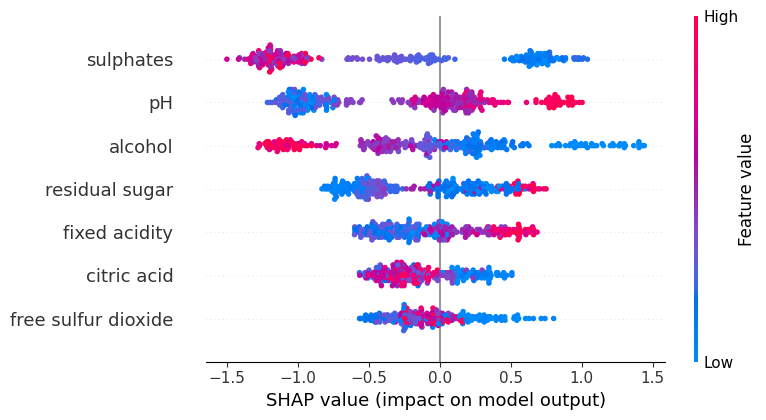


=== SHAP Summary for class Medium (1) ===


C:\Users\parsa\AppData\Local\Temp\ipykernel_16804\1951861122.py:138: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


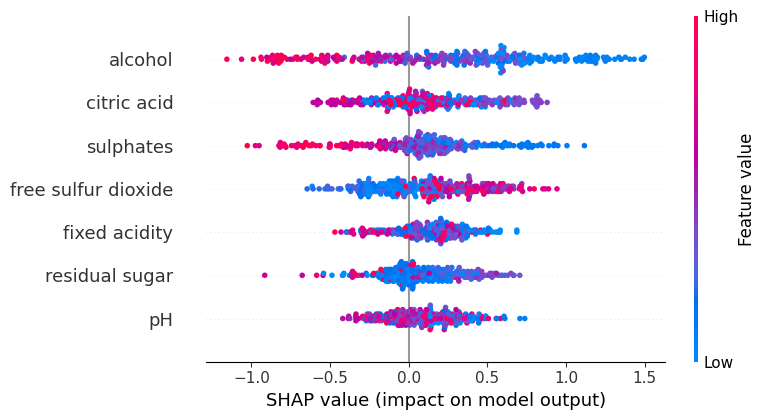


=== SHAP Summary for class High (2) ===


C:\Users\parsa\AppData\Local\Temp\ipykernel_16804\1951861122.py:138: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


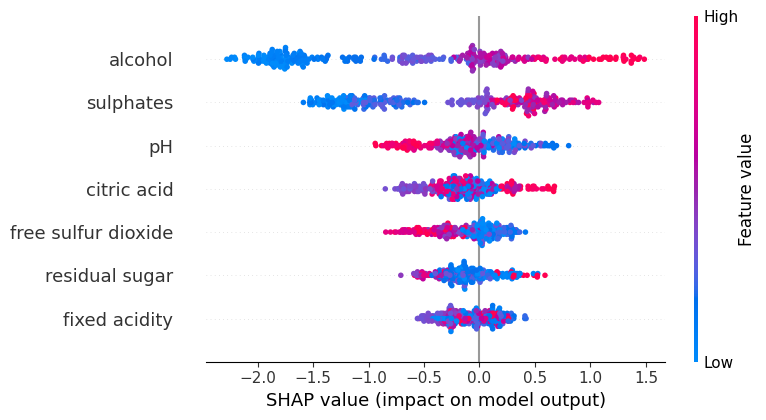

C:\Users\parsa\AppData\Local\Temp\ipykernel_16804\1951861122.py:147: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


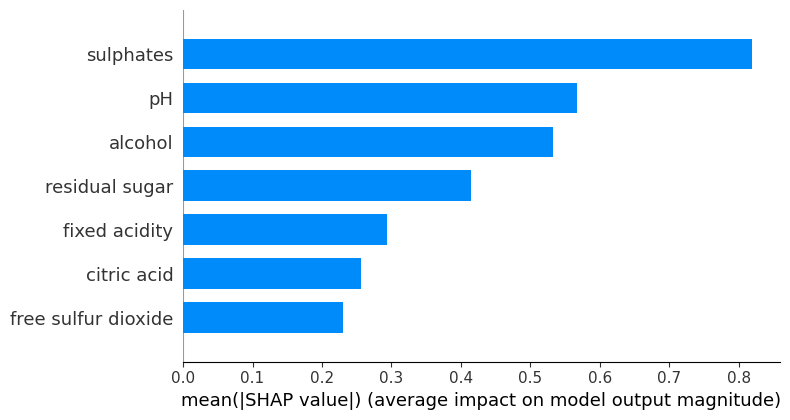

C:\Users\parsa\AppData\Local\Temp\ipykernel_16804\1951861122.py:147: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


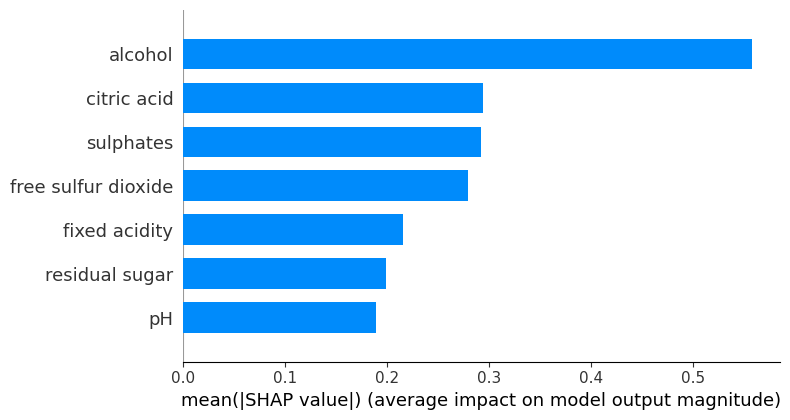

C:\Users\parsa\AppData\Local\Temp\ipykernel_16804\1951861122.py:147: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


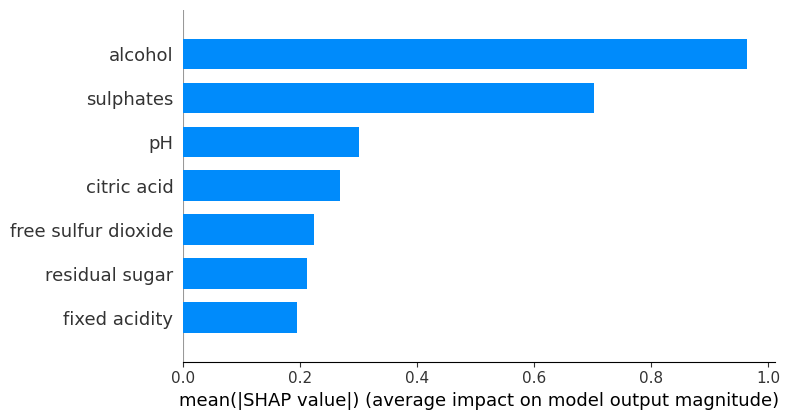

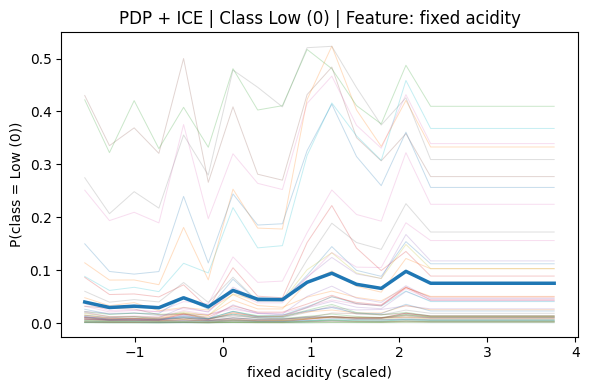

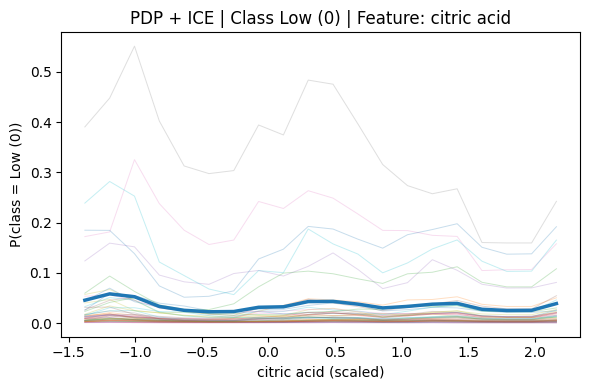

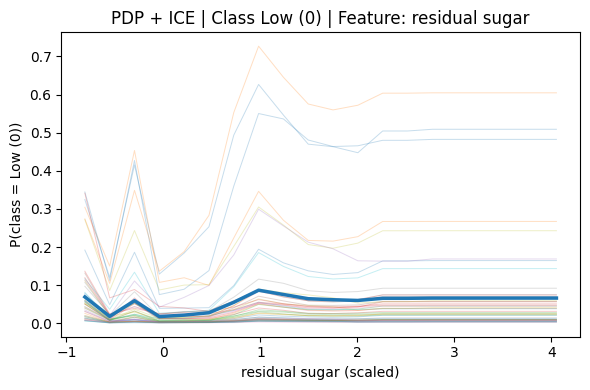

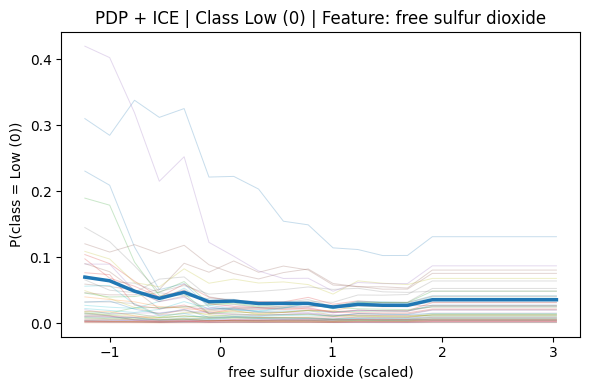

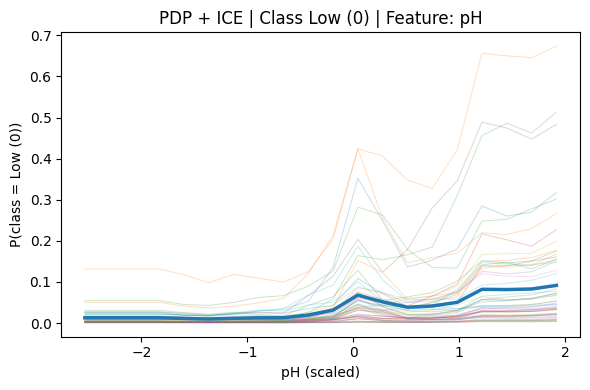

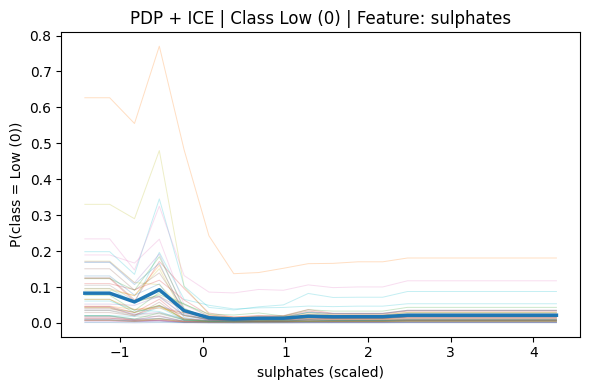

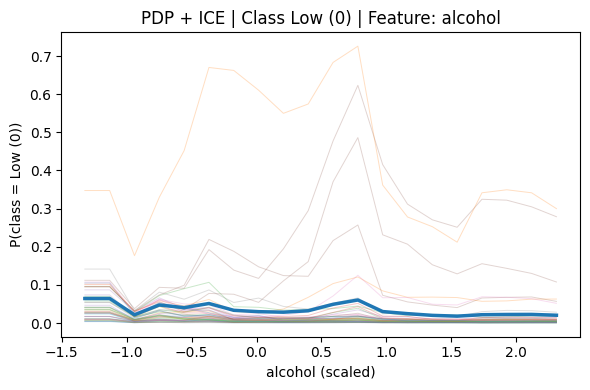

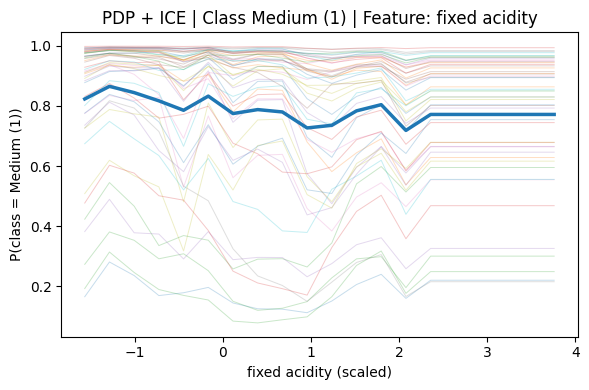

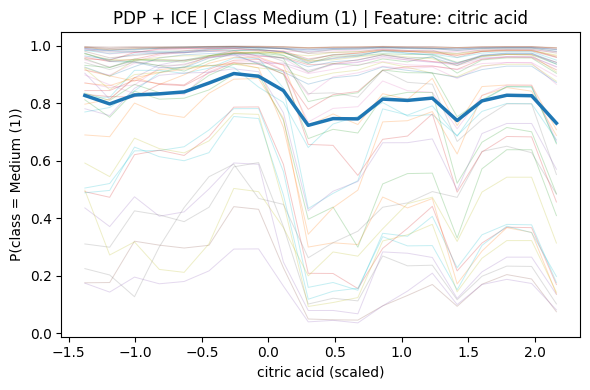

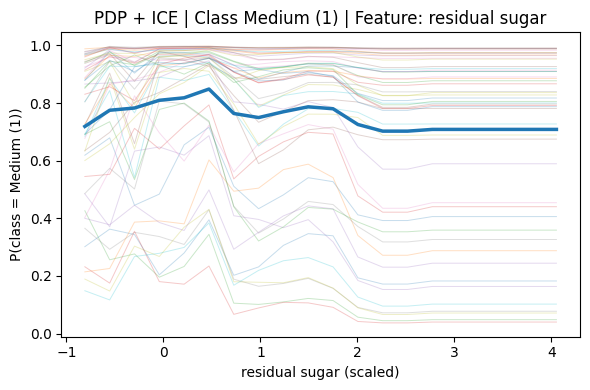

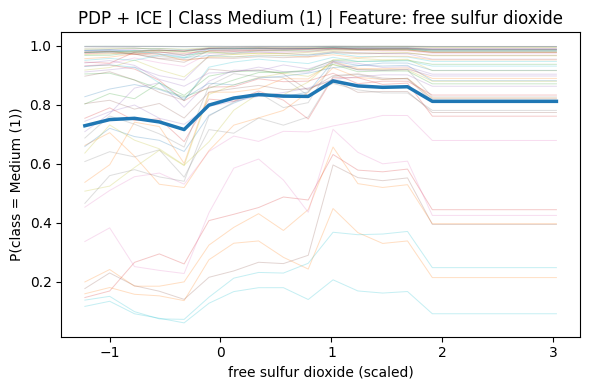

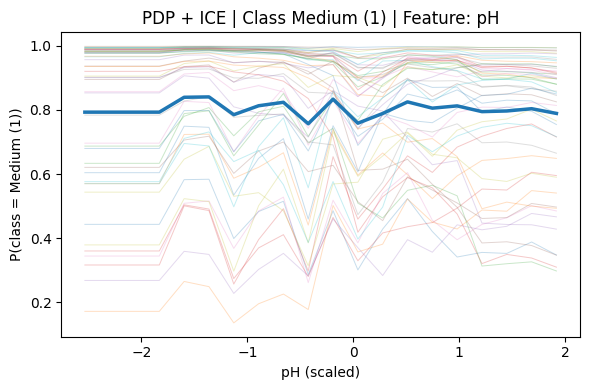

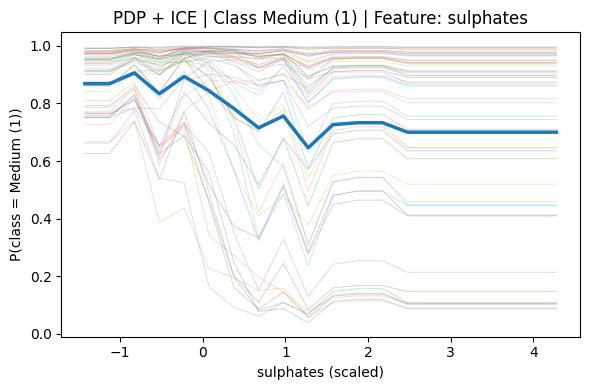

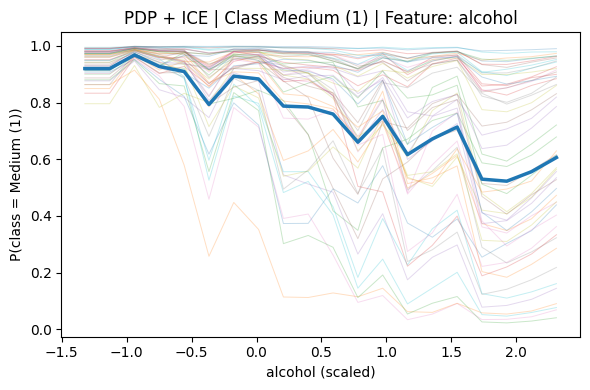

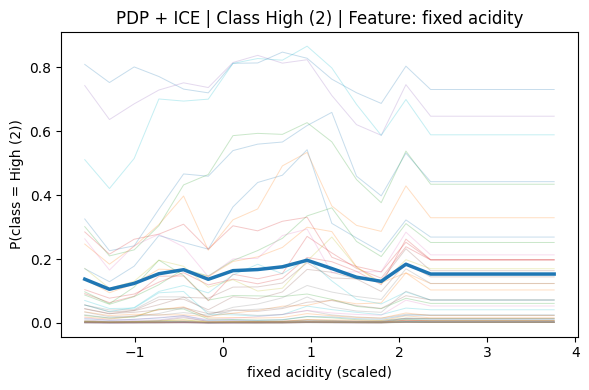

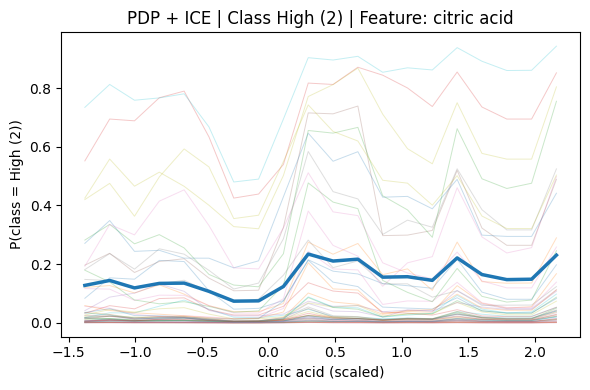

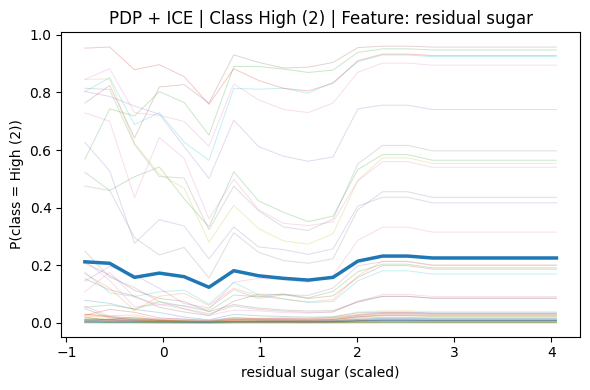

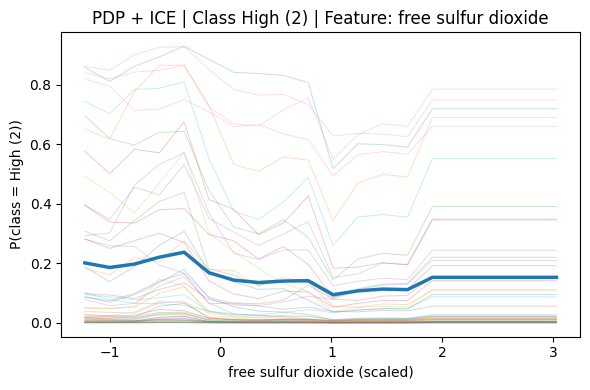

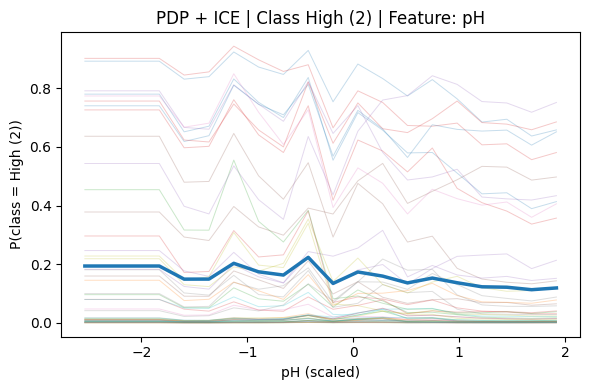

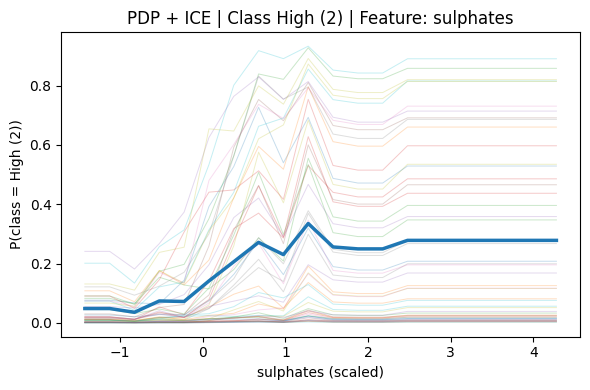

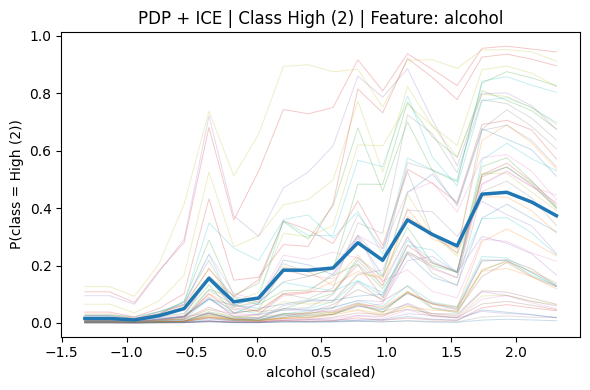

In [ ]:

# FINAL ONE-CELL: XGBoost (3-class red wine) + SHAP + custom PDP+ICE


import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, accuracy_score,
    balanced_accuracy_score, f1_score
)


try:
    import shap
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import shap

shap.initjs()


df2 = df.copy()

# Drop negative-correlation features
cols_to_drop = ["volatile acidity", "chlorides", "density", "total sulfur dioxide"]
df2 = df2.drop(columns=cols_to_drop)

# Map quality to 3 classes
def map_quality_to_3(q):
    if q <= 4:
        return 0    # low
    elif q <= 6:
        return 1    # medium
    return 2        # high

df2["quality_3"] = df2["quality"].apply(map_quality_to_3)

X = df2.drop(["quality", "quality_3"], axis=1)
y = df2["quality_3"].values
feature_names = X.columns.tolist()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_scaled,  columns=feature_names)


# Class weights

class_weights = {0: 1.5, 1: 1.0, 2: 2.0}
sample_weight = np.array([class_weights[c] for c in y_train])


best_params = {
    "max_depth":        15,
    "min_child_weight": 9.668935848805932,
    "gamma":            0.00009095012612370273,
    "subsample":        0.6258789072606735,
    "colsample_bytree": 0.6557422487002118,
    "reg_alpha":        0.000169001953217316647,
    "reg_lambda":       0.9265092532243562,
    "learning_rate":    0.13994538512575225,
}

model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    tree_method="gpu_hist",
    predictor="gpu_predictor",
    eval_metric="mlogloss",
    n_estimators=2000,
    seed=42,
    **best_params,
)

model.fit(
    X_train_scaled,
    y_train,
    sample_weight=sample_weight,
    eval_set=[(X_test_scaled, y_test)],
    early_stopping_rounds=50,
    verbose=False,
)


y_pred = model.predict(X_test_scaled)
acc  = accuracy_score(y_test, y_pred)
bal  = balanced_accuracy_score(y_test, y_pred)
mf1  = f1_score(y_test, y_pred, average="macro")

print("=== FINAL MODEL (single run) ===")
print(f"Accuracy:        {acc:.4f}")
print(f"Balanced Acc:    {bal:.4f}")
print(f"Macro F1:        {mf1:.4f}\n")
print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))


# SHAP for all 3 classes (handles both SHAP styles)

explainer = shap.TreeExplainer(model)
shap_values_raw = explainer.shap_values(X_test_scaled)

# SHAP can return a list or a single 3D array; handle both
if isinstance(shap_values_raw, list):
    shap_values_list = shap_values_raw
else:
    # shape: (n_samples, n_features, n_classes)
    shap_values_list = [
        shap_values_raw[:, :, c] for c in range(shap_values_raw.shape[2])
    ]

class_names = ["Low (0)", "Medium (1)", "High (2)"]

# SHAP summary plots 
for cls_idx, cls_name in enumerate(class_names):
    print(f"\n=== SHAP Summary for class {cls_name} ===")
    shap.summary_plot(
        shap_values_list[cls_idx],
        X_test_df,
        feature_names=feature_names,
        show=True
    )

# --- SHAP bar plots (mean |SHAP|) ---
for cls_idx, cls_name in enumerate(class_names):
    shap.summary_plot(
        shap_values_list[cls_idx],
        X_test_df,
        feature_names=feature_names,
        plot_type="bar",
        show=True
    )


# Custom PDP + ICE for ALL features & ALL 3 classes


def plot_pdp_ice(
    model,
    X,
    feat_idx,
    class_idx,
    feat_name,
    class_name,
    grid_points=20,
    n_ice_lines=50,
):
    """
    Custom PDP + ICE:
      - X: ndarray (n_samples, n_features), scaled
      - feat_idx: column index
      - class_idx: class index for predict_proba
    """
    n_samples, n_features = X.shape

    # Grid over feature range (1st–99th percentile to cut outliers)
    vals = X[:, feat_idx]
    vmin, vmax = np.percentile(vals, [1, 99])
    grid = np.linspace(vmin, vmax, grid_points)

    # Choose subset of samples for ICE
    n_ice = min(n_ice_lines, n_samples)
    ice_idx = np.random.choice(n_samples, size=n_ice, replace=False)

    pdp = np.zeros(len(grid))
    ice = np.zeros((n_ice, len(grid)))

    for gi, g in enumerate(grid):
        X_mod = X.copy()
        X_mod[:, feat_idx] = g
        probs = model.predict_proba(X_mod)[:, class_idx]

        pdp[gi] = probs.mean()
        ice[:, gi] = probs[ice_idx]

    # Plot
    fig, ax = plt.subplots(figsize=(6, 4))

    # ICE lines
    for i in range(n_ice):
        ax.plot(grid, ice[i, :], alpha=0.25, linewidth=0.7)

    # PDP line
    ax.plot(grid, pdp, linewidth=2.5)

    ax.set_xlabel(f"{feat_name} (scaled)")
    ax.set_ylabel(f"P(class = {class_name})")
    ax.set_title(f"PDP + ICE | Class {class_name} | Feature: {feat_name}")
    plt.tight_layout()
    plt.show()


#  Generate PDP + ICE for all features & classes
for cls_idx, cls_name in enumerate(class_names):
    for feat_idx, feat_name in enumerate(feature_names):
        plot_pdp_ice(
            model,
            X_test_scaled,
            feat_idx=feat_idx,
            class_idx=cls_idx,
            feat_name=feat_name,
            class_name=cls_name,
            grid_points=20,
            n_ice_lines=50,
        )


In [ ]:

# FINAL ONE-CELL: XGBoost (3-class red wine) + SHAP + PDP+ICE
#  All plots saved to xgb_shap_pdp_ice_results.pdf


import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from matplotlib.backends.backend_pdf import PdfPages


try:
    import shap
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import shap

shap.initjs()


df2 = df.copy()

# Drop negative-correlation features
cols_to_drop = ["volatile acidity", "chlorides", "density", "total sulfur dioxide"]
df2 = df2.drop(columns=cols_to_drop)

# Map quality to 3 classes
def map_quality_to_3(q):
    if q <= 4:
        return 0    # low
    elif q <= 6:
        return 1    # medium
    return 2        # high

df2["quality_3"] = df2["quality"].apply(map_quality_to_3)

X = df2.drop(["quality", "quality_3"], axis=1)
y = df2["quality_3"].values
feature_names = X.columns.tolist()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_scaled,  columns=feature_names)


# Class weights

class_weights = {0: 1.5, 1: 1.0, 2: 2.0}
sample_weight = np.array([class_weights[c] for c in y_train])


# Train XGBoost with BEST PARAMS

best_params = {
    "max_depth":        15,
    "min_child_weight": 9.668935848805932,
    "gamma":            0.00009095012612370273,
    "subsample":        0.6258789072606735,
    "colsample_bytree": 0.6557422487002118,
    "reg_alpha":        0.000169001953217316647,
    "reg_lambda":       0.9265092532243562,
    "learning_rate":    0.13994538512575225,
}

model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    tree_method="gpu_hist",
    predictor="gpu_predictor",
    eval_metric="mlogloss",
    n_estimators=2000,
    seed=42,
    **best_params,
)

model.fit(
    X_train_scaled,
    y_train,
    sample_weight=sample_weight,
    eval_set=[(X_test_scaled, y_test)],
    early_stopping_rounds=50,
    verbose=False,
)


y_pred = model.predict(X_test_scaled)
acc  = accuracy_score(y_test, y_pred)
bal  = balanced_accuracy_score(y_test, y_pred)
mf1  = f1_score(y_test, y_pred, average="macro")

print("=== FINAL MODEL (single run) ===")
print(f"Accuracy:        {acc:.4f}")
print(f"Balanced Acc:    {bal:.4f}")
print(f"Macro F1:        {mf1:.4f}\n")
print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix (raw counts):")
print(cm)

class_names = ["Low (0)", "Medium (1)", "High (2)"]


pdf = PdfPages("xgb_shap_pdp_ice_results.pdf")


fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)
disp.plot(
    ax=ax,
    cmap="Blues",
    colorbar=True,
    values_format="d",   # integer counts
)
ax.set_title("Confusion Matrix (Counts)")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.tight_layout()
pdf.savefig(fig)
plt.close(fig)


cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(6, 5))
disp_norm = ConfusionMatrixDisplay(
    confusion_matrix=cm_norm,
    display_labels=class_names
)
disp_norm.plot(
    ax=ax,
    cmap="Blues",
    colorbar=True,
    values_format=".2f",   # proportions
)
ax.set_title("Confusion Matrix (Row-normalized)")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.tight_layout()
pdf.savefig(fig)
plt.close(fig)


explainer = shap.TreeExplainer(model)
shap_values_raw = explainer.shap_values(X_test_scaled)

# SHAP can return a list or a single 3D array; handle both
if isinstance(shap_values_raw, list):
    shap_values_list = shap_values_raw
else:
    # shape: (n_samples, n_features, n_classes)
    shap_values_list = [
        shap_values_raw[:, :, c] for c in range(shap_values_raw.shape[2])
    ]

# --- SHAP summary plots (per class) ---
for cls_idx, cls_name in enumerate(class_names):
    print(f"\n=== SHAP Summary for class {cls_name} ===")
    shap.summary_plot(
        shap_values_list[cls_idx],
        X_test_df,
        feature_names=feature_names,
        show=False
    )
    fig = plt.gcf()
    fig.suptitle(f"SHAP Summary – Class {cls_name}", fontsize=12)
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

#  SHAP bar plots (mean |SHAP| per feature, per class) 
for cls_idx, cls_name in enumerate(class_names):
    shap.summary_plot(
        shap_values_list[cls_idx],
        X_test_df,
        feature_names=feature_names,
        plot_type="bar",
        show=False
    )
    fig = plt.gcf()
    fig.suptitle(f"SHAP Bar – Mean |SHAP| – Class {cls_name}", fontsize=12)
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)


# Custom PDP + ICE for ALL features & ALL 3 classes

def plot_pdp_ice(
    model,
    X,
    feat_idx,
    class_idx,
    feat_name,
    class_name,
    grid_points=20,
    n_ice_lines=50,
):
    """
    Custom PDP + ICE:
      - X: ndarray (n_samples, n_features), scaled
      - feat_idx: column index
      - class_idx: class index for predict_proba
    """
    n_samples, n_features = X.shape

    # Grid over feature range 
    vals = X[:, feat_idx]
    vmin, vmax = np.percentile(vals, [1, 99])
    grid = np.linspace(vmin, vmax, grid_points)

    # Choose subset of samples for ICE
    n_ice = min(n_ice_lines, n_samples)
    ice_idx = np.random.choice(n_samples, size=n_ice, replace=False)

    pdp = np.zeros(len(grid))
    ice = np.zeros((n_ice, len(grid)))

    for gi, g in enumerate(grid):
        X_mod = X.copy()
        X_mod[:, feat_idx] = g
        probs = model.predict_proba(X_mod)[:, class_idx]

        pdp[gi] = probs.mean()
        ice[:, gi] = probs[ice_idx]

    # Plot
    fig, ax = plt.subplots(figsize=(6, 4))

    # ICE lines
    for i in range(n_ice):
        ax.plot(grid, ice[i, :], alpha=0.25, linewidth=0.7)

    # PDP line
    ax.plot(grid, pdp, linewidth=2.5)

    ax.set_xlabel(f"{feat_name} (scaled)")
    ax.set_ylabel(f"P(class = {class_name})")
    ax.set_title(f"PDP + ICE | Class {class_name} | Feature: {feat_name}")
    plt.tight_layout()

    # SAVE to PDF instead of plt.show()
    pdf.savefig(fig)
    plt.close(fig)


# Generate PDP + ICE for all features & classes 
for cls_idx, cls_name in enumerate(class_names):
    for feat_idx, feat_name in enumerate(feature_names):
        plot_pdp_ice(
            model,
            X_test_scaled,
            feat_idx=feat_idx,
            class_idx=cls_idx,
            feat_name=feat_name,
            class_name=cls_name,
            grid_points=20,
            n_ice_lines=50,
        )


pdf.close()
print("Saved all plots to xgb_shap_pdp_ice_results.pdf")


d:\red wine project\.venv-gpu\Lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


=== FINAL MODEL (single run) ===
Accuracy:        0.8812
Balanced Acc:    0.6433
Macro F1:        0.6685

Classification report:
              precision    recall  f1-score   support

           0     1.0000    0.2308    0.3750        13
           1     0.9248    0.9318    0.9283       264
           2     0.6471    0.7674    0.7021        43

    accuracy                         0.8812       320
   macro avg     0.8573    0.6433    0.6685       320
weighted avg     0.8905    0.8812    0.8754       320


Confusion matrix (raw counts):
[[  3  10   0]
 [  0 246  18]
 [  0  10  33]]

=== SHAP Summary for class Low (0) ===


C:\Users\parsa\AppData\Local\Temp\ipykernel_16804\3062043060.py:199: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



=== SHAP Summary for class Medium (1) ===


C:\Users\parsa\AppData\Local\Temp\ipykernel_16804\3062043060.py:199: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



=== SHAP Summary for class High (2) ===


C:\Users\parsa\AppData\Local\Temp\ipykernel_16804\3062043060.py:199: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
C:\Users\parsa\AppData\Local\Temp\ipykernel_16804\3062043060.py:213: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
C:\Users\parsa\AppData\Local\Temp\ipykernel_16804\3062043060.py:213: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
C:\Users\parsa\AppData\Local\Temp\ipykernel_16804\30620430

Saved all plots to xgb_shap_pdp_ice_results.pdf
